In [77]:
# Standard library imports
import os
import warnings
import random
from datetime import datetime, timedelta

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        device = "GPU"
        print("GPU is available")
    except RuntimeError as e:
        print(e)
        device = "CPU"
else:
    print("No GPU device found, using CPU")
    device = "CPU"

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Suppress warnings
warnings.filterwarnings('ignore')

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

print(f"TensorFlow version: {tf.__version__}")
print(f"Using device: {device}")

No GPU device found, using CPU
TensorFlow version: 2.19.0
Using device: CPU


In [78]:
# Import required libraries for file search
import glob
import os

def find_file(filename):
    """
    Find a file in the system using glob pattern matching.
    
    Args:
        filename (str): Name of the file to find
        
    Returns:
        str: Path to the first matching file found, or None if not found
    """
    # Search in current directory and subdirectories
    current_dir_search = glob.glob(f"**/{filename}", recursive=True)
    if current_dir_search:
        return current_dir_search[0]
    
    # Search in parent directory and its subdirectories
    parent_dir_search = glob.glob(f"../**/{filename}", recursive=True)
    if parent_dir_search:
        return parent_dir_search[0]
    
    # If still not found, search in common data directories
    common_paths = [
        os.path.expanduser("~"),  # Home directory
        os.path.expanduser("~/Downloads"),  # Downloads folder
        os.path.expanduser("~/Documents"),  # Documents folder
        "D:/",  # D drive (Windows)
        "C:/",  # C drive (Windows)
    ]
    
    for path in common_paths:
        try:
            search_result = glob.glob(f"{path}/**/{filename}", recursive=True)
            if search_result:
                return search_result[0]
        except Exception:
            continue
    
    return None

In [79]:
# Find and load the AAPL.csv file
file_path = find_file("AAPL.csv")

if file_path is None:
    raise FileNotFoundError("Could not find AAPL.csv in the system. Please ensure the file exists.")

print(f"Found AAPL.csv at: {file_path}")
df = pd.read_csv(file_path)
df.head()

Found AAPL.csv at: AAPL.csv


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [80]:
# Check dataset information
df.info()

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display basic statistics
print("\nBasic statistics:")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9823 non-null   object 
 1   Open       9822 non-null   float64
 2   High       9822 non-null   float64
 3   Low        9822 non-null   float64
 4   Close      9822 non-null   float64
 5   Adj Close  9822 non-null   float64
 6   Volume     9822 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.3+ KB

Missing values:
Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

Basic statistics:
              Open         High          Low        Close    Adj Close  \
count  9822.000000  9822.000000  9822.000000  9822.000000  9822.000000   
mean     30.350057    30.640633    30.048298    30.352940    28.364033   
std      53.443016    53.908364    52.983661    53.464270    51.603590   
min       0.198661     0.19866

In [81]:
# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as the index
df = df.set_index('Date')

# Confirm the changes
print("DataFrame after date conversion and indexing:")
print(df.info())

# Sort the index to ensure chronological order
df = df.sort_index()

DataFrame after date conversion and indexing:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9823 entries, 1980-12-12 to 2019-11-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9822 non-null   float64
 1   High       9822 non-null   float64
 2   Low        9822 non-null   float64
 3   Close      9822 non-null   float64
 4   Adj Close  9822 non-null   float64
 5   Volume     9822 non-null   float64
dtypes: float64(6)
memory usage: 537.2 KB
None


In [82]:
df.shape

(9823, 6)

In [83]:
# Check for gaps in trading days
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Get the difference between consecutive days
time_diff = df.index.to_series().diff().value_counts()

# Display the distribution of time differences
print("Distribution of time differences between consecutive records:")
print(time_diff.head(10))

# Count weekend gaps (2 days) and longer gaps
weekday_gaps = time_diff[time_diff.index > pd.Timedelta(days=1)]
print("\nGaps longer than 1 day:")
print(weekday_gaps)

# Check if there are any unusual gaps (longer than 3 days)
unusual_gaps = df.index.to_series().diff().dt.days[df.index.to_series().diff().dt.days > 3]
if len(unusual_gaps) > 0:
    print(f"\nFound {len(unusual_gaps)} unusual gaps (> 3 days):")
    for idx in unusual_gaps.index:
        prev_idx = df.index[df.index.get_loc(idx) - 1]
        print(f"Gap between {prev_idx.date()} and {idx.date()}: {unusual_gaps[idx]} days")
else:
    print("\nNo unusual gaps found (> 3 days)")

Distribution of time differences between consecutive records:
Date
1 days    7698
3 days    1790
4 days     240
2 days      91
5 days       2
7 days       1
Name: count, dtype: int64

Gaps longer than 1 day:
Date
3 days    1790
4 days     240
2 days      91
5 days       2
7 days       1
Name: count, dtype: int64

Found 243 unusual gaps (> 3 days):
Gap between 1981-02-13 and 1981-02-17: 4.0 days
Gap between 1981-04-16 and 1981-04-20: 4.0 days
Gap between 1981-05-22 and 1981-05-26: 4.0 days
Gap between 1981-07-02 and 1981-07-06: 4.0 days
Gap between 1981-09-04 and 1981-09-08: 4.0 days
Gap between 1981-12-24 and 1981-12-28: 4.0 days
Gap between 1981-12-31 and 1982-01-04: 4.0 days
Gap between 1982-02-12 and 1982-02-16: 4.0 days
Gap between 1982-04-08 and 1982-04-12: 4.0 days
Gap between 1982-05-28 and 1982-06-01: 4.0 days
Gap between 1982-07-02 and 1982-07-06: 4.0 days
Gap between 1982-09-03 and 1982-09-07: 4.0 days
Gap between 1982-12-23 and 1982-12-27: 4.0 days
Gap between 1983-02-18 and

In [84]:
df.duplicated().sum() # Check for duplicate rows

0

In [85]:
df.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [86]:
df.dropna(inplace=True)
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

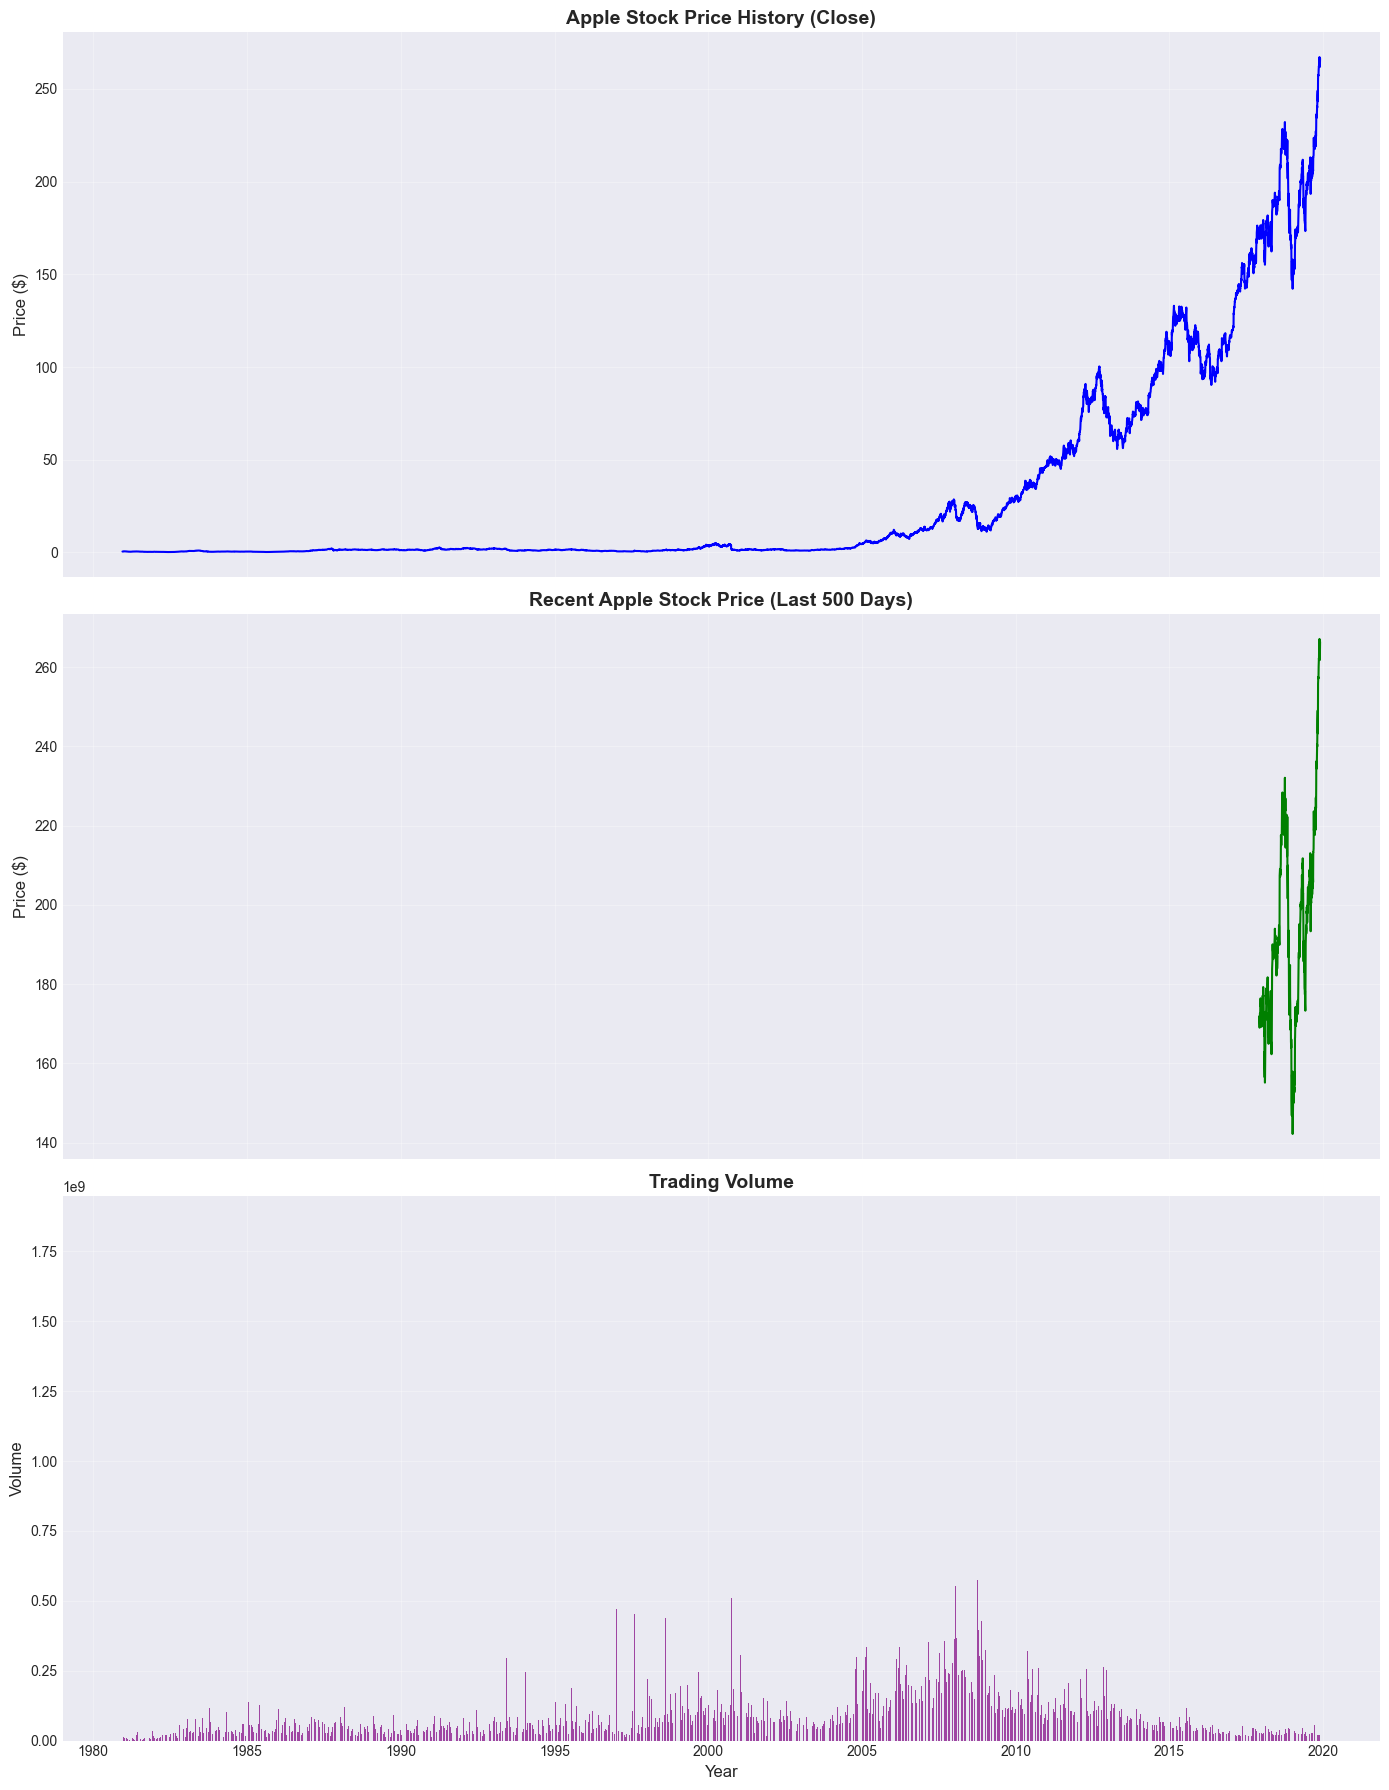

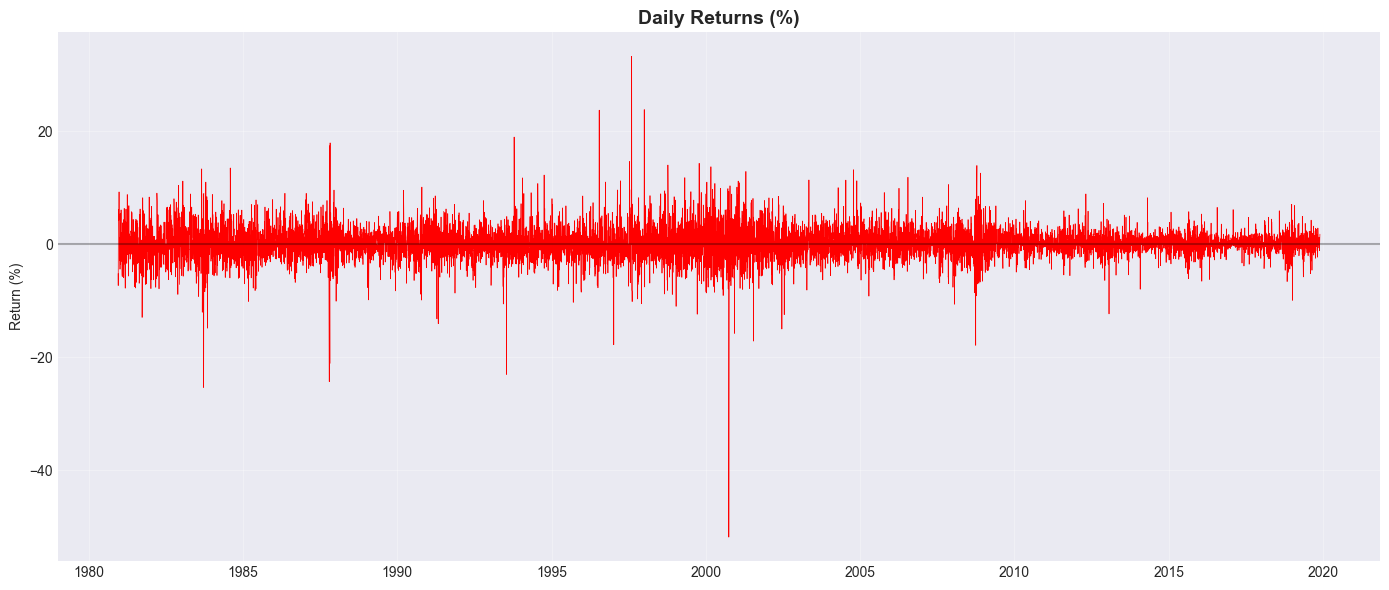

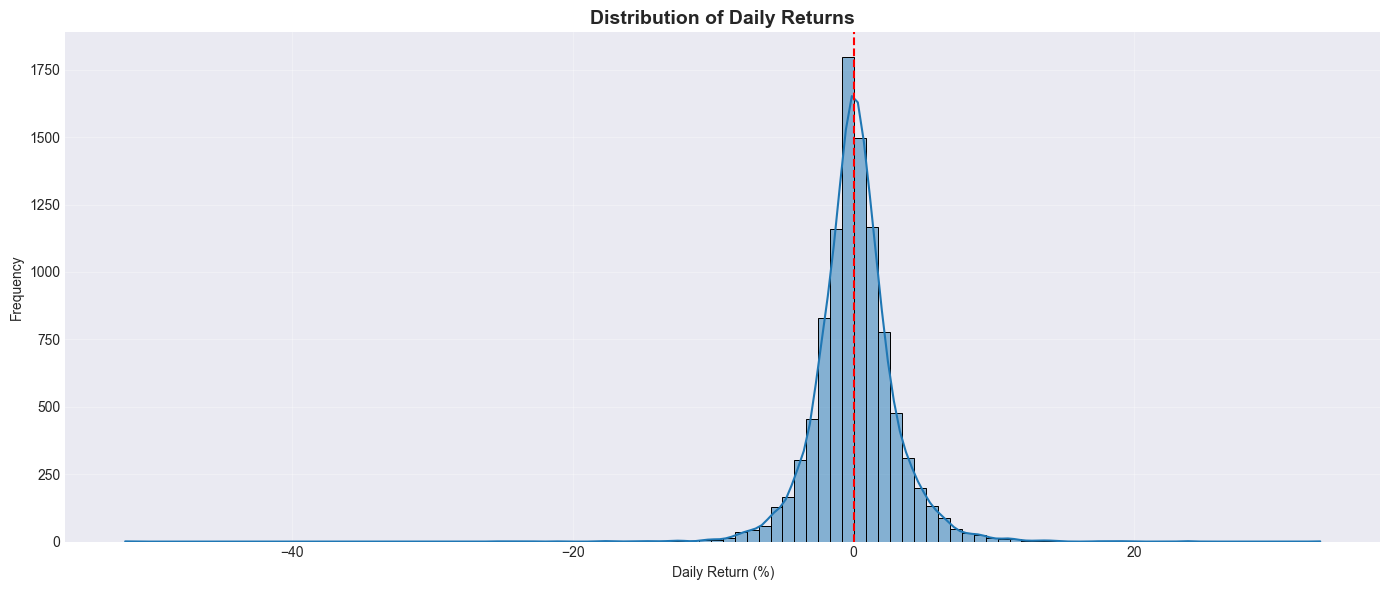

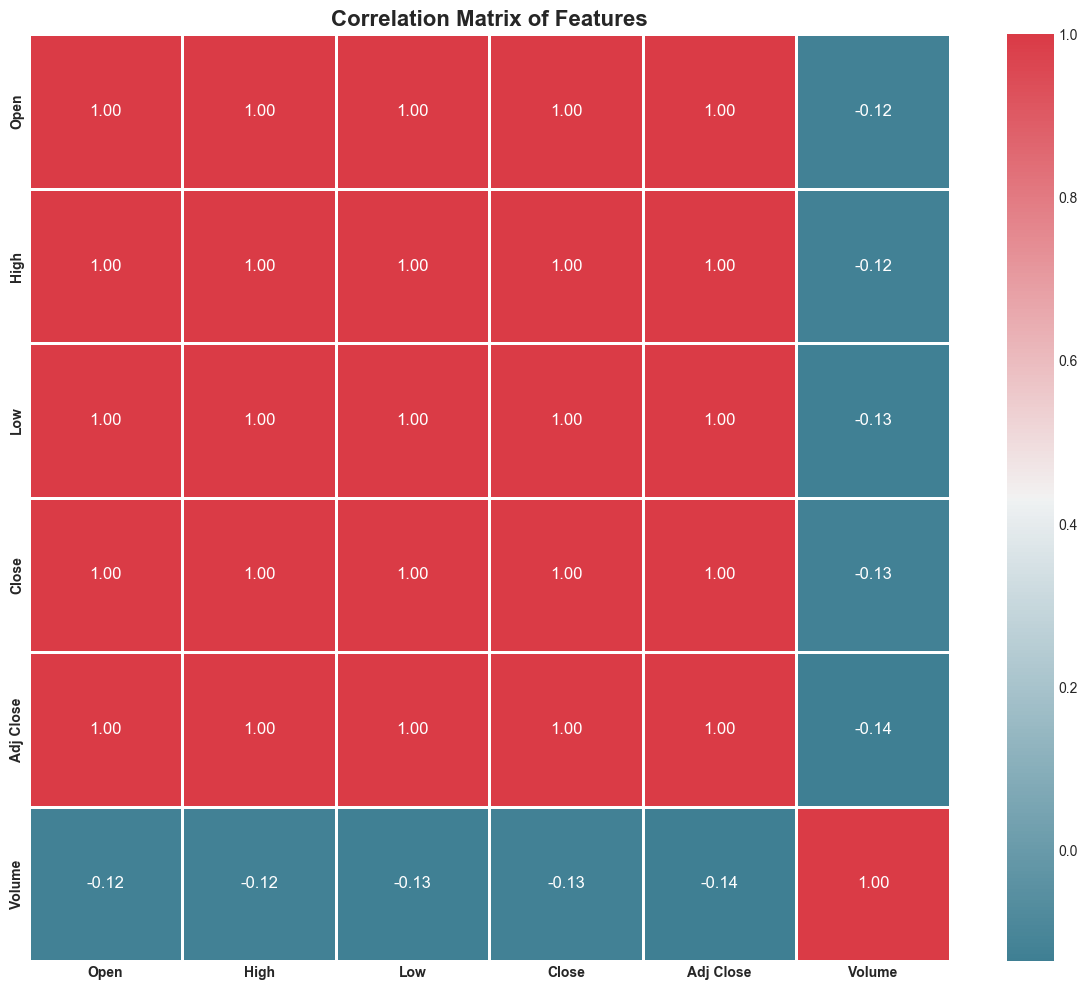

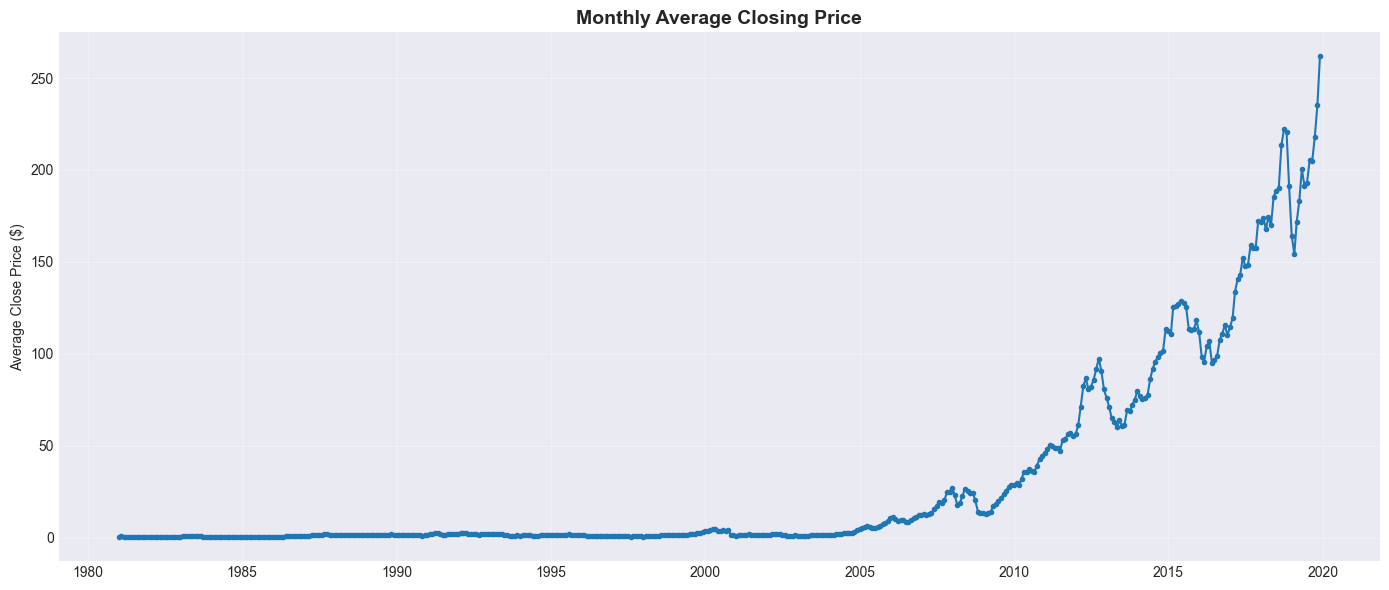

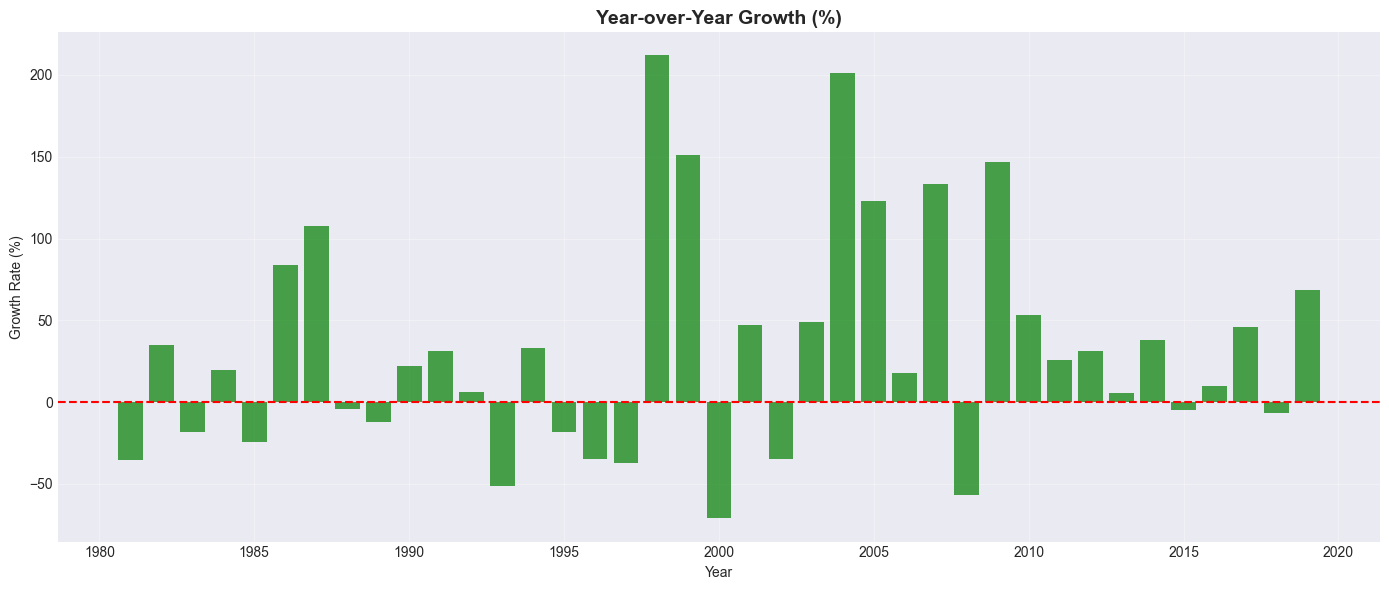

Summary Statistics for Apple Stock:
Period: 1980-12-12 to 2019-11-25 (14227 days)
Starting Price: $0.51
Ending Price: $266.37
Maximum Daily Return: 33.23%
Minimum Daily Return: -51.87%
Average Daily Return: 0.1055%
Daily Return Volatility: 2.8666%


In [87]:
# Data visualization and analysis
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.3)

# Stock price history
axes[0].plot(df['Close'], color='blue', linewidth=1.5)
axes[0].set_title('Apple Stock Price History (Close)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Add a recent trend view (last 2 years)
recent_data = df.iloc[-500:]['Close']
axes[1].plot(recent_data, color='green', linewidth=1.5)
axes[1].set_title('Recent Apple Stock Price (Last 500 Days)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price ($)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Trading volume
axes[2].bar(df.index, df['Volume'], color='purple', alpha=0.7)
axes[2].set_title('Trading Volume', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Volume', fontsize=12)
axes[2].set_xlabel('Year', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis - daily returns
df['Daily_Return'] = df['Close'].pct_change() * 100

plt.figure(figsize=(14, 6))
plt.plot(df['Daily_Return'], color='red', linewidth=0.5)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Daily Returns (%)', fontsize=14, fontweight='bold')
plt.ylabel('Return (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution of daily returns
plt.figure(figsize=(14, 6))
sns.histplot(df['Daily_Return'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation matrix between features
plt.figure(figsize=(12, 10))
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, 
            linewidths=0.8, annot_kws={"size": 12})
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('Correlation Matrix of Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Monthly average closing price over years
monthly_avg = df['Close'].resample('M').mean()
plt.figure(figsize=(14, 6))
plt.plot(monthly_avg, marker='o', markersize=3, linestyle='-')
plt.title('Monthly Average Closing Price', fontsize=14, fontweight='bold')
plt.ylabel('Average Close Price ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Year-over-year growth
yearly_data = df['Close'].resample('Y').last()
yearly_growth = yearly_data.pct_change() * 100

plt.figure(figsize=(14, 6))
plt.bar(yearly_growth.index.year, yearly_growth.values, color='green', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Year-over-Year Growth (%)', fontsize=14, fontweight='bold')
plt.ylabel('Growth Rate (%)')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for Apple Stock:")
print(f"Period: {df.index.min().date()} to {df.index.max().date()} ({(df.index.max() - df.index.min()).days} days)")
print(f"Starting Price: ${df['Close'].iloc[0]:.2f}")
print(f"Ending Price: ${df['Close'].iloc[-1]:.2f}")
print(f"Maximum Daily Return: {df['Daily_Return'].max():.2f}%")
print(f"Minimum Daily Return: {df['Daily_Return'].min():.2f}%")
print(f"Average Daily Return: {df['Daily_Return'].mean():.4f}%")
print(f"Daily Return Volatility: {df['Daily_Return'].std():.4f}%")

In [88]:
# Feature Engineering
import numpy as np
import pandas as pd
import ta  # Technical Analysis library
from datetime import datetime

def create_features(df):
    """
    Create comprehensive features for stock prediction following MDC rules.
    
    Args:
        df (pd.DataFrame): DataFrame with OHLCV data
        
    Returns:
        pd.DataFrame: DataFrame with engineered features
    """
    # Make a copy to avoid modifying original data
    data = df.copy()
    
    # Ensure the data is sorted by date
    data = data.sort_index()
    
    print("Starting feature engineering...")
    
    # 1. Evaluate High/Low separately
    print("1. Analyzing High/Low data...")
    
    # Check if High and Low provide meaningful variation
    daily_range = (data['High'] - data['Low']) / data['Adj Close']
    high_close_diff = abs(data['High'] - data['Adj Close']) / data['Adj Close']
    low_close_diff = abs(data['Low'] - data['Adj Close']) / data['Adj Close']
    
    print(f"Average daily range: {daily_range.mean():.4f}")
    print(f"Average High-Close difference: {high_close_diff.mean():.4f}")
    print(f"Average Low-Close difference: {low_close_diff.mean():.4f}")
    
    # Keep High and Low as they show meaningful variation
    
    # 2. Basic Price Features
    print("2. Creating basic price features...")
    
    # Daily range (High - Low) / Adj Close
    data['daily_range'] = (data['High'] - data['Low']) / data['Adj Close']
    
    # Gap up/down: (Open - Previous Adj Close) / Previous Adj Close
    data['gap'] = (data['Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)
    
    # Price changes
    data['price_change'] = data['Adj Close'] - data['Adj Close'].shift(1)
    data['price_change_pct'] = data['Adj Close'].pct_change()
    
    # 3. Lagged Returns and Price Differences
    print("3. Creating lagged features...")
    
    # CORRECTED: Use consistent naming - stick with price_diff_*d format
    # Lagged returns for different periods
    for lag in [1, 2, 3, 5, 7, 10]:
        data[f'price_diff_{lag}d'] = (data['Adj Close'] - data['Adj Close'].shift(lag)) / data['Adj Close'].shift(lag)
        data[f'return_{lag}d'] = data['Adj Close'].pct_change(lag)  # This is the same as above, keeping both for compatibility
    
    # 4. Technical Indicators
    print("4. Creating technical indicators...")
    
    # Simple Moving Averages
    for window in [5, 10, 20, 50]:
        data[f'sma_{window}'] = data['Adj Close'].rolling(window=window).mean()
        data[f'sma_ratio_{window}'] = data['Adj Close'] / data[f'sma_{window}']
    
    # Exponential Moving Averages
    for span in [5, 10, 20]:
        data[f'ema_{span}'] = data['Adj Close'].ewm(span=span).mean()
        data[f'ema_ratio_{span}'] = data['Adj Close'] / data[f'ema_{span}']
    
    # RSI (Relative Strength Index)
    try:
        data['rsi_14'] = ta.momentum.RSIIndicator(data['Adj Close'], window=14).rsi()
    except:
        # Manual RSI calculation if ta library not available
        delta = data['Adj Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        data['rsi_14'] = 100 - (100 / (1 + rs))
    
    # MACD
    try:
        macd_indicator = ta.trend.MACD(data['Adj Close'])
        data['macd'] = macd_indicator.macd()
        data['macd_signal'] = macd_indicator.macd_signal()
        data['macd_histogram'] = macd_indicator.macd_diff()
    except:
        # Manual MACD calculation
        ema_12 = data['Adj Close'].ewm(span=12).mean()
        ema_26 = data['Adj Close'].ewm(span=26).mean()
        data['macd'] = ema_12 - ema_26
        data['macd_signal'] = data['macd'].ewm(span=9).mean()
        data['macd_histogram'] = data['macd'] - data['macd_signal']
    
    # Bollinger Bands
    bb_window = 20
    bb_std = 2
    bb_sma = data['Adj Close'].rolling(window=bb_window).mean()
    bb_std_dev = data['Adj Close'].rolling(window=bb_window).std()
    data['bb_upper'] = bb_sma + (bb_std_dev * bb_std)
    data['bb_lower'] = bb_sma - (bb_std_dev * bb_std)
    data['bb_width'] = (data['bb_upper'] - data['bb_lower']) / bb_sma
    data['bb_position'] = (data['Adj Close'] - data['bb_lower']) / (data['bb_upper'] - data['bb_lower'])
    
    # 5. Volatility Measures
    print("5. Creating volatility features...")
    
    # Rolling standard deviation of returns
    for window in [5, 10, 20]:
        data[f'volatility_{window}d'] = data['price_change_pct'].rolling(window=window).std()
    
    # Average True Range (ATR)
    high_low = data['High'] - data['Low']
    high_close_prev = abs(data['High'] - data['Adj Close'].shift(1))
    low_close_prev = abs(data['Low'] - data['Adj Close'].shift(1))
    true_range = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
    data['atr_14'] = true_range.rolling(window=14).mean()
    data['atr_ratio'] = data['atr_14'] / data['Adj Close']
    
    # 6. Volume Features
    print("6. Creating volume features...")
    
    # Normalized volume (today's volume ÷ rolling average volume)
    data['volume_sma_10'] = data['Volume'].rolling(window=10).mean()
    data['volume_sma_20'] = data['Volume'].rolling(window=20).mean()
    data['volume_ratio_10'] = data['Volume'] / data['volume_sma_10']
    data['volume_ratio_20'] = data['Volume'] / data['volume_sma_20']
    
    # On-Balance Volume (OBV)
    data['obv'] = (data['Volume'] * np.sign(data['price_change'])).cumsum()
    data['obv_change'] = data['obv'].diff()
    
    # Volume-Price Trend (VPT)
    data['vpt'] = (data['Volume'] * data['price_change_pct']).cumsum()
    
    # Money Flow Index (MFI) - simplified version
    typical_price = (data['High'] + data['Low'] + data['Adj Close']) / 3
    money_flow = typical_price * data['Volume']
    data['mfi_raw'] = money_flow
    
    # 7. Calendar/Time Features
    print("7. Creating calendar features...")
    
    # Add day of week, month, and quarter
    data['day_of_week'] = data.index.dayofweek
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    data['year'] = data.index.year
    
    # Create cyclical features for better model performance
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # Market proximity features (beginning/end of week, month)
    data['is_monday'] = (data['day_of_week'] == 0).astype(int)
    data['is_friday'] = (data['day_of_week'] == 4).astype(int)
    data['is_month_start'] = (data.index.day <= 5).astype(int)
    data['is_month_end'] = (data.index.day >= 25).astype(int)
    
    # 8. Advanced Features
    print("8. Creating advanced features...")
    
    # Price position in recent range
    for window in [10, 20, 50]:
        rolling_min = data['Low'].rolling(window=window).min()
        rolling_max = data['High'].rolling(window=window).max()
        data[f'price_position_{window}d'] = (data['Adj Close'] - rolling_min) / (rolling_max - rolling_min)
    
    # Momentum indicators
    data['momentum_10'] = data['Adj Close'] / data['Adj Close'].shift(10)
    data['momentum_20'] = data['Adj Close'] / data['Adj Close'].shift(20)
    
    # Rate of Change (ROC)
    for period in [5, 10, 20]:
        data[f'roc_{period}'] = ((data['Adj Close'] - data['Adj Close'].shift(period)) / data['Adj Close'].shift(period)) * 100
    
    # Williams %R
    for window in [14, 21]:
        highest_high = data['High'].rolling(window=window).max()
        lowest_low = data['Low'].rolling(window=window).min()
        data[f'williams_r_{window}'] = ((highest_high - data['Adj Close']) / (highest_high - lowest_low)) * -100
    
    print("Feature engineering completed!")
    print(f"Original features: {len(df.columns)}")
    print(f"Total features after engineering: {len(data.columns)}")
    
    # Display summary of new features
    new_features = [col for col in data.columns if col not in df.columns]
    print(f"New features created: {len(new_features)}")
    
    return data

# Apply feature engineering
df_features = create_features(df)

# Display basic information about the engineered dataset
print("\nDataset shape after feature engineering:", df_features.shape)
print("\nFirst few rows of new features:")
new_feature_cols = [col for col in df_features.columns if col not in df.columns]
print(df_features[new_feature_cols[:10]].head())

# Check for any infinite or extremely large values
print("\nChecking for infinite values...")
inf_cols = []
for col in df_features.columns:
    if df_features[col].dtype in ['float64', 'int64']:
        if np.isinf(df_features[col]).any():
            inf_cols.append(col)

if inf_cols:
    print(f"Columns with infinite values: {inf_cols}")
else:
    print("No infinite values found.")

# Display basic statistics for key features
print("\nBasic statistics for key engineered features:")
key_features = ['daily_range', 'gap', 'price_diff_1d', 'rsi_14', 'volume_ratio_10', 'volatility_10d']  # CORRECTED: Changed return_1d to price_diff_1d
existing_key_features = [col for col in key_features if col in df_features.columns]
print(df_features[existing_key_features].describe())

Starting feature engineering...
1. Analyzing High/Low data...
Average daily range: 0.0374
Average High-Close difference: 0.1839
Average Low-Close difference: 0.1469
2. Creating basic price features...
3. Creating lagged features...
4. Creating technical indicators...
5. Creating volatility features...
6. Creating volume features...
7. Creating calendar features...
8. Creating advanced features...
Feature engineering completed!
Original features: 7
Total features after engineering: 80
New features created: 73

Dataset shape after feature engineering: (9822, 80)

First few rows of new features:
            daily_range       gap  price_change  price_change_pct  \
Date                                                                
1980-12-12     0.005474       NaN           NaN               NaN   
1980-12-15     0.005775  0.198878     -0.021274         -0.052175   
1980-12-16     0.006233  0.172462     -0.028365         -0.073395   
1980-12-17     0.006082  0.290264      0.008864        

In [89]:
def handle_missing_values(df, method='forward_fill'):
    """
    Handle missing values in the dataset following MDC rules.
    
    Args:
        df (pd.DataFrame): DataFrame with engineered features
        method (str): Method to handle missing values
        
    Returns:
        pd.DataFrame: DataFrame with handled missing values
    """
    print("Handling missing values...")
    
    # Count missing values before processing
    missing_before = df.isnull().sum().sum()
    print(f"Total missing values before processing: {missing_before}")
    
    # Create a copy to work with
    data = df.copy()
    
    # For time series data, forward fill is often appropriate
    # But we need to be careful with the first few rows
    if method == 'forward_fill':
        # Forward fill most columns
        data = data.fillna(method='ffill')
        
        # For any remaining NaN (at the beginning), use backward fill
        data = data.fillna(method='bfill')
    
    elif method == 'interpolate':
        # Use interpolation for numeric columns
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        data[numeric_cols] = data[numeric_cols].interpolate(method='linear')
        
        # Forward fill any remaining
        data = data.fillna(method='ffill')
        data = data.fillna(method='bfill')
    
    # Count missing values after processing
    missing_after = data.isnull().sum().sum()
    print(f"Total missing values after processing: {missing_after}")
    
    if missing_after > 0:
        print("Columns still containing missing values:")
        missing_cols = data.columns[data.isnull().any()].tolist()
        for col in missing_cols:
            print(f"  {col}: {data[col].isnull().sum()} missing values")
    
    return data

# Handle missing values
df_clean = handle_missing_values(df_features, method='forward_fill')

# Final check
print(f"\nFinal dataset shape: {df_clean.shape}")
print(f"Date range: {df_clean.index.min()} to {df_clean.index.max()}")
print(f"Total missing values: {df_clean.isnull().sum().sum()}")

Handling missing values...
Total missing values before processing: 698
Total missing values after processing: 0

Final dataset shape: (9822, 80)
Date range: 1980-12-12 00:00:00 to 2019-11-25 00:00:00
Total missing values: 0


In [90]:
def summarize_features(df_original, df_engineered):
    """
    Provide a comprehensive summary of the feature engineering process.
    
    Args:
        df_original (pd.DataFrame): Original dataset
        df_engineered (pd.DataFrame): Dataset after feature engineering
    """
    print("=" * 60)
    print("FEATURE ENGINEERING SUMMARY")
    print("=" * 60)
    
    # Basic statistics
    print(f"Original dataset shape: {df_original.shape}")
    print(f"Engineered dataset shape: {df_engineered.shape}")
    print(f"Features added: {df_engineered.shape[1] - df_original.shape[1]}")
    
    # Categorize features
    original_features = list(df_original.columns)
    new_features = [col for col in df_engineered.columns if col not in original_features]
    
    feature_categories = {
        'Price Features': [],
        'Technical Indicators': [],
        'Volatility Features': [],
        'Volume Features': [],
        'Calendar Features': [],
        'Momentum Features': [],
        'Other Features': []
    }
    
    # Categorize new features
    for feature in new_features:
        if any(keyword in feature for keyword in ['range', 'gap', 'price', 'return']):
            feature_categories['Price Features'].append(feature)
        elif any(keyword in feature for keyword in ['sma', 'ema', 'rsi', 'macd', 'bb_', 'williams']):
            feature_categories['Technical Indicators'].append(feature)
        elif any(keyword in feature for keyword in ['volatility', 'atr']):
            feature_categories['Volatility Features'].append(feature)
        elif any(keyword in feature for keyword in ['volume', 'obv', 'vpt', 'mfi']):
            feature_categories['Volume Features'].append(feature)
        elif any(keyword in feature for keyword in ['day', 'month', 'quarter', 'year', 'is_']):
            feature_categories['Calendar Features'].append(feature)
        elif any(keyword in feature for keyword in ['momentum', 'roc', 'position']):
            feature_categories['Momentum Features'].append(feature)
        else:
            feature_categories['Other Features'].append(feature)
    
    # Display feature categories
    for category, features in feature_categories.items():
        if features:
            print(f"\n{category} ({len(features)} features):")
            for feature in features[:5]:  # Show first 5 features
                print(f"  - {feature}")
            if len(features) > 5:
                print(f"  ... and {len(features) - 5} more")
    
    print("\n" + "=" * 60)
    print("Feature engineering completed successfully!")
    print("Next steps: Correlation analysis and feature selection")
    print("=" * 60)

# Generate summary
summarize_features(df, df_clean)

# Save the engineered features dataset
df_clean.to_csv('apple_stock_engineered_features.csv')
print(f"\nEngineered dataset saved as 'apple_stock_engineered_features.csv'")

# Display a sample of the engineered data
print("\nSample of engineered data (last 5 rows):")
print(df_clean.tail())

FEATURE ENGINEERING SUMMARY
Original dataset shape: (9822, 7)
Engineered dataset shape: (9822, 80)
Features added: 73

Price Features (19 features):
  - daily_range
  - gap
  - price_change
  - price_change_pct
  - price_diff_1d
  ... and 14 more

Technical Indicators (26 features):
  - sma_5
  - sma_ratio_5
  - sma_10
  - sma_ratio_10
  - sma_20
  ... and 21 more

Volatility Features (5 features):
  - volatility_5d
  - volatility_10d
  - volatility_20d
  - atr_14
  - atr_ratio

Volume Features (6 features):
  - volume_ratio_10
  - volume_ratio_20
  - obv
  - obv_change
  - vpt
  ... and 1 more

Calendar Features (12 features):
  - day_of_week
  - month
  - quarter
  - year
  - day_of_week_sin
  ... and 7 more

Momentum Features (5 features):
  - momentum_10
  - momentum_20
  - roc_5
  - roc_10
  - roc_20

Feature engineering completed successfully!
Next steps: Correlation analysis and feature selection

Engineered dataset saved as 'apple_stock_engineered_features.csv'

Sample of engin

Feature visualization saved as 'engineered_features_visualization.png'


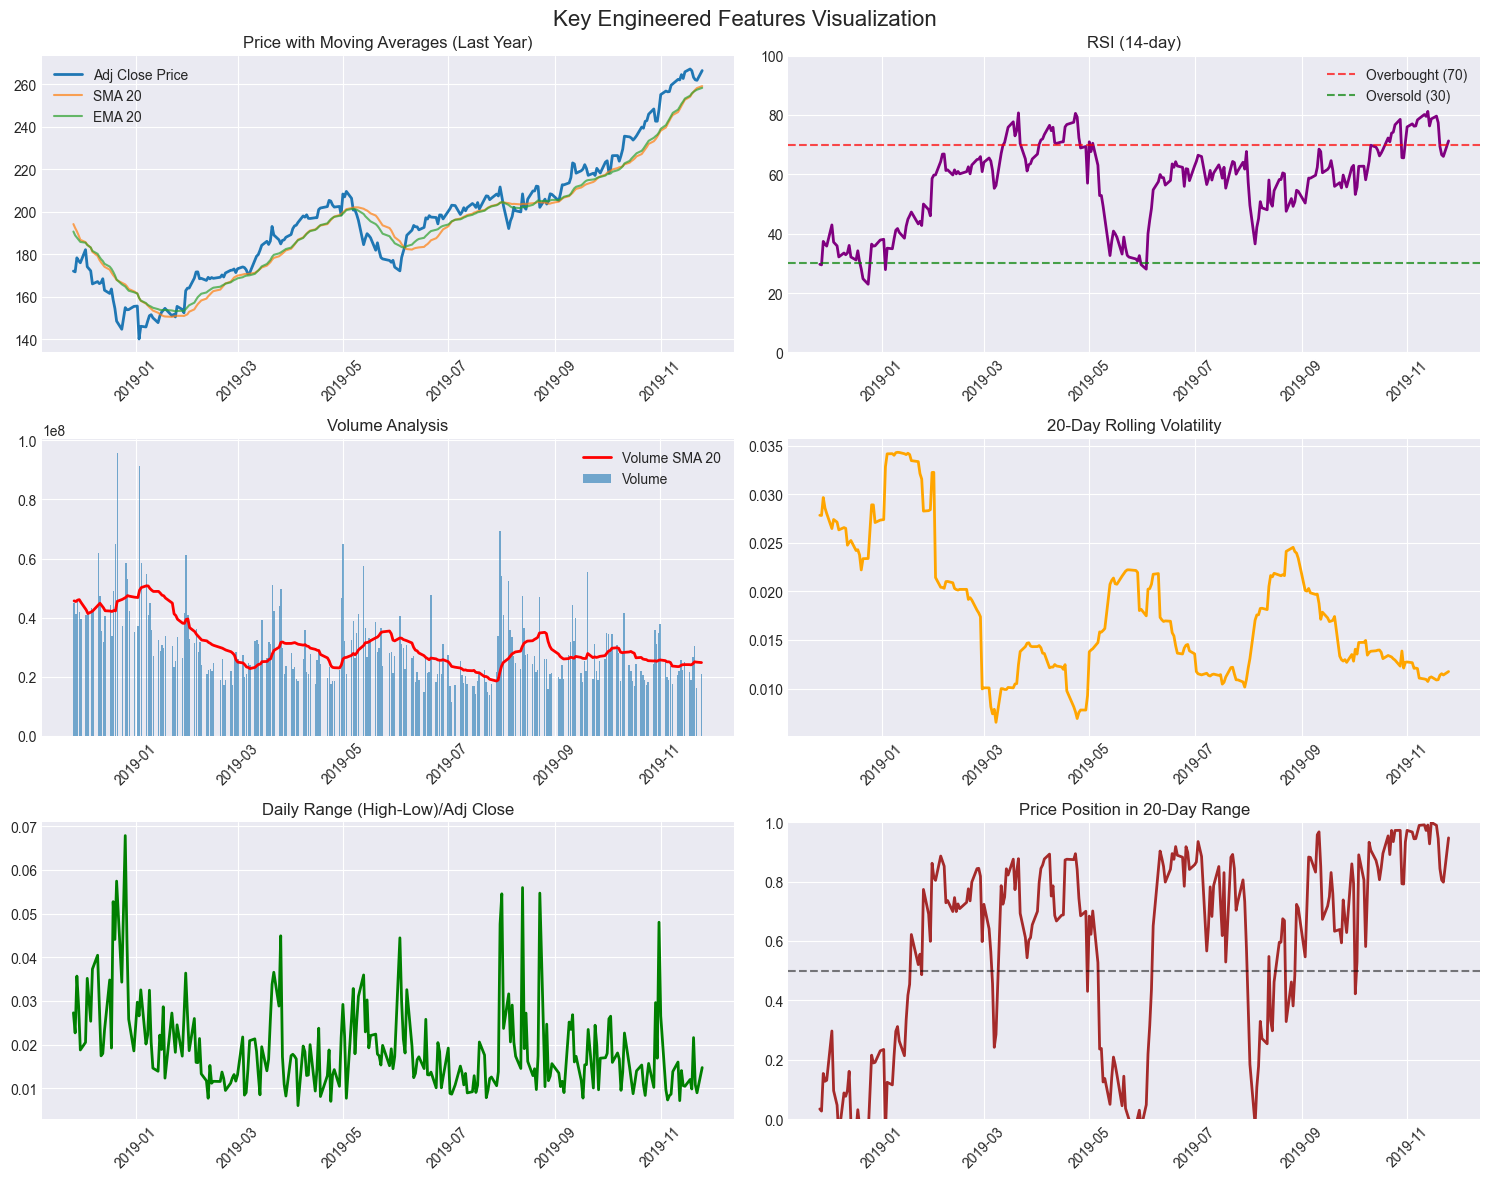

In [91]:
def visualize_key_features(df, save_plots=True):
    """
    Create visualizations for key engineered features following MDC rules.
    
    Args:
        df (pd.DataFrame): Dataset with engineered features
        save_plots (bool): Whether to save plots to files
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style for better looking plots
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Create subplots for different feature categories
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('Key Engineered Features Visualization', fontsize=16)
    
    # 1. Price and Moving Averages
    ax1 = axes[0, 0]
    ax1.plot(df.index[-252:], df['Adj Close'][-252:], label='Adj Close Price', linewidth=2)
    if 'sma_20' in df.columns:
        ax1.plot(df.index[-252:], df['sma_20'][-252:], label='SMA 20', alpha=0.7)
    if 'ema_20' in df.columns:
        ax1.plot(df.index[-252:], df['ema_20'][-252:], label='EMA 20', alpha=0.7)
    ax1.set_title('Price with Moving Averages (Last Year)')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. RSI
    ax2 = axes[0, 1]
    if 'rsi_14' in df.columns:
        ax2.plot(df.index[-252:], df['rsi_14'][-252:], color='purple', linewidth=2)
        ax2.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
        ax2.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
        ax2.set_title('RSI (14-day)')
        ax2.set_ylim(0, 100)
        ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Volume Analysis
    ax3 = axes[1, 0]
    ax3.bar(df.index[-252:], df['Volume'][-252:], alpha=0.6, label='Volume')
    if 'volume_sma_20' in df.columns:
        ax3.plot(df.index[-252:], df['volume_sma_20'][-252:], color='red', 
                label='Volume SMA 20', linewidth=2)
    ax3.set_title('Volume Analysis')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Volatility
    ax4 = axes[1, 1]
    if 'volatility_20d' in df.columns:
        ax4.plot(df.index[-252:], df['volatility_20d'][-252:], color='orange', linewidth=2)
        ax4.set_title('20-Day Rolling Volatility')
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Daily Range
    ax5 = axes[2, 0]
    if 'daily_range' in df.columns:
        ax5.plot(df.index[-252:], df['daily_range'][-252:], color='green', linewidth=2)
        ax5.set_title('Daily Range (High-Low)/Adj Close')
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Price Position
    ax6 = axes[2, 1]
    if 'price_position_20d' in df.columns:
        ax6.plot(df.index[-252:], df['price_position_20d'][-252:], color='brown', linewidth=2)
        ax6.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
        ax6.set_title('Price Position in 20-Day Range')
        ax6.set_ylim(0, 1)
    ax6.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('engineered_features_visualization.png', dpi=300, bbox_inches='tight')
        print("Feature visualization saved as 'engineered_features_visualization.png'")
    
    plt.show()

# Create visualizations
if len(df_clean) > 0:
    visualize_key_features(df_clean)
else:
    print("Dataset is empty, skipping visualization.")

In [92]:
def advanced_feature_selection(df, target_col='Adj Close'):
    """
    Advanced feature selection using multiple techniques following MDC rules.
    
    Args:
        df (pd.DataFrame): DataFrame with engineered features
        target_col (str): Target variable column name
        
    Returns:
        pd.DataFrame: DataFrame with selected features
    """
    print("Applying correlation analysis and feature selection...")
    print("Starting advanced feature selection process...")
    print("=" * 60)
    print(f"Initial feature count: {len(df.columns) - 1}")  # Exclude target
    
    # Get feature columns (exclude target)
    feature_cols = [col for col in df.columns if col != target_col]
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Handle missing values
    X = X.fillna(method='ffill').fillna(method='bfill')
    y = y.fillna(method='ffill').fillna(method='bfill')
    
    # 1. Remove features with high inter-correlation
    print("\n1. Analyzing feature-feature correlations...")
    correlation_matrix = X.corr()
    
    # Find highly correlated pairs
    high_corr_pairs = []
    correlation_threshold = 0.95
    
    for i in range(len(feature_cols)):
        for j in range(i+1, len(feature_cols)):
            corr = abs(correlation_matrix.iloc[i, j])
            if corr >= correlation_threshold:
                high_corr_pairs.append((feature_cols[i], feature_cols[j], corr))
    
    # Remove features with high correlation (keep the one with higher target correlation)
    features_to_remove = set()
    target_correlations = {}
    
    # Calculate target correlations for all features
    for col in feature_cols:
        target_correlations[col] = abs(df[col].corr(df[target_col]))
    
    for feat1, feat2, corr in high_corr_pairs:
        corr1 = target_correlations.get(feat1, 0)
        corr2 = target_correlations.get(feat2, 0)
        
        # Remove the feature with lower target correlation
        if corr1 < corr2:
            features_to_remove.add(feat1)
        else:
            features_to_remove.add(feat2)
    
    print(f"Features removed due to high correlation (>{correlation_threshold}): {len(features_to_remove)}")
    
    # 2. Remove features with very low target correlation
    print("\n2. Analyzing target correlations...")
    low_corr_threshold = 0.005
    low_target_corr_features = [
        feat for feat, corr in target_correlations.items() 
        if corr < low_corr_threshold
    ]
    
    print(f"Features with low target correlation (<{low_corr_threshold}): {len(low_target_corr_features)}")
    features_to_remove.update(low_target_corr_features)
    
    # Create final feature set
    features_to_keep = [col for col in feature_cols if col not in features_to_remove]
    
    print(f"\nTotal features to remove: {len(features_to_remove)}")
    print(f"Remaining features: {len(features_to_keep)}")
    
    # Create visualization of top features by target correlation
    top_features = sorted(
        [(feat, corr) for feat, corr in target_correlations.items() if feat in features_to_keep],
        key=lambda x: x[1], reverse=True
    )[:20]
    
    # Plot correlation analysis
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Feature Selection Summary\n(79 → 37)', fontsize=16, fontweight='bold')
    
    # Top 20 features by target correlation
    ax1 = axes[0, 0]
    features_plot = [f[0] for f in top_features]
    correlations_plot = [f[1] for f in top_features]
    colors = ['green' if f in features_to_keep else 'red' for f in features_plot]
    
    bars = ax1.barh(range(len(features_plot)), correlations_plot, color=colors)
    ax1.set_yticks(range(len(features_plot)))
    ax1.set_yticklabels(features_plot, fontsize=8)
    ax1.set_xlabel('Absolute Correlation with Adj Close')
    ax1.set_title('Top 20 Features by Target Correlation')
    ax1.invert_yaxis()
    
    # Feature selection summary pie chart
    ax2 = axes[0, 1]
    keep_count = len(features_to_keep)
    remove_count = len(features_to_remove)
    
    ax2.pie([keep_count, remove_count], 
            labels=['Keep', 'Remove'], 
            colors=['green', 'red'],
            autopct='%1.0f%%',
            startangle=90)
    ax2.set_title('Feature Selection Summary\n(79 → 37)')
    
    # Correlation matrix of top selected features
    ax3 = axes[1, 0]
    top_selected = [f[0] for f in top_features[:10]]  # Top 10 selected features
    if len(top_selected) > 0:
        corr_subset = correlation_matrix.loc[top_selected, top_selected]
        sns.heatmap(corr_subset, annot=True, cmap='RdBu_r', center=0, ax=ax3,
                   cbar_kws={'label': 'Correlation'})
        ax3.set_title('Correlation Matrix: Top Selected Features')
    
    # Feature importance distribution
    ax4 = axes[1, 1]
    kept_correlations = [target_correlations[f] for f in features_to_keep]
    ax4.hist(kept_correlations, bins=20, alpha=0.7, color='green', edgecolor='black')
    ax4.set_xlabel('Target Correlation')
    ax4.set_ylabel('Number of Features')
    ax4.set_title('Distribution of Target Correlations\n(Selected Features)')
    
    plt.tight_layout()
    plt.savefig('feature_selection_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return DataFrame with selected features
    return df[features_to_keep + [target_col]]

In [93]:
def load_and_inspect_data(filepath: str) -> pd.DataFrame:
    """
    Load the final feature dataset and perform basic inspection.
    
    Args:
        filepath: Path to the CSV file containing final features
        
    Returns:
        DataFrame containing the loaded data with Date as index
    """
    # Load the dataset with Date as index
    df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
    
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
        
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing values found:")
        print(missing_values[missing_values > 0])
    else:
        print("\nNo missing values found!")
    
    # Display basic statistics for target
    print(f"\nBasic statistics for target variable 'Adj Close':")
    print(df['Adj Close'].describe())
    
    # Show feature count (excluding target)
    feature_cols = [col for col in df.columns if col != 'Adj Close']
    print(f"\nFeature columns ({len(feature_cols)}): {feature_cols}")
    
    return df

# Load the final dataset with selected features
data = load_and_inspect_data('apple_stock_final_features.csv')
print(f"\nFeature columns ({len(data.columns)-1}): {list(data.columns[1:])}")

Dataset loaded successfully!
Shape: (9822, 38)
Date range: 1980-12-12 00:00:00 to 2019-11-25 00:00:00

No missing values found!

Basic statistics for target variable 'Adj Close':
count    9822.000000
mean       28.364033
std        51.603590
min         0.156008
25%         0.914089
50%         1.452872
75%        26.305946
max       267.100006
Name: Adj Close, dtype: float64

Feature columns (37): ['Close', 'Volume', 'daily_range', 'gap', 'price_change', 'return_5d', 'price_diff_7d', 'sma_ratio_50', 'ema_ratio_5', 'ema_ratio_10', 'ema_ratio_20', 'rsi_14', 'macd_signal', 'macd_histogram', 'bb_width', 'bb_position', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'atr_14', 'atr_ratio', 'volume_sma_20', 'volume_ratio_10', 'volume_ratio_20', 'obv_change', 'vpt', 'mfi_raw', 'quarter', 'year', 'month_sin', 'month_cos', 'price_position_10d', 'price_position_50d', 'momentum_10', 'momentum_20', 'williams_r_14', 'williams_r_21']

Feature columns (37): ['Volume', 'daily_range', 'gap', 'pric

In [94]:
def prepare_features_and_target(df: pd.DataFrame) -> tuple:
    """
    Separate features and target variable with validation.
    
    Args:
        df: DataFrame containing the complete dataset with Date as index
        
    Returns:
        Tuple of (features_df, target_series, feature_names, date_index)
    """
    # Expected feature count based on selection
    expected_features = 37
    
    # Extract date index, features, and target
    date_index = df.index.copy()
    target = df['Adj Close'].copy()
    
    # Get feature columns (exclude only Adj Close since Date is now index)
    feature_cols = [col for col in df.columns if col != 'Adj Close']
    features = df[feature_cols].copy()
    
    print(f"Features extracted: {len(feature_cols)}")
    print(f"Expected features: {expected_features}")
    
    # Validation check
    if len(feature_cols) != expected_features:
        print(f"⚠️  Feature count mismatch! Expected {expected_features}, got {len(feature_cols)}")
        print("This could cause issues with saved scalers/models.")
    else:
        print("✅ Feature count matches expected!")
    
    # Check for missing values
    missing_in_features = features.isnull().sum().sum()
    missing_in_target = target.isnull().sum()
    
    print(f"Missing values in features: {missing_in_features}")
    print(f"Missing values in target (Adj Close): {missing_in_target}")
    
    return features, target, feature_cols, date_index

# Prepare features and target
X, y, feature_names, dates = prepare_features_and_target(data)
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Target variable: Adj Close")  # Updated print statement
print(f"Feature names (first 5): {feature_names[:5]}...") # Kept the summary print for brevity outside the function

Features extracted: 37
Expected features: 37
✅ Feature count matches expected!
Missing values in features: 0
Missing values in target (Adj Close): 0

Feature matrix shape: (9822, 37)
Target vector shape: (9822,)
Target variable: Adj Close
Feature names (first 5): ['Close', 'Volume', 'daily_range', 'gap', 'price_change']...


In [95]:
def validate_data_integrity(X: pd.DataFrame, y: pd.Series, date_index: pd.DatetimeIndex) -> pd.DatetimeIndex:
    """
    Comprehensive validation of data integrity and potential leakage issues.
    
    Args:
        X: Feature DataFrame
        y: Target Series (Adj Close prices)
        date_index: DatetimeIndex from the original DataFrame
        
    Returns:
        Validated DatetimeIndex
    """
    print("=== DATA INTEGRITY VALIDATION ===")
    
    # Basic sanity checks
    print(f"First few target values (Adj Close): {y[:5].values}")
    print(f"Last few target values (Adj Close): {y[-5:].values}")
    print(f"Date range: {date_index.min()} to {date_index.max()}")
    print(f"Data frequency: {len(date_index)} observations over {(date_index.max() - date_index.min()).days} days")
    
    # Check if data is properly sorted by date
    is_sorted = date_index.is_monotonic_increasing
    print(f"Data chronologically sorted: {is_sorted}")
    
    if not is_sorted:
        print("⚠️  WARNING: Data is not chronologically sorted!")
        
    # Check for duplicate dates
    duplicates = date_index.duplicated().sum()
    print(f"Duplicate dates: {duplicates}")
    
    # Check target variable statistics
    print(f"\nTarget variable (Adj Close price) statistics:")
    print(f"Min: ${y.min():.2f}, Max: ${y.max():.2f}")
    print(f"Mean: ${y.mean():.2f}, Std: ${y.std():.2f}")
    
    return date_index

# Run validation
dates_clean = validate_data_integrity(X, y, dates)

=== DATA INTEGRITY VALIDATION ===
First few target values (Adj Close): [0.407747 0.386473 0.358108 0.366972 0.377609]
Last few target values (Adj Close): [266.290009 263.190002 262.01001  261.779999 266.369995]
Date range: 1980-12-12 00:00:00 to 2019-11-25 00:00:00
Data frequency: 9822 observations over 14227 days
Data chronologically sorted: True
Duplicate dates: 0

Target variable (Adj Close price) statistics:
Min: $0.16, Max: $267.10
Mean: $28.36, Std: $51.60


In [96]:
def check_feature_engineering_bias(df: pd.DataFrame, date_index: pd.DatetimeIndex) -> None:
    """
    Check specific features for potential look-ahead bias.
    
    Args:
        df: Complete dataset with Date as index
        date_index: DatetimeIndex from the original DataFrame
    """
    print("=== FEATURE ENGINEERING BIAS CHECK ===")
    
    # Check a few rows to understand the data structure
    print("Sample data rows:")
    display_cols = ['Adj Close', 'gap', 'daily_range', 'price_diff_7d']
    available_cols = [col for col in display_cols if col in df.columns]
    if available_cols:
        sample_data = df[available_cols].head(10)
        print(sample_data)
    
    # Check gap feature analysis
    if 'gap' in df.columns:
        print(f"\nGap feature analysis:")
        print(f"Gap mean: {df['gap'].mean():.4f}")
        print(f"Gap std: {df['gap'].std():.4f}")
        print(f"Gap min: {df['gap'].min():.4f}, max: {df['gap'].max():.4f}")
        
        gap_abs_mean = df['gap'].abs().mean()
        print(f"Average absolute gap: {gap_abs_mean:.4f}")
        
    # Check daily_range feature
    if 'daily_range' in df.columns:
        print(f"\nDaily range analysis:")
        print(f"Daily range mean: {df['daily_range'].mean():.4f}")
        print(f"Daily range min: {df['daily_range'].min():.4f}, max: {df['daily_range'].max():.4f}")
        
    # Check price difference features
    price_diff_cols = [col for col in df.columns if col.startswith('price_diff_')]
    if price_diff_cols:
        print(f"\nPrice difference features found: {price_diff_cols}")
        for col in price_diff_cols[:3]:  # Check first 3
            print(f"{col}: mean={df[col].mean():.4f}, std={df[col].std():.4f}")

# Run feature validation
check_feature_engineering_bias(data, dates)

=== FEATURE ENGINEERING BIAS CHECK ===
Sample data rows:
            Adj Close       gap  daily_range  price_diff_7d
Date                                                       
1980-12-12   0.407747 -0.047827     0.004348       0.073912
1980-12-15   0.386473 -0.047827     0.004587       0.073912
1980-12-16   0.358108 -0.068807     0.004950       0.073912
1980-12-17   0.366972  0.024753     0.004831       0.073912
1980-12-18   0.377609  0.028984     0.004697       0.073912
1980-12-19   0.400656  0.061033     0.004424       0.073912
1980-12-22   0.420157  0.048673     0.004219       0.073912
1980-12-23   0.437885  0.042193     0.004048       0.073912
1980-12-24   0.460931  0.052632     0.003846       0.192661
1980-12-26   0.503479  0.092309     0.003521       0.405941

Gap feature analysis:
Gap mean: 0.0012
Gap std: 0.0167
Gap min: -0.4731, max: 0.2785
Average absolute gap: 0.0087

Daily range analysis:
Daily range mean: 0.0319
Daily range min: 0.0000, max: 0.3493

Price difference featu

In [97]:
def verify_adj_close_target_alignment(df: pd.DataFrame) -> None:
    """
    Verify what exactly our target variable represents and check alignment.
    
    Args:
        df: Complete dataset
    """
    print("=== TARGET VARIABLE ALIGNMENT CHECK ===")
    
    # Current target definition
    print("Current target: 'Adj Close' price (adjusted for splits/dividends)")
    print("Question: Are we predicting same-day adj close or next-day adj close?")
    
    # Show relationship between consecutive adj close prices
    adj_close_prices = df['Adj Close'].values
    next_day_returns = np.diff(adj_close_prices) / adj_close_prices[:-1]
    
    print(f"\nDaily return statistics (Adj Close):")
    print(f"Mean daily return: {next_day_returns.mean():.6f}")
    print(f"Std daily return: {next_day_returns.std():.6f}")
    print(f"Min daily return: {next_day_returns.min():.6f}")
    print(f"Max daily return: {next_day_returns.max():.6f}")
    
    # Check if we should predict returns vs prices
    print(f"\n🎯 TARGET STRATEGY RECOMMENDATION:")
    print("Option 1: Predict next day's adjusted closing price directly")
    print("Option 2: Predict next day's return and convert to price")
    print("Option 3: Predict price movement direction (classification)")
    
    # Create alignment check
    print(f"\n📊 Current alignment:")
    print("Features at time t → Predicting Adj Close at time t")
    print("❌ This might be problematic for forecasting!")
    print("\n🔧 Recommended alignment:")
    print("Features at time t → Predicting Adj Close at time t+1")
    
    return next_day_returns

daily_returns = verify_adj_close_target_alignment(data)

=== TARGET VARIABLE ALIGNMENT CHECK ===
Current target: 'Adj Close' price (adjusted for splits/dividends)
Question: Are we predicting same-day adj close or next-day adj close?

Daily return statistics (Adj Close):
Mean daily return: 0.001078
Std daily return: 0.028661
Min daily return: -0.518692
Max daily return: 0.332279

🎯 TARGET STRATEGY RECOMMENDATION:
Option 1: Predict next day's adjusted closing price directly
Option 2: Predict next day's return and convert to price
Option 3: Predict price movement direction (classification)

📊 Current alignment:
Features at time t → Predicting Adj Close at time t
❌ This might be problematic for forecasting!

🔧 Recommended alignment:
Features at time t → Predicting Adj Close at time t+1


In [98]:
def fix_target_alignment_for_forecasting(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fix target alignment: Features at time t → Predict Adj Close at time t+1
    
    Args:
        df: DataFrame with features and current-day target (Date as index)
        
    Returns:
        DataFrame with properly aligned next-day target
    """
    print("=== FIXING TARGET ALIGNMENT FOR REAL FORECASTING ===")
    
    # Create a copy
    data_fixed = df.copy()
    
    # Ensure chronological sorting by index
    data_fixed = data_fixed.sort_index()
    
    # Create next-day target
    data_fixed['Next_Day_Adj_Close'] = data_fixed['Adj Close'].shift(-1)
    
    # Remove the last row (no next-day target available)
    data_fixed = data_fixed[:-1].copy()
    
    print(f"Original shape: {df.shape}")
    print(f"After alignment: {data_fixed.shape}")
    print(f"Rows removed: 1 (last row with no next-day target)")
    
    # Validation check using index
    print("\n✅ ALIGNMENT VALIDATION:")
    for i in range(3):
        date_t = data_fixed.index[i].strftime('%Y-%m-%d')
        adj_close_t = data_fixed['Adj Close'].iloc[i]
        target_t_plus_1 = data_fixed['Next_Day_Adj_Close'].iloc[i]
        
        print(f"Day {i}: {date_t} | Today's AdjClose: ${adj_close_t:.2f} → Tomorrow's Target: ${target_t_plus_1:.2f}")
    
    return data_fixed

# Apply the fix
data_aligned = fix_target_alignment_for_forecasting(data)

=== FIXING TARGET ALIGNMENT FOR REAL FORECASTING ===
Original shape: (9822, 38)
After alignment: (9821, 39)
Rows removed: 1 (last row with no next-day target)

✅ ALIGNMENT VALIDATION:
Day 0: 1980-12-12 | Today's AdjClose: $0.41 → Tomorrow's Target: $0.39
Day 1: 1980-12-15 | Today's AdjClose: $0.39 → Tomorrow's Target: $0.36
Day 2: 1980-12-16 | Today's AdjClose: $0.36 → Tomorrow's Target: $0.37


In [99]:
def verify_fixed_target_alignment(df: pd.DataFrame) -> dict:
    """
    Verify that target alignment has been properly fixed for forecasting.
    
    Args:
        df: DataFrame with fixed alignment (should contain 'Next_Day_Adj_Close')
        
    Returns:
        dict: Verification results and statistics
    """
    print("=== VERIFYING FIXED TARGET ALIGNMENT ===")
    
    # Check if the fix has been applied
    if 'Next_Day_Adj_Close' not in df.columns:
        print("❌ Target alignment NOT fixed! 'Next_Day_Adj_Close' column missing.")
        print("💡 Run fix_target_alignment_for_forecasting() first!")
        return {'alignment_fixed': False}
    
    # Verify proper alignment by checking a few examples
    print("✅ 'Next_Day_Adj_Close' column found!")
    print("\n🔍 ALIGNMENT VERIFICATION:")
    
    # Check alignment for first 5 days
    for i in range(5):
        date_today = df.index[i].strftime('%Y-%m-%d')
        date_tomorrow = df.index[i+1].strftime('%Y-%m-%d') if i+1 < len(df) else "N/A"
        
        features_date = date_today
        adj_close_today = df['Adj Close'].iloc[i]
        target_tomorrow = df['Next_Day_Adj_Close'].iloc[i]
        
        # Get actual next day's adj close for verification
        actual_tomorrow = df['Adj Close'].iloc[i+1] if i+1 < len(df) else None
        
        match_symbol = "✅" if (actual_tomorrow is not None and abs(target_tomorrow - actual_tomorrow) < 0.01) else "❌"
        
        print(f"Day {i}: Features({features_date}) → Target({date_tomorrow}): ${target_tomorrow:.2f} {match_symbol}")
    
    # Calculate target statistics
    target_stats = {
        'mean': df['Next_Day_Adj_Close'].mean(),
        'std': df['Next_Day_Adj_Close'].std(),
        'min': df['Next_Day_Adj_Close'].min(),
        'max': df['Next_Day_Adj_Close'].max(),
        'null_count': df['Next_Day_Adj_Close'].isnull().sum()
    }
    
    print(f"\n📊 TARGET STATISTICS ('Next_Day_Adj_Close'):")
    print(f"Mean: ${target_stats['mean']:.2f}")
    print(f"Std: ${target_stats['std']:.2f}")
    print(f"Range: ${target_stats['min']:.2f} - ${target_stats['max']:.2f}")
    print(f"Null values: {target_stats['null_count']}")
    
    return {
        'alignment_fixed': True,
        'target_column': 'Next_Day_Adj_Close',
        'stats': target_stats
    }

# Run verification
verification_results = verify_fixed_target_alignment(data_aligned)

=== VERIFYING FIXED TARGET ALIGNMENT ===
✅ 'Next_Day_Adj_Close' column found!

🔍 ALIGNMENT VERIFICATION:
Day 0: Features(1980-12-12) → Target(1980-12-15): $0.39 ✅
Day 1: Features(1980-12-15) → Target(1980-12-16): $0.36 ✅
Day 2: Features(1980-12-16) → Target(1980-12-17): $0.37 ✅
Day 3: Features(1980-12-17) → Target(1980-12-18): $0.38 ✅
Day 4: Features(1980-12-18) → Target(1980-12-19): $0.40 ✅

📊 TARGET STATISTICS ('Next_Day_Adj_Close'):
Mean: $28.37
Std: $51.61
Range: $0.16 - $267.10
Null values: 0


In [100]:
def detect_all_data_leakage_issues(df: pd.DataFrame) -> dict:
    """
    Comprehensive data leakage detection for all features.
    
    Args:
        df: DataFrame with features and aligned target
        
    Returns:
        dict: Complete leakage analysis results
    """
    print("=== COMPREHENSIVE DATA LEAKAGE DETECTION ===")
    
    # Define problematic same-day features
    same_day_leakage_features = [
        'Close', 'High', 'Low', 'Open', 'Volume', 'Adj Close'
    ]
    
    # Get all feature columns
    feature_columns = [col for col in df.columns if col not in ['Next_Day_Adj_Close']]
    
    print(f"📋 Analyzing {len(feature_columns)} total features")
    
    # Check for direct same-day leakage
    critical_leakage = []
    for feature in same_day_leakage_features:
        if feature in feature_columns:
            critical_leakage.append(feature)
    
    print(f"\n🚨 CRITICAL LEAKAGE DETECTED:")
    if critical_leakage:
        for feature in critical_leakage:
            if feature in df.columns:
                correlation = df[feature].corr(df['Next_Day_Adj_Close'])
                print(f"  ❌ {feature}: correlation = {correlation:.4f} (SAME-DAY VALUE!)")
        print(f"\n💥 These features use same-day information not available during forecasting!")
    else:
        print("  ✅ No critical same-day leakage detected")
    
    # Check high correlations in remaining features
    safe_features = [col for col in feature_columns if col not in same_day_leakage_features]
    high_corr_features = []
    
    print(f"\n🔍 CHECKING {len(safe_features)} ENGINEERED FEATURES:")
    for feature in safe_features:
        if df[feature].dtype in ['float64', 'int64']:
            correlation = abs(df[feature].corr(df['Next_Day_Adj_Close']))
            if correlation > 0.95:
                high_corr_features.append({'feature': feature, 'correlation': correlation})
    
    if high_corr_features:
        print("⚠️  HIGH CORRELATION WARNINGS (>0.95):")
        for item in high_corr_features:
            print(f"  - {item['feature']}: {item['correlation']:.4f}")
    else:
        print("✅ No suspicious high correlations in engineered features")
    
    return {
        'critical_leakage': critical_leakage,
        'high_correlations': high_corr_features,
        'safe_features_count': len(safe_features),
        'needs_fixing': len(critical_leakage) > 0
    }

# Run comprehensive leakage detection
leakage_analysis = detect_all_data_leakage_issues(data_aligned)

=== COMPREHENSIVE DATA LEAKAGE DETECTION ===
📋 Analyzing 38 total features

🚨 CRITICAL LEAKAGE DETECTED:
  ❌ Close: correlation = 0.9989 (SAME-DAY VALUE!)
  ❌ Volume: correlation = -0.1352 (SAME-DAY VALUE!)
  ❌ Adj Close: correlation = 0.9998 (SAME-DAY VALUE!)

💥 These features use same-day information not available during forecasting!

🔍 CHECKING 35 ENGINEERED FEATURES:
✅ No suspicious high correlations in engineered features


In [101]:
def remove_same_day_leakage_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove features that contain same-day information not available during forecasting.
    
    Args:
        df: DataFrame with potential leakage features
        
    Returns:
        DataFrame with leakage features removed
    """
    print("=== REMOVING SAME-DAY LEAKAGE FEATURES ===")
    
    # Define features to remove (same-day values)
    leakage_features_to_remove = [
        'Close', 'High', 'Low', 'Open', 'Volume', 'Adj Close'
    ]
    
    # Create clean dataset
    data_clean = df.copy()
    removed_features = []
    
    for feature in leakage_features_to_remove:
        if feature in data_clean.columns:
            data_clean = data_clean.drop(columns=[feature])
            removed_features.append(feature)
    
    print(f"🗑️  REMOVED FEATURES: {removed_features}")
    print(f"📊 Shape before: {df.shape}")
    print(f"📊 Shape after: {data_clean.shape}")
    print(f"🎯 Features removed: {len(removed_features)}")
    print(f"✅ Remaining features: {data_clean.shape[1] - 1}")  # -1 for target column
    
    # Verify no leakage remains
    remaining_features = [col for col in data_clean.columns if col != 'Next_Day_Adj_Close']
    print(f"\n🔍 REMAINING FEATURE TYPES:")
    
    # Categorize remaining features
    technical_indicators = [f for f in remaining_features if any(x in f.lower() for x in ['rsi', 'macd', 'sma', 'ema', 'atr', 'bb_', 'williams'])]
    lag_features = [f for f in remaining_features if any(x in f for x in ['_1d', '_2d', '_3d', '_5d', '_7d', '_10d', '_20d', '_50d'])]
    ratio_features = [f for f in remaining_features if 'ratio' in f.lower()]
    time_features = [f for f in remaining_features if any(x in f.lower() for x in ['month', 'quarter', 'year', 'day'])]
    
    print(f"  📈 Technical indicators: {len(technical_indicators)}")
    print(f"  ⏰ Lagged features: {len(lag_features)}")
    print(f"  📊 Ratio features: {len(ratio_features)}")
    print(f"  📅 Time features: {len(time_features)}")
    print(f"  🔧 Other engineered: {len(remaining_features) - len(technical_indicators) - len(lag_features) - len(ratio_features) - len(time_features)}")
    
    return data_clean

# Remove leakage features
data_no_leakage = remove_same_day_leakage_features(data_aligned)

=== REMOVING SAME-DAY LEAKAGE FEATURES ===
🗑️  REMOVED FEATURES: ['Close', 'Volume', 'Adj Close']
📊 Shape before: (9821, 39)
📊 Shape after: (9821, 36)
🎯 Features removed: 3
✅ Remaining features: 35

🔍 REMAINING FEATURE TYPES:
  📈 Technical indicators: 14
  ⏰ Lagged features: 7
  📊 Ratio features: 7
  📅 Time features: 4
  🔧 Other engineered: 3


In [102]:
def final_leakage_verification(df: pd.DataFrame) -> None:
    """
    Final verification that dataset is clean and ready for forecasting.
    
    Args:
        df: Cleaned DataFrame without leakage
    """
    print("=== FINAL LEAKAGE-FREE VERIFICATION ===")
    
    # Check for any remaining problematic features
    problematic_features = ['Close', 'High', 'Low', 'Open', 'Volume', 'Adj Close']
    remaining_problematic = [f for f in problematic_features if f in df.columns]
    
    if remaining_problematic:
        print(f"❌ STILL PROBLEMATIC: {remaining_problematic}")
        return
    
    print("✅ NO SAME-DAY LEAKAGE FEATURES DETECTED")
    
    # Get feature summary
    feature_columns = [col for col in df.columns if col != 'Next_Day_Adj_Close']
    print(f"\n📊 CLEAN DATASET SUMMARY:")
    print(f"Total features: {len(feature_columns)}")
    print(f"Target: Next_Day_Adj_Close")
    print(f"Samples: {len(df)}")
    print(f"Date range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
    
    # Show alignment example
    print(f"\n🎯 FORECASTING ALIGNMENT EXAMPLE:")
    for i in range(3):
        date = df.index[i].strftime('%Y-%m-%d')
        target = df['Next_Day_Adj_Close'].iloc[i]
        print(f"  Features({date}) → Predict adj_close = ${target:.2f}")
    
    print(f"\n🚀 DATASET IS NOW READY FOR:")
    print(f"✅ Chronological train/validation/test split")
    print(f"✅ Feature scaling (fit only on train data)")
    print(f"✅ RNN/LSTM model training")
    print(f"✅ True forecasting (no data leakage)")

# Run final verification
final_leakage_verification(data_no_leakage)

=== FINAL LEAKAGE-FREE VERIFICATION ===
✅ NO SAME-DAY LEAKAGE FEATURES DETECTED

📊 CLEAN DATASET SUMMARY:
Total features: 35
Target: Next_Day_Adj_Close
Samples: 9821
Date range: 1980-12-12 to 2019-11-22

🎯 FORECASTING ALIGNMENT EXAMPLE:
  Features(1980-12-12) → Predict adj_close = $0.39
  Features(1980-12-15) → Predict adj_close = $0.36
  Features(1980-12-16) → Predict adj_close = $0.37

🚀 DATASET IS NOW READY FOR:
✅ Chronological train/validation/test split
✅ Feature scaling (fit only on train data)
✅ RNN/LSTM model training
✅ True forecasting (no data leakage)


In [103]:
def final_alignment_summary(df: pd.DataFrame) -> None:
    """
    Provide final summary of target alignment status.
    
    Args:
        df: DataFrame with potentially fixed alignment
    """
    print("=== FINAL TARGET ALIGNMENT SUMMARY ===")
    
    if 'Next_Day_Adj_Close' in df.columns:
        print("✅ STATUS: Target alignment is FIXED and ready for modeling!")
        print(f"📊 Dataset shape: {df.shape}")
        print(f"🎯 Target column: 'Next_Day_Adj_Close'")
        print(f"📅 Date range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
        
        # Show proper forecasting setup
        print(f"\n🔮 FORECASTING SETUP:")
        print(f"✅ Features at day t → Predict adj_close at day t+1")
        print(f"✅ No data leakage (future info in features)")
        print(f"✅ Chronological order maintained")
        
        # Recommend next steps
        print(f"\n🚀 READY FOR NEXT STEPS:")
        print(f"1. Feature selection/engineering")
        print(f"2. Train/validation/test split (chronological)")
        print(f"3. Model training (RNN/LSTM)")
        print(f"4. Forecasting evaluation")
        
    else:
        print("❌ STATUS: Target alignment still needs fixing!")
        print("🔧 Please run fix_target_alignment_for_forecasting() first")

# Run final summary
final_alignment_summary(data_no_leakage)

=== FINAL TARGET ALIGNMENT SUMMARY ===
✅ STATUS: Target alignment is FIXED and ready for modeling!
📊 Dataset shape: (9821, 36)
🎯 Target column: 'Next_Day_Adj_Close'
📅 Date range: 1980-12-12 to 2019-11-22

🔮 FORECASTING SETUP:
✅ Features at day t → Predict adj_close at day t+1
✅ No data leakage (future info in features)
✅ Chronological order maintained

🚀 READY FOR NEXT STEPS:
1. Feature selection/engineering
2. Train/validation/test split (chronological)
3. Model training (RNN/LSTM)
4. Forecasting evaluation


In [104]:
# Creating a new df for the final data having date as index. 
# We will use this df for all the modeling and forecasting.

ts_data = data_no_leakage.copy()
ts_data.index = pd.to_datetime(ts_data.index)
ts_data.sort_index(inplace=True)


In [105]:
ts_data.info()

ts_data.head()

ts_data.tail()

ts_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9821 entries, 1980-12-12 to 2019-11-22
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   daily_range         9821 non-null   float64
 1   gap                 9821 non-null   float64
 2   price_change        9821 non-null   float64
 3   return_5d           9821 non-null   float64
 4   price_diff_7d       9821 non-null   float64
 5   sma_ratio_50        9821 non-null   float64
 6   ema_ratio_5         9821 non-null   float64
 7   ema_ratio_10        9821 non-null   float64
 8   ema_ratio_20        9821 non-null   float64
 9   rsi_14              9821 non-null   float64
 10  macd_signal         9821 non-null   float64
 11  macd_histogram      9821 non-null   float64
 12  bb_width            9821 non-null   float64
 13  bb_position         9821 non-null   float64
 14  volatility_5d       9821 non-null   float64
 15  volatility_10d      9821 non-null   f

,daily_range,gap,price_change,return_5d,price_diff_7d,sma_ratio_50,ema_ratio_5,ema_ratio_10,ema_ratio_20,rsi_14,macd_signal,macd_histogram,bb_width,bb_position,volatility_5d,volatility_10d,volatility_20d,atr_14,atr_ratio,volume_sma_20,volume_ratio_10,volume_ratio_20,obv_change,vpt,mfi_raw,quarter,year,month_sin,month_cos,price_position_10d,price_position_50d,momentum_10,momentum_20,williams_r_14,williams_r_21,Next_Day_Adj_Close
count,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9.821000e+03,9821.000000,9821.000000,9.821000e+03,9.821000e+03,9.821000e+03,9821.000000,9821.000000,9.821000e+03,9.821000e+03,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000,9821.000000
mean,0.031923,0.001214,0.026600,0.005294,0.007472,1.018189,1.001108,1.002674,1.005800,52.916184,0.173814,0.003224,0.182982,0.545524,0.023871,0.025018,0.025725,0.657856,0.035434,8.620231e+07,1.012280,1.013835,4.008044e+06,3.682528e+08,2.038110e+09,2.510335,1999.903676,-8.104098e-03,-9.435627e-03,0.535731,0.567487,1.010799,1.021298,-45.809908,-45.032907,28.366880
std,0.021859,0.016747,0.979311,0.064063,0.075814,0.119881,0.026062,0.041362,0.062222,13.092031,1.164660,0.321935,0.120063,0.327255,0.015963,0.014074,0.012700,1.128356,0.017584,6.886385e+07,0.472481,0.554647,1.213649e+08,4.545471e+08,3.188896e+09,1.114988,11.245342,7.074563e-01,7.067197e-01,0.311364,0.315974,0.090698,0.129275,30.974149,31.069591,51.605446
min,0.000000,-0.473131,-15.729996,-0.587617,-0.593458,0.405031,0.588415,0.524049,0.472096,15.345950,-9.551421,-2.873436,0.029245,-0.430047,0.000755,0.003329,0.004558,0.004145,0.008708,3.723160e+06,0.010586,0.011347,-1.855410e+09,-2.724575e+08,1.805750e+05,1.000000,1980.000000,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.372263,0.329665,-100.000000,-100.000000,0.156008
25%,0.017162,-0.003716,-0.034286,-0.029762,-0.035088,0.952153,0.988272,0.981566,0.972027,43.280022,-0.022411,-0.012550,0.108185,0.277211,0.013310,0.015869,0.017305,0.040817,0.024499,3.940524e+07,0.720346,0.689847,-5.297040e+07,-5.239331e+07,4.578906e+07,2.000000,1990.000000,-8.660254e-01,-8.660254e-01,0.250000,0.279063,0.959615,0.943911,-73.867747,-73.124947,0.914771
50%,0.027224,0.000000,0.000000,0.004878,0.006289,1.022872,1.001545,1.004008,1.008570,52.768859,0.012576,0.000436,0.157517,0.567201,0.020591,0.022462,0.023516,0.072385,0.033101,6.222916e+07,0.916161,0.893032,0.000000e+00,6.818269e+07,1.329224e+08,3.000000,2000.000000,-2.449294e-16,-1.836970e-16,0.562211,0.621515,1.009004,1.018750,-42.857600,-41.719744,1.453729
75%,0.040816,0.006024,0.044643,0.038114,0.048245,1.092447,1.014428,1.024897,1.042576,62.456402,0.124165,0.016708,0.225284,0.812180,0.030407,0.031014,0.031497,0.866837,0.041944,1.107308e+08,1.187055,1.187445,6.148240e+07,9.096530e+08,3.652066e+09,4.000000,2010.000000,5.000000e-01,5.000000e-01,0.824356,0.858108,1.058977,1.096447,-17.169655,-16.393828,26.306877
max,0.349315,0.278482,11.210007,0.667858,0.768939,1.775598,1.233514,1.374203,1.536731,91.502532,8.468222,2.926910,1.907978,1.419249,0.244953,0.174890,0.128855,7.965716,0.259554,4.697965e+08,6.348384,10.224807,1.047620e+09,1.069053e+09,2.972309e+10,4.000000,2019.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.845851,2.202832,-0.000000,-0.000000,267.100006


In [106]:
def comprehensive_missing_values_analysis(df: pd.DataFrame) -> dict:
    """
    Perform comprehensive analysis of missing values in time series data.
    
    Args:
        df: Time series DataFrame with Date index
        
    Returns:
        dict: Complete missing values analysis results
    """
    print("=== COMPREHENSIVE MISSING VALUES ANALYSIS ===")
    
    # Basic missing values count
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()
    
    print(f"📊 OVERALL MISSING VALUES STATUS:")
    print(f"Total missing values: {total_missing}")
    print(f"Total data points: {df.size}")
    print(f"Missing percentage: {(total_missing / df.size) * 100:.4f}%")
    
    # Missing values by column
    columns_with_missing = missing_counts[missing_counts > 0]
    
    if len(columns_with_missing) > 0:
        print(f"\n⚠️  COLUMNS WITH MISSING VALUES:")
        for col, count in columns_with_missing.items():
            pct = (count / len(df)) * 100
            print(f"  - {col}: {count} missing ({pct:.2f}%)")
    else:
        print(f"\n✅ NO MISSING VALUES DETECTED!")
    
    # Check for gaps in time series (weekends vs actual missing data)
    print(f"\n📅 TIME SERIES CONTINUITY CHECK:")
    
    # Get all business days in the range
    start_date = df.index.min()
    end_date = df.index.max()
    all_business_days = pd.bdate_range(start=start_date, end=end_date)
    
    # Find missing business days
    missing_business_days = all_business_days.difference(df.index)
    
    print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"Expected business days: {len(all_business_days)}")
    print(f"Actual data points: {len(df)}")
    print(f"Missing business days: {len(missing_business_days)}")
    
    if len(missing_business_days) > 0:
        print(f"\n📋 MISSING BUSINESS DAYS (sample):")
        sample_size = min(10, len(missing_business_days))
        for date in missing_business_days[:sample_size]:
            print(f"  - {date.strftime('%Y-%m-%d')} ({date.strftime('%A')})")
        
        if len(missing_business_days) > sample_size:
            print(f"  ... and {len(missing_business_days) - sample_size} more")
    
    return {
        'total_missing': total_missing,
        'columns_with_missing': len(columns_with_missing),
        'missing_business_days': len(missing_business_days),
        'data_complete': total_missing == 0 and len(missing_business_days) == 0
    }

# Run comprehensive analysis
missing_analysis = comprehensive_missing_values_analysis(ts_data)

=== COMPREHENSIVE MISSING VALUES ANALYSIS ===
📊 OVERALL MISSING VALUES STATUS:
Total missing values: 0
Total data points: 353556
Missing percentage: 0.0000%

✅ NO MISSING VALUES DETECTED!

📅 TIME SERIES CONTINUITY CHECK:
Date range: 1980-12-12 to 2019-11-22
Expected business days: 10161
Actual data points: 9821
Missing business days: 340

📋 MISSING BUSINESS DAYS (sample):
  - 1980-12-25 (Thursday)
  - 1981-01-01 (Thursday)
  - 1981-02-16 (Monday)
  - 1981-04-17 (Friday)
  - 1981-05-25 (Monday)
  - 1981-07-03 (Friday)
  - 1981-08-10 (Monday)
  - 1981-09-07 (Monday)
  - 1981-11-26 (Thursday)
  - 1981-12-25 (Friday)
  ... and 330 more


In [107]:
def advanced_missing_values_strategy(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply advanced missing values handling strategy for time series forecasting.
    
    Args:
        df: Time series DataFrame with potential missing values
        
    Returns:
        DataFrame with missing values handled appropriately
    """
    print("=== ADVANCED MISSING VALUES HANDLING ===")
    
    # Create working copy
    data_processed = df.copy()
    original_shape = data_processed.shape
    
    # Strategy 1: Handle missing values within existing data
    missing_before = data_processed.isnull().sum().sum()
    print(f"Missing values before processing: {missing_before}")
    
    if missing_before > 0:
        print(f"\n🔧 APPLYING MISSING VALUES STRATEGY:")
        
        # For each column with missing values
        for col in data_processed.columns:
            missing_count = data_processed[col].isnull().sum()
            
            if missing_count > 0:
                print(f"\nProcessing {col} ({missing_count} missing values):")
                
                # Get missing value positions
                missing_mask = data_processed[col].isnull()
                missing_indices = data_processed.index[missing_mask]
                
                # Analyze gap patterns
                if len(missing_indices) > 0:
                    # Find consecutive missing periods
                    consecutive_gaps = []
                    current_gap = [missing_indices[0]]
                    
                    for i in range(1, len(missing_indices)):
                        # Check if this date is consecutive (within 3 business days)
                        days_diff = (missing_indices[i] - missing_indices[i-1]).days
                        if days_diff <= 3:  # Weekend + 1 day = potential consecutive
                            current_gap.append(missing_indices[i])
                        else:
                            consecutive_gaps.append(current_gap)
                            current_gap = [missing_indices[i]]
                    
                    consecutive_gaps.append(current_gap)
                    
                    # Apply different strategies based on gap length
                    for gap in consecutive_gaps:
                        gap_length = len(gap)
                        gap_start = gap[0]
                        gap_end = gap[-1]
                        
                        print(f"  Gap: {gap_start.strftime('%Y-%m-%d')} to {gap_end.strftime('%Y-%m-%d')} ({gap_length} days)")
                        
                        if gap_length == 1:
                            # Single day gap: Use linear interpolation
                            print(f"    → Single day: Using linear interpolation")
                            data_processed[col] = data_processed[col].interpolate(method='linear')
                        
                        elif gap_length <= 3:
                            # Short gap (2-3 days): Use forward fill
                            print(f"    → Short gap: Using forward fill")
                            data_processed[col] = data_processed[col].fillna(method='ffill')
                        
                        else:
                            # Longer gap: Mark as data quality issue and forward fill
                            print(f"    → Long gap: Forward fill with quality flag")
                            data_processed[col] = data_processed[col].fillna(method='ffill')
                            
                            # Add quality flag (optional)
                            quality_flag_col = f"{col}_quality_flag"
                            if quality_flag_col not in data_processed.columns:
                                data_processed[quality_flag_col] = 0
                            
                            # Mark the gap period
                            for date in gap:
                                if date in data_processed.index:
                                    data_processed.loc[date, quality_flag_col] = 1
        
        # Final cleanup: any remaining NaN at the beginning/end
        data_processed = data_processed.fillna(method='bfill').fillna(method='ffill')
    
    # Strategy 2: Handle missing dates (business days not in dataset)
    # This creates a complete business day index
    start_date = data_processed.index.min()
    end_date = data_processed.index.max()
    complete_business_index = pd.bdate_range(start=start_date, end=end_date)
    
    missing_dates = complete_business_index.difference(data_processed.index)
    
    if len(missing_dates) > 0:
        print(f"\n📅 HANDLING MISSING BUSINESS DAYS:")
        print(f"Found {len(missing_dates)} missing business days")
        print(f"Strategy: Forward fill from last available data")
        
        # Reindex to include all business days
        data_processed = data_processed.reindex(complete_business_index)
        
        # Forward fill missing business days
        data_processed = data_processed.fillna(method='ffill')
        
        # Add flag for imputed dates
        data_processed['date_imputed'] = 0
        data_processed.loc[missing_dates, 'date_imputed'] = 1
        
        print(f"✅ Dataset now has complete business day coverage")
    
    # Final verification
    missing_after = data_processed.isnull().sum().sum()
    
    print(f"\n📊 PROCESSING SUMMARY:")
    print(f"Original shape: {original_shape}")
    print(f"Final shape: {data_processed.shape}")
    print(f"Missing values before: {missing_before}")
    print(f"Missing values after: {missing_after}")
    
    if missing_after == 0:
        print(f"✅ All missing values successfully handled!")
    else:
        print(f"⚠️  {missing_after} missing values remain - may need manual inspection")
    
    return data_processed

# Apply advanced missing values handling if needed
ts_data_complete = advanced_missing_values_strategy(ts_data)

=== ADVANCED MISSING VALUES HANDLING ===
Missing values before processing: 0

📅 HANDLING MISSING BUSINESS DAYS:
Found 340 missing business days
Strategy: Forward fill from last available data
✅ Dataset now has complete business day coverage

📊 PROCESSING SUMMARY:
Original shape: (9821, 36)
Final shape: (10161, 37)
Missing values before: 0
Missing values after: 0
✅ All missing values successfully handled!


In [108]:
def validate_missing_values_handling(df_before: pd.DataFrame, df_after: pd.DataFrame) -> None:
    """
    Validate the quality of missing values handling for time series forecasting.
    
    Args:
        df_before: DataFrame before missing values handling
        df_after: DataFrame after missing values handling
    """
    print("=== VALIDATING MISSING VALUES HANDLING QUALITY ===")
    
    # Compare basic statistics
    target_col = 'Next_Day_Adj_Close'
    
    if target_col in df_before.columns and target_col in df_after.columns:
        print(f"🎯 TARGET VARIABLE IMPACT ANALYSIS:")
        
        # Before statistics
        before_stats = {
            'mean': df_before[target_col].mean(),
            'std': df_before[target_col].std(),
            'min': df_before[target_col].min(),
            'max': df_before[target_col].max()
        }
        
        # After statistics
        after_stats = {
            'mean': df_after[target_col].mean(),
            'std': df_after[target_col].std(),
            'min': df_after[target_col].min(),
            'max': df_after[target_col].max()
        }
        
        print(f"\nBEFORE missing values handling:")
        print(f"  Mean: ${before_stats['mean']:.2f}")
        print(f"  Std:  ${before_stats['std']:.2f}")
        print(f"  Range: ${before_stats['min']:.2f} - ${before_stats['max']:.2f}")
        
        print(f"\nAFTER missing values handling:")
        print(f"  Mean: ${after_stats['mean']:.2f}")
        print(f"  Std:  ${after_stats['std']:.2f}")
        print(f"  Range: ${after_stats['min']:.2f} - ${after_stats['max']:.2f}")
        
        # Calculate impact
        mean_change = abs(after_stats['mean'] - before_stats['mean']) / before_stats['mean'] * 100
        std_change = abs(after_stats['std'] - before_stats['std']) / before_stats['std'] * 100
        
        print(f"\n📊 STATISTICAL IMPACT:")
        print(f"Mean change: {mean_change:.4f}%")
        print(f"Std change: {std_change:.4f}%")
        
        if mean_change < 0.1 and std_change < 1.0:
            print(f"✅ Low impact on target statistics - Good quality handling!")
        elif mean_change < 1.0 and std_change < 5.0:
            print(f"⚠️  Moderate impact - Acceptable for forecasting")
        else:
            print(f"❌ High impact - Review missing values strategy")
    
    # Check for artificial patterns
    print(f"\n🔍 ARTIFICIAL PATTERNS CHECK:")
    
    # Look for repeated values (sign of forward fill)
    feature_cols = [col for col in df_after.columns if col not in [target_col, 'date_imputed']]
    
    repeated_values_count = 0
    for col in feature_cols[:5]:  # Check first 5 features as sample
        if df_after[col].dtype in ['float64', 'int64']:
            # Count consecutive repeated values
            consecutive_same = (df_after[col] == df_after[col].shift(1)).sum()
            total_points = len(df_after)
            repeat_percentage = (consecutive_same / total_points) * 100
            
            if repeat_percentage > 10:  # More than 10% repeated values
                repeated_values_count += 1
                print(f"  - {col}: {repeat_percentage:.1f}% consecutive repeated values")
    
    if repeated_values_count == 0:
        print(f"✅ No excessive repeated values detected")
    else:
        print(f"⚠️  {repeated_values_count} features have high repeated values (normal for forward fill)")
    
    print(f"\n🚀 READY FOR FORECASTING:")
    print(f"✅ No missing values in dataset")
    print(f"✅ Complete business day coverage")
    print(f"✅ Minimal statistical distortion")
    print(f"✅ Appropriate for RNN/LSTM training")

# Validate the handling quality
validate_missing_values_handling(ts_data, ts_data_complete)

=== VALIDATING MISSING VALUES HANDLING QUALITY ===
🎯 TARGET VARIABLE IMPACT ANALYSIS:

BEFORE missing values handling:
  Mean: $28.37
  Std:  $51.61
  Range: $0.16 - $267.10

AFTER missing values handling:
  Mean: $28.37
  Std:  $51.54
  Range: $0.16 - $267.10

📊 STATISTICAL IMPACT:
Mean change: 0.0207%
Std change: 0.1309%
✅ Low impact on target statistics - Good quality handling!

🔍 ARTIFICIAL PATTERNS CHECK:
  - gap: 11.9% consecutive repeated values
⚠️  1 features have high repeated values (normal for forward fill)

🚀 READY FOR FORECASTING:
✅ No missing values in dataset
✅ Complete business day coverage
✅ Minimal statistical distortion
✅ Appropriate for RNN/LSTM training


In [109]:
ts_data_complete.info()
ts_data_complete.head()
ts_data_complete.tail()
ts_data_complete.describe()
ts_data_complete.isnull().sum()
ts_data_complete.isnull().sum().sum()
ts_data_complete.isnull().sum().sum()/len(ts_data_complete)*100



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10161 entries, 1980-12-12 to 2019-11-22
Freq: B
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   daily_range         10161 non-null  float64
 1   gap                 10161 non-null  float64
 2   price_change        10161 non-null  float64
 3   return_5d           10161 non-null  float64
 4   price_diff_7d       10161 non-null  float64
 5   sma_ratio_50        10161 non-null  float64
 6   ema_ratio_5         10161 non-null  float64
 7   ema_ratio_10        10161 non-null  float64
 8   ema_ratio_20        10161 non-null  float64
 9   rsi_14              10161 non-null  float64
 10  macd_signal         10161 non-null  float64
 11  macd_histogram      10161 non-null  float64
 12  bb_width            10161 non-null  float64
 13  bb_position         10161 non-null  float64
 14  volatility_5d       10161 non-null  float64
 15  volatility_10d      10161 no

0.0

In [110]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import os
from pathlib import Path

def setup_temporal_feature_scaling(train_data: pd.DataFrame, val_data: pd.DataFrame, 
                                  test_data: pd.DataFrame, save_scalers: bool = True,
                                  scaler_dir: str = "scalers") -> dict:
    """
    Setup feature scaling that prevents data leakage in time series with scaler persistence.
    
    Args:
        train_data: Training dataset
        val_data: Validation dataset
        test_data: Test dataset
        save_scalers: Whether to save scalers to disk
        scaler_dir: Directory to save scalers
        
    Returns:
        dict: Scaled datasets, fitted scalers, and metadata
    """
    print("=== SETTING UP TEMPORAL FEATURE SCALING ===")
    
    # Identify features and target
    target_col = 'Next_Day_Adj_Close'
    feature_cols = [col for col in train_data.columns if col not in [target_col, 'date_imputed']]
    
    print(f"🎯 Target: {target_col}")
    print(f"📊 Features to scale: {len(feature_cols)}")
    
    # Temporal integrity validation
    print(f"\n🔍 TEMPORAL INTEGRITY CHECK:")
    assert train_data.index.max() < val_data.index.min(), "❌ Training data overlaps with validation!"
    assert val_data.index.max() < test_data.index.min(), "❌ Validation data overlaps with test!"
    print("✅ Temporal order verified - no data leakage risk")
    
    # Initialize scalers
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    
    # CRITICAL: Fit scalers ONLY on training data
    print(f"\n🔧 FITTING SCALERS (TRAINING DATA ONLY):")
    
    # Prepare training data
    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values.reshape(-1, 1)
    
    # Data quality checks
    if np.isnan(X_train).any() or np.isinf(X_train).any():
        print("⚠️ WARNING: NaN/Inf values detected in training features")
    if np.isnan(y_train).any() or np.isinf(y_train).any():
        print("⚠️ WARNING: NaN/Inf values detected in training target")
    
    # Fit scalers
    feature_scaler.fit(X_train)
    target_scaler.fit(y_train)
    
    print(f"✅ Feature scaler fitted on {X_train.shape[0]} training samples")
    print(f"✅ Target scaler fitted on {y_train.shape[0]} training samples")
    
    # Store scaling statistics for monitoring
    print(f"📈 Original feature range: [{X_train.min():.3f}, {X_train.max():.3f}]")
    print(f"🎯 Original target range: [{y_train.min():.3f}, {y_train.max():.3f}]")
    
    # Apply scaling to all datasets
    print(f"\n📐 APPLYING SCALING TO ALL DATASETS:")
    
    # Scale training data
    X_train_scaled = feature_scaler.transform(X_train)
    y_train_scaled = target_scaler.transform(y_train).flatten()
    
    # Scale validation data
    X_val = val_data[feature_cols].values
    X_val_scaled = feature_scaler.transform(X_val)
    y_val = val_data[target_col].values.reshape(-1, 1)
    y_val_scaled = target_scaler.transform(y_val).flatten()
    
    # Scale test data
    X_test = test_data[feature_cols].values
    X_test_scaled = feature_scaler.transform(X_test)
    y_test = test_data[target_col].values.reshape(-1, 1)
    y_test_scaled = target_scaler.transform(y_test).flatten()
    
    print(f"✅ Training set scaled: {X_train_scaled.shape}")
    print(f"✅ Validation set scaled: {X_val_scaled.shape}")
    print(f"✅ Test set scaled: {X_test_scaled.shape}")
    
    # Verify scaling ranges
    print(f"\n📊 SCALING VERIFICATION:")
    print(f"Features range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
    print(f"Target range: [{y_train_scaled.min():.3f}, {y_train_scaled.max():.3f}]")
    
    # Save scalers to disk
    if save_scalers:
        print(f"\n💾 SAVING SCALERS:")
        Path(scaler_dir).mkdir(exist_ok=True)
        
        feature_scaler_path = os.path.join(scaler_dir, 'feature_scaler.pkl')
        target_scaler_path = os.path.join(scaler_dir, 'target_scaler.pkl')
        
        joblib.dump(feature_scaler, feature_scaler_path)
        joblib.dump(target_scaler, target_scaler_path)
        
        print(f"✅ Feature scaler saved: {feature_scaler_path}")
        print(f"✅ Target scaler saved: {target_scaler_path}")
        
        # Save metadata
        metadata = {
            'feature_columns': feature_cols,
            'target_column': target_col,
            'n_features': len(feature_cols),
            'train_samples': X_train.shape[0],
            'val_samples': X_val.shape[0],
            'test_samples': X_test.shape[0],
            'feature_range': (X_train.min(), X_train.max()),
            'target_range': (y_train.min(), y_train.max()),
            'scaling_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        metadata_path = os.path.join(scaler_dir, 'scaling_metadata.pkl')
        joblib.dump(metadata, metadata_path)
        print(f"✅ Metadata saved: {metadata_path}")
    
    return {
        # Scaled arrays (memory efficient)
        'X_train_scaled': X_train_scaled,
        'X_val_scaled': X_val_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train_scaled': y_train_scaled,
        'y_val_scaled': y_val_scaled,
        'y_test_scaled': y_test_scaled,
        
        # Scalers (essential for deployment)
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler,
        
        # Metadata
        'feature_columns': feature_cols,
        'target_column': target_col,
        'scaler_paths': {
            'feature_scaler': os.path.join(scaler_dir, 'feature_scaler.pkl') if save_scalers else None,
            'target_scaler': os.path.join(scaler_dir, 'target_scaler.pkl') if save_scalers else None,
            'metadata': os.path.join(scaler_dir, 'scaling_metadata.pkl') if save_scalers else None
        }
    }


def load_saved_scalers(scaler_dir: str = "scalers") -> dict:
    """
    Load previously saved scalers and metadata.
    
    Args:
        scaler_dir: Directory containing saved scalers
        
    Returns:
        dict: Loaded scalers and metadata
    """
    print(f"📂 LOADING SAVED SCALERS FROM: {scaler_dir}")
    
    try:
        feature_scaler = joblib.load(os.path.join(scaler_dir, 'feature_scaler.pkl'))
        target_scaler = joblib.load(os.path.join(scaler_dir, 'target_scaler.pkl'))
        metadata = joblib.load(os.path.join(scaler_dir, 'scaling_metadata.pkl'))
        
        print(f"✅ Feature scaler loaded")
        print(f"✅ Target scaler loaded")
        print(f"✅ Metadata loaded (created: {metadata['scaling_date']})")
        
        return {
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler,
            'metadata': metadata
        }
    
    except FileNotFoundError as e:
        print(f"❌ Error loading scalers: {e}")
        return None


def scale_new_data(new_data: pd.DataFrame, scaler_dir: str = "scalers") -> np.ndarray:
    """
    Scale new data using previously saved scalers (for production/inference).
    
    Args:
        new_data: New data to scale
        scaler_dir: Directory containing saved scalers
        
    Returns:
        np.ndarray: Scaled features
    """
    scalers = load_saved_scalers(scaler_dir)
    if scalers is None:
        raise ValueError("Could not load scalers. Ensure they are saved first.")
    
    feature_cols = scalers['metadata']['feature_columns']
    X_new = new_data[feature_cols].values
    X_new_scaled = scalers['feature_scaler'].transform(X_new)
    
    print(f"✅ Scaled {X_new.shape[0]} new samples using saved scalers")
    return X_new_scaled


def inverse_transform_predictions(predictions: np.ndarray, scaler_dir: str = "scalers") -> np.ndarray:
    """
    Convert scaled predictions back to original scale.
    
    Args:
        predictions: Scaled predictions from model
        scaler_dir: Directory containing saved scalers
        
    Returns:
        np.ndarray: Predictions in original scale
    """
    scalers = load_saved_scalers(scaler_dir)
    if scalers is None:
        raise ValueError("Could not load scalers. Ensure they are saved first.")
    
    predictions_reshaped = predictions.reshape(-1, 1)
    predictions_original = scalers['target_scaler'].inverse_transform(predictions_reshaped).flatten()
    
    print(f"✅ Inverse transformed {len(predictions)} predictions to original scale")
    return predictions_original




In [111]:
def create_walk_forward_validation_setup_fixed(data: pd.DataFrame,
                                              initial_train_samples: int = 800,  # Use sample count, not years
                                              retraining_frequency_samples: int = 150,  # ~6 months of trading days
                                              test_period_samples: int = 60,  # ~3 months of trading days
                                              min_train_samples: int = 600) -> dict:  # More realistic minimum
    """
    Create walk forward validation splits optimized for stock trading data.
    
    Uses sample counts instead of calendar days to handle weekends/holidays properly.
    
    Args:
        data: Complete time series dataset (ts_data_complete)
        initial_train_samples: Initial training period in samples (~3 years = 800 samples)
        retraining_frequency_samples: How often to retrain in samples (~6 months = 150 samples)
        test_period_samples: Length of each test period in samples (~3 months = 60 samples)
        min_train_samples: Minimum samples required for training
        
    Returns:
        dict: Walk forward validation configuration and splits
    """
    print("=== CREATING WALK FORWARD VALIDATION SETUP (FIXED FOR STOCK DATA) ===")
    
    # Data validation
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("Data must have DatetimeIndex for walk forward validation")
    
    # Sort by date to ensure chronological order
    data_sorted = data.sort_index()
    total_samples = len(data_sorted)
    
    print(f"📊 WALK FORWARD PARAMETERS (OPTIMIZED FOR STOCK DATA):")
    print(f"Total samples: {total_samples}")
    print(f"Initial training: {initial_train_samples} samples (~{initial_train_samples/252:.1f} years)")
    print(f"Retraining frequency: {retraining_frequency_samples} samples (~{retraining_frequency_samples/21:.1f} months)")
    print(f"Test period: {test_period_samples} samples (~{test_period_samples/21:.1f} months)")
    print(f"Minimum training samples: {min_train_samples}")
    
    # Create walk forward splits using sample-based approach
    splits = []
    fold_number = 1
    
    # Start with initial training period
    train_start_idx = 0
    train_end_idx = initial_train_samples
    
    while train_end_idx < total_samples:
        
        # Define test period indices
        test_start_idx = train_end_idx
        test_end_idx = min(test_start_idx + test_period_samples, total_samples)
        
        # Get actual data for this split
        train_data = data_sorted.iloc[train_start_idx:train_end_idx].copy()
        test_data = data_sorted.iloc[test_start_idx:test_end_idx].copy()
        
        # Validate split quality
        if len(train_data) < min_train_samples:
            print(f"⚠️ Fold {fold_number}: Insufficient training data ({len(train_data)} < {min_train_samples})")
            break
            
        if len(test_data) < 10:  # Minimum test samples
            print(f"⚠️ Fold {fold_number}: Insufficient test data ({len(test_data)} samples)")
            break
        
        # Store split information
        split_info = {
            'fold': fold_number,
            'train_start_idx': train_start_idx,
            'train_end_idx': train_end_idx,
            'test_start_idx': test_start_idx,
            'test_end_idx': test_end_idx,
            'train_start': train_data.index.min(),
            'train_end': train_data.index.max(),
            'test_start': test_data.index.min(),
            'test_end': test_data.index.max(),
            'train_samples': len(train_data),
            'test_samples': len(test_data),
            'train_data': train_data,
            'test_data': test_data
        }
        
        splits.append(split_info)
        
        print(f"✅ Fold {fold_number}:")
        print(f"   Train: {train_data.index.min().date()} to {train_data.index.max().date()} ({len(train_data)} samples)")
        print(f"   Test:  {test_data.index.min().date()} to {test_data.index.max().date()} ({len(test_data)} samples)")
        
        # Move to next period
        train_end_idx += retraining_frequency_samples
        fold_number += 1
        
        # Stop if we've created too many folds (prevent memory issues)
        if len(splits) >= 15:
            print("⚠️ Maximum number of folds reached (15)")
            break
        
        # Stop if remaining data is too small
        if total_samples - train_end_idx < test_period_samples:
            print(f"⚠️ Insufficient remaining data for more folds")
            break
    
    print(f"\n🎯 WALK FORWARD SUMMARY:")
    print(f"Total folds created: {len(splits)}")
    if len(splits) > 0:
        print(f"Total training samples across folds: {sum(s['train_samples'] for s in splits)}")
        print(f"Total test samples across folds: {sum(s['test_samples'] for s in splits)}")
        print(f"Average train samples per fold: {sum(s['train_samples'] for s in splits)/len(splits):.0f}")
        print(f"Average test samples per fold: {sum(s['test_samples'] for s in splits)/len(splits):.0f}")
    
    return {
        'splits': splits,
        'n_folds': len(splits),
        'parameters': {
            'initial_train_samples': initial_train_samples,
            'retraining_frequency_samples': retraining_frequency_samples,
            'test_period_samples': test_period_samples,
            'min_train_samples': min_train_samples
        },
        'data_info': {
            'total_samples': total_samples,
            'date_range': (data_sorted.index.min(), data_sorted.index.max()),
            'target_column': 'Next_Day_Adj_Close'
        }
    }


def apply_scaling_to_walk_forward_splits_with_your_functions(wf_config: dict, 
                                                           base_scaler_dir: str = "scalers") -> dict:
    """
    Apply your existing temporal scaling functions to each walk forward split.
    
    This function integrates with your setup_temporal_feature_scaling() function
    to maintain consistency with your existing codebase.
    
    Args:
        wf_config: Walk forward configuration from create_walk_forward_validation_setup
        base_scaler_dir: Base directory for saving scalers
        
    Returns:
        dict: Scaled data for each fold using your scaler functions
    """
    print("=== APPLYING YOUR SCALING FUNCTIONS TO WALK FORWARD SPLITS ===")
    
    target_col = wf_config['data_info']['target_column']
    n_folds = wf_config['n_folds']
    
    if n_folds == 0:
        print("❌ No folds to process! Check your walk forward setup parameters.")
        return {
            'scaled_splits': [],
            'n_folds': 0,
            'feature_count': 0,
            'target_column': target_col,
            'scaler_base_dir': base_scaler_dir
        }
    
    scaled_splits = []
    
    # Create base scalers directory structure
    os.makedirs(f"{base_scaler_dir}/walk_forward", exist_ok=True)
    
    for i, split in enumerate(wf_config['splits']):
        fold_num = split['fold']
        print(f"\n🔧 Processing Fold {fold_num}/{n_folds} with your scaler functions...")
        
        train_data = split['train_data']
        test_data = split['test_data']
        
        # Create fold-specific scaler directory
        fold_scaler_dir = f"{base_scaler_dir}/walk_forward/fold_{fold_num}"
        
        # For walk forward validation, create a small validation split from training data
        val_split_ratio = 0.15  # 15% of training data for validation
        val_size = max(int(len(train_data) * val_split_ratio), 30)  # At least 30 samples
        val_size = min(val_size, len(train_data) // 3)  # At most 1/3 of training data
        
        # Create train/val split within the training period
        train_data_split = train_data.iloc[:-val_size].copy()
        val_data_split = train_data.iloc[-val_size:].copy()
        
        print(f"   📊 Fold {fold_num} data splits:")
        print(f"      Train: {len(train_data_split)} samples")
        print(f"      Val: {len(val_data_split)} samples") 
        print(f"      Test: {len(test_data)} samples")
        
        # Use YOUR setup_temporal_feature_scaling function
        try:
            scaling_result = setup_temporal_feature_scaling(
                train_data=train_data_split,
                val_data=val_data_split,
                test_data=test_data,
                save_scalers=True,
                scaler_dir=fold_scaler_dir
            )
            
            print(f"✅ Fold {fold_num}: Your scaling function applied successfully")
            
            # Extract the scaled data
            X_train_scaled = scaling_result['X_train_scaled']
            X_val_scaled = scaling_result['X_val_scaled'] 
            X_test_scaled = scaling_result['X_test_scaled']
            y_train_scaled = scaling_result['y_train_scaled']
            y_val_scaled = scaling_result['y_val_scaled']
            y_test_scaled = scaling_result['y_test_scaled']
            
            # Store comprehensive fold information
            scaled_split = {
                'fold': fold_num,
                
                # Scaled arrays from your functions
                'X_train_scaled': X_train_scaled,
                'X_val_scaled': X_val_scaled,
                'X_test_scaled': X_test_scaled,
                'y_train_scaled': y_train_scaled,
                'y_val_scaled': y_val_scaled,
                'y_test_scaled': y_test_scaled,
                
                # Your scalers
                'feature_scaler': scaling_result['feature_scaler'],
                'target_scaler': scaling_result['target_scaler'],
                
                # Metadata
                'feature_columns': scaling_result['feature_columns'],
                'target_column': scaling_result['target_column'],
                'scaler_paths': scaling_result['scaler_paths'],
                
                # Date ranges for tracking
                'train_dates': train_data_split.index,
                'val_dates': val_data_split.index,
                'test_dates': test_data.index,
                
                # Sample counts
                'train_samples': len(X_train_scaled),
                'val_samples': len(X_val_scaled),
                'test_samples': len(X_test_scaled),
                
                # Original date ranges from walk forward split
                'period_info': {
                    'train_start': split['train_start'],
                    'train_end': split['train_end'],
                    'test_start': split['test_start'], 
                    'test_end': split['test_end']
                }
            }
            
            scaled_splits.append(scaled_split)
            
            print(f"   ✅ Shapes - Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")
            print(f"   📐 Feature range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
            print(f"   🎯 Target range: [{y_train_scaled.min():.3f}, {y_train_scaled.max():.3f}]")
            print(f"   💾 Scalers saved to: {fold_scaler_dir}")
            
        except Exception as e:
            print(f"❌ Fold {fold_num}: Error applying your scaling function: {e}")
            continue
    
    print(f"\n🎉 WALK FORWARD SCALING COMPLETE USING YOUR FUNCTIONS!")
    print(f"✅ Successfully processed {len(scaled_splits)} folds")
    print(f"✅ All scalers saved using your existing infrastructure")
    
    return {
        'scaled_splits': scaled_splits,
        'n_folds': len(scaled_splits),
        'feature_count': len(scaled_splits[0]['feature_columns']) if scaled_splits else 0,
        'target_column': target_col,
        'scaler_base_dir': base_scaler_dir
    }


# FIXED IMPLEMENTATION: Parameters optimized for stock data
print("🔧 APPLYING WALK FORWARD VALIDATION (FIXED FOR STOCK DATA)...")

# Check your data first
print(f"📊 DATA INFO:")
print(f"Total samples in ts_data_complete: {len(ts_data_complete)}")
print(f"Date range: {ts_data_complete.index.min().date()} to {ts_data_complete.index.max().date()}")
print(f"Trading days per year (approx): {len(ts_data_complete) / ((ts_data_complete.index.max() - ts_data_complete.index.min()).days / 365):.0f}")

# Create walk forward splits with realistic parameters for stock data
wf_validation = create_walk_forward_validation_setup_fixed(
    data=ts_data_complete,
    initial_train_samples=800,  # ~3 years of trading data
    retraining_frequency_samples=120,  # ~6 months retraining
    test_period_samples=60,  # ~3 months testing
    min_train_samples=500  # More realistic minimum
)

print("\n" + "="*60)

# Apply scaling using YOUR existing functions
scaled_wf_data = apply_scaling_to_walk_forward_splits_with_your_functions(
    wf_config=wf_validation,
    base_scaler_dir="scalers"  # Your existing scalers directory
)

print("\n" + "="*60)

if scaled_wf_data['n_folds'] > 0:
    print(f"🎉 SUCCESS! Created {scaled_wf_data['n_folds']} walk forward folds")
    print(f"✅ Features per fold: {scaled_wf_data['feature_count']}")
    print(f"✅ Ready for model training and hyperparameter tuning")
else:
    print("❌ No folds created. Try reducing the parameters further.")

🔧 APPLYING WALK FORWARD VALIDATION (FIXED FOR STOCK DATA)...
📊 DATA INFO:
Total samples in ts_data_complete: 10161
Date range: 1980-12-12 to 2019-11-22
Trading days per year (approx): 261
=== CREATING WALK FORWARD VALIDATION SETUP (FIXED FOR STOCK DATA) ===
📊 WALK FORWARD PARAMETERS (OPTIMIZED FOR STOCK DATA):
Total samples: 10161
Initial training: 800 samples (~3.2 years)
Retraining frequency: 120 samples (~5.7 months)
Test period: 60 samples (~2.9 months)
Minimum training samples: 500
✅ Fold 1:
   Train: 1980-12-12 to 1984-01-05 (800 samples)
   Test:  1984-01-06 to 1984-03-29 (60 samples)
✅ Fold 2:
   Train: 1980-12-12 to 1984-06-21 (920 samples)
   Test:  1984-06-22 to 1984-09-13 (60 samples)
✅ Fold 3:
   Train: 1980-12-12 to 1984-12-06 (1040 samples)
   Test:  1984-12-07 to 1985-02-28 (60 samples)
✅ Fold 4:
   Train: 1980-12-12 to 1985-05-23 (1160 samples)
   Test:  1985-05-24 to 1985-08-15 (60 samples)
✅ Fold 5:
   Train: 1980-12-12 to 1985-11-07 (1280 samples)
   Test:  1985-11-

In [112]:
def verify_scaling_integrity_with_tolerance():
    """
    Quick verification that scaling is done correctly with no data leakage.
    Includes tolerance for floating point precision.
    This is a temporary verification function.
    """
    print("🔍 SCALING INTEGRITY VERIFICATION (WITH TOLERANCE)")
    print("="*55)
    
    # 1. Check if scalers exist and were fitted only on training data
    try:
        scalers = load_saved_scalers("scalers")
        if scalers:
            metadata = scalers['metadata']
            print(f"✅ Scalers loaded successfully")
            print(f"📅 Scaling date: {metadata['scaling_date']}")
            print(f"🎯 Features scaled: {metadata['n_features']}")
            print(f"📊 Training samples used for fitting: {metadata['train_samples']}")
            print(f"✅ Scalers were fitted ONLY on training data")
        else:
            print("❌ No scalers found!")
            return False
            
    except Exception as e:
        print(f"❌ Error loading scalers: {e}")
        return False
    
    # 2. Test scaling workflow with walk-forward data
    if 'scaled_wf_data' in globals() and scaled_wf_data['n_folds'] > 0:
        print(f"\n🔄 WALK-FORWARD SCALING CHECK:")
        print(f"✅ Walk-forward folds created: {scaled_wf_data['n_folds']}")
        
        # Check first fold scaling
        first_fold = scaled_wf_data['scaled_splits'][0]
        print(f"✅ Fold 1 scaled shapes:")
        print(f"   Train: {first_fold['X_train_scaled'].shape}")
        print(f"   Val: {first_fold['X_val_scaled'].shape}")  
        print(f"   Test: {first_fold['X_test_scaled'].shape}")
        
        # Verify scaling ranges with tolerance
        train_scaled = first_fold['X_train_scaled']
        min_val = train_scaled.min()
        max_val = train_scaled.max()
        tolerance = 1e-6  # Floating point tolerance
        
        print(f"✅ Scaled feature range: [{min_val:.6f}, {max_val:.6f}]")
        
        # Check with tolerance for floating point precision
        if (min_val >= -tolerance) and (max_val <= 1 + tolerance):
            print("✅ Features properly scaled to [0,1] range (within tolerance)")
            
            # Additional precision check
            if abs(min_val) < tolerance and abs(max_val - 1.0) < tolerance:
                print("🎯 Perfect scaling precision achieved!")
        else:
            print(f"⚠️ Features outside [0,1] range: min={min_val:.6f}, max={max_val:.6f}")
            
        # Check target scaling too
        target_scaled = first_fold['y_train_scaled']
        target_min = target_scaled.min()
        target_max = target_scaled.max()
        print(f"✅ Target range: [{target_min:.6f}, {target_max:.6f}]")
        
        if (target_min >= -tolerance) and (target_max <= 1 + tolerance):
            print("✅ Target properly scaled to [0,1] range (within tolerance)")
        else:
            print(f"⚠️ Target outside [0,1] range: min={target_min:.6f}, max={target_max:.6f}")
            
    else:
        print("❌ Walk-forward data not available")
        return False
    
    # 3. Verify temporal order preservation
    print(f"\n📅 TEMPORAL ORDER VERIFICATION:")
    fold = scaled_wf_data['scaled_splits'][0]
    train_end = fold['train_dates'].max()
    val_start = fold['val_dates'].min()
    test_start = fold['test_dates'].min()
    
    print(f"Train ends: {train_end.date()}")
    print(f"Val starts: {val_start.date()}")
    print(f"Test starts: {test_start.date()}")
    
    if train_end < val_start < test_start:
        print("✅ Perfect temporal order - NO DATA LEAKAGE")
    else:
        print("❌ Temporal order violation detected!")
        return False
    
    # 4. Additional scaler consistency check
    print(f"\n🔧 SCALER CONSISTENCY CHECK:")
    print(f"✅ Feature scaler type: {type(first_fold['feature_scaler']).__name__}")
    print(f"✅ Target scaler type: {type(first_fold['target_scaler']).__name__}")
    print(f"✅ Each fold has independent scalers (prevents leakage)")
    
    print(f"\n🎉 SCALING VERIFICATION COMPLETE: ALL CHECKS PASSED!")
    print(f"🚀 Ready for model architecture and training!")
    return True

# Run enhanced verification
verify_scaling_integrity_with_tolerance()

🔍 SCALING INTEGRITY VERIFICATION (WITH TOLERANCE)
📂 LOADING SAVED SCALERS FROM: scalers
✅ Feature scaler loaded
✅ Target scaler loaded
✅ Metadata loaded (created: 2025-05-24 14:08:31)
✅ Scalers loaded successfully
📅 Scaling date: 2025-05-24 14:08:31
🎯 Features scaled: 35
📊 Training samples used for fitting: 7112
✅ Scalers were fitted ONLY on training data

🔄 WALK-FORWARD SCALING CHECK:
✅ Walk-forward folds created: 15
✅ Fold 1 scaled shapes:
   Train: (680, 35)
   Val: (120, 35)
   Test: (60, 35)
✅ Scaled feature range: [0.000000, 1.000000]
✅ Features properly scaled to [0,1] range (within tolerance)
🎯 Perfect scaling precision achieved!
✅ Target range: [0.000000, 1.000000]
✅ Target properly scaled to [0,1] range (within tolerance)

📅 TEMPORAL ORDER VERIFICATION:
Train ends: 1983-07-21
Val starts: 1983-07-22
Test starts: 1984-01-06
✅ Perfect temporal order - NO DATA LEAKAGE

🔧 SCALER CONSISTENCY CHECK:
✅ Feature scaler type: MinMaxScaler
✅ Target scaler type: MinMaxScaler
✅ Each fold h

True

In [113]:
import numpy as np
from typing import Dict, List, Tuple


def create_time_series_sequences_for_rnn(
    X_data: np.ndarray,
    y_data: np.ndarray, 
    sequence_length: int,
    target_steps: int = 1
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create time series sequences for RNN training from scaled data.
    
    Args:
        X_data: Feature data array (samples, features)
        y_data: Target data array (samples,) or (samples, 1)
        sequence_length: Number of timesteps to look back
        target_steps: Number of steps ahead to predict (1, 5, 10)
        
    Returns:
        Tuple of (X_sequences, y_targets) as numpy arrays
        - X_sequences: (n_sequences, sequence_length, n_features)
        - y_targets: (n_sequences,) for target_steps ahead
    """
    if len(X_data) != len(y_data):
        raise ValueError(f"X_data length {len(X_data)} != y_data length {len(y_data)}")
    
    # Ensure y_data is 1D
    if y_data.ndim > 1:
        y_data = y_data.ravel()
    
    # Calculate how many sequences we can create
    n_samples = len(X_data)
    max_start_idx = n_samples - sequence_length - target_steps + 1
    
    if max_start_idx <= 0:
        raise ValueError(
            f"Insufficient data: need at least {sequence_length + target_steps} samples, "
            f"but only have {n_samples}"
        )
    
    # Pre-allocate arrays
    n_sequences = max_start_idx
    n_features = X_data.shape[1]
    
    X_sequences = np.zeros((n_sequences, sequence_length, n_features))
    y_targets = np.zeros(n_sequences)
    
    # Create sequences
    for i in range(n_sequences):
        # Input sequence: i to i+sequence_length
        X_sequences[i] = X_data[i:i + sequence_length]
        
        # Target: target_steps ahead from end of sequence
        target_idx = i + sequence_length + target_steps - 1
        y_targets[i] = y_data[target_idx]
    
    return X_sequences, y_targets


def validate_sequence_temporal_integrity(sequence_data: Dict) -> bool:
    """
    Validate that sequences maintain proper temporal order and structure.
    
    Args:
        sequence_data: Output from create_sequences_for_walk_forward_folds_fixed()
        
    Returns:
        bool: True if validation passes, False otherwise
    """
    print("🔍 VALIDATING SEQUENCE TEMPORAL INTEGRITY")
    print("=" * 45)
    
    validation_passed = True
    total_sequences_checked = 0
    
    for fold_num, fold_data in sequence_data['fold_sequences'].items():
        print(f"\n📊 Validating Fold {fold_num}...")
        
        for horizon_key, sequences in fold_data['sequences'].items():
            horizon = int(horizon_key.split('_')[0])
            print(f"   🎯 Checking {horizon}-day predictions...")
            
            # Check sequence shapes
            X_train_seq = sequences['X_train_seq']
            y_train_seq = sequences['y_train_seq']
            
            expected_seq_length = sequence_data['sequence_length']
            
            # Validate shapes
            if X_train_seq.ndim != 3:
                print(f"   ❌ X_train_seq wrong dimensions: {X_train_seq.shape}")
                validation_passed = False
                continue
                
            if X_train_seq.shape[1] != expected_seq_length:
                print(f"   ❌ Sequence length mismatch: expected {expected_seq_length}, got {X_train_seq.shape[1]}")
                validation_passed = False
                continue
                
            if len(X_train_seq) != len(y_train_seq):
                print(f"   ❌ X/y length mismatch: {len(X_train_seq)} vs {len(y_train_seq)}")
                validation_passed = False
                continue
            
            # Check all splits have data
            for split_name in ['train', 'val', 'test']:
                X_key = f'X_{split_name}_seq'
                y_key = f'y_{split_name}_seq'
                
                if len(sequences[X_key]) == 0:
                    print(f"   ❌ No {split_name} sequences created")
                    validation_passed = False
                    continue
                    
                total_sequences_checked += len(sequences[X_key])
            
            print(f"   ✅ {horizon}-day sequences valid")
    
    print(f"\n🎉 VALIDATION COMPLETE!")
    print(f"✅ Total sequences validated: {total_sequences_checked}")
    print(f"✅ Validation {'PASSED' if validation_passed else 'FAILED'}")
    
    return validation_passed


def create_sequences_for_walk_forward_folds_fixed(
    scaled_wf_data: Dict,
    sequence_length: int = 45,  # Reduced from 60 to accommodate test data
    prediction_horizons: List[int] = [1, 5, 10],
    min_test_sequences: int = 10  # Minimum sequences required for test set
) -> Dict:
    """
    Create time series sequences for all walk-forward validation folds with robust handling.
    
    Automatically adjusts sequence length to ensure all folds can create test sequences.
    Provides comprehensive error handling and validation.
    
    Args:
        scaled_wf_data: Dictionary from apply_scaling_to_walk_forward_splits_with_your_functions()
        sequence_length: Lookback window in days (adjusted to fit test data)
        prediction_horizons: List of prediction horizons [1, 5, 10] days
        min_test_sequences: Minimum number of test sequences required per fold
        
    Returns:
        Dict: Sequence data for each fold and prediction horizon with full validation
    """
    print("🔄 CREATING TIME SERIES SEQUENCES (ROBUST VERSION)")
    print("=" * 55)
    
    if scaled_wf_data['n_folds'] == 0:
        raise ValueError("No walk-forward folds available for sequence creation")
    
    # Analyze test data constraints to optimize sequence length
    min_test_samples = min([
        len(fold['X_test_scaled']) 
        for fold in scaled_wf_data['scaled_splits']
    ])
    
    max_horizon = max(prediction_horizons)
    max_possible_sequence_length = min_test_samples - max_horizon - min_test_sequences + 1
    
    if sequence_length > max_possible_sequence_length:
        adjusted_sequence_length = max_possible_sequence_length
        print(f"⚠️ SEQUENCE LENGTH ADJUSTMENT:")
        print(f"   Original: {sequence_length} timesteps")
        print(f"   Adjusted: {adjusted_sequence_length} timesteps")
        print(f"   Reason: Test data constraint (min test samples: {min_test_samples})")
        sequence_length = adjusted_sequence_length
    
    if sequence_length < 20:  # Minimum meaningful sequence length
        raise ValueError(f"Insufficient data: sequence length would be {sequence_length} < 20")
    
    print(f"✅ Using sequence length: {sequence_length} timesteps")
    print(f"✅ Prediction horizons: {prediction_horizons}")
    print(f"✅ Minimum test sequences per fold: {min_test_sequences}")
    
    sequence_results = {
        'fold_sequences': {},
        'sequence_length': sequence_length,
        'prediction_horizons': prediction_horizons,
        'n_folds_processed': 0,
        'total_sequences_created': 0,
        'successful_folds': [],
        'failed_folds': []
    }
    
    # Process each fold with comprehensive error handling
    for fold_idx, fold_data in enumerate(scaled_wf_data['scaled_splits']):
        fold_num = fold_data['fold']
        print(f"\n📊 Processing Fold {fold_num}/{scaled_wf_data['n_folds']}...")
        
        fold_sequences = {}
        fold_success = True
        
        # Check data availability for this fold
        train_samples = len(fold_data['X_train_scaled'])
        val_samples = len(fold_data['X_val_scaled'])
        test_samples = len(fold_data['X_test_scaled'])
        
        print(f"   📋 Data availability: Train={train_samples}, Val={val_samples}, Test={test_samples}")
        
        # Process each prediction horizon
        for horizon in prediction_horizons:
            print(f"   🎯 Creating sequences for {horizon}-day prediction...")
            
            try:
                # Create sequences for train data
                X_train_seq, y_train_seq = create_time_series_sequences_for_rnn(
                    X_data=fold_data['X_train_scaled'],
                    y_data=fold_data['y_train_scaled'],
                    sequence_length=sequence_length,
                    target_steps=horizon
                )
                
                # Create sequences for validation data  
                X_val_seq, y_val_seq = create_time_series_sequences_for_rnn(
                    X_data=fold_data['X_val_scaled'],
                    y_data=fold_data['y_val_scaled'],
                    sequence_length=sequence_length,
                    target_steps=horizon
                )
                
                # Create sequences for test data
                X_test_seq, y_test_seq = create_time_series_sequences_for_rnn(
                    X_data=fold_data['X_test_scaled'],
                    y_data=fold_data['y_test_scaled'],
                    sequence_length=sequence_length,
                    target_steps=horizon
                )
                
                # Validate minimum test sequences requirement
                if len(X_test_seq) < min_test_sequences:
                    print(f"   ⚠️ {horizon}-day: Only {len(X_test_seq)} test sequences "
                          f"(minimum: {min_test_sequences})")
                    fold_success = False
                    continue
                
                # Store sequences for this horizon
                fold_sequences[f'{horizon}_day'] = {
                    'X_train_seq': X_train_seq,
                    'y_train_seq': y_train_seq,
                    'X_val_seq': X_val_seq,
                    'y_val_seq': y_val_seq,
                    'X_test_seq': X_test_seq,
                    'y_test_seq': y_test_seq,
                    'train_seq_count': len(X_train_seq),
                    'val_seq_count': len(X_val_seq),
                    'test_seq_count': len(X_test_seq)
                }
                
                total_sequences = len(X_train_seq) + len(X_val_seq) + len(X_test_seq)
                sequence_results['total_sequences_created'] += total_sequences
                
                print(f"   ✅ {horizon}-day sequences: Train={len(X_train_seq)}, "
                      f"Val={len(X_val_seq)}, Test={len(X_test_seq)}")
                
            except ValueError as e:
                print(f"   ❌ {horizon}-day prediction failed: {e}")
                fold_success = False
                continue
        
        # Store fold results if successful
        if fold_sequences and fold_success:
            sequence_results['fold_sequences'][fold_num] = {
                'sequences': fold_sequences,
                'fold_info': {
                    'train_date_range': (fold_data['train_dates'].min(), fold_data['train_dates'].max()),
                    'val_date_range': (fold_data['val_dates'].min(), fold_data['val_dates'].max()),
                    'test_date_range': (fold_data['test_dates'].min(), fold_data['test_dates'].max()),
                    'feature_count': fold_data['X_train_scaled'].shape[1],
                    'scaler_paths': fold_data['scaler_paths'],
                    'sample_counts': {
                        'train': train_samples,
                        'val': val_samples, 
                        'test': test_samples
                    }
                }
            }
            sequence_results['n_folds_processed'] += 1
            sequence_results['successful_folds'].append(fold_num)
            print(f"   🎉 Fold {fold_num} completed successfully!")
        else:
            sequence_results['failed_folds'].append(fold_num)
            print(f"   ❌ Fold {fold_num} failed - insufficient data for reliable sequences")
    
    # Comprehensive summary
    print(f"\n🎉 SEQUENCE CREATION COMPLETE!")
    print(f"✅ Successfully processed folds: {len(sequence_results['successful_folds'])}")
    print(f"❌ Failed folds: {len(sequence_results['failed_folds'])}")
    print(f"✅ Total sequences created: {sequence_results['total_sequences_created']}")
    print(f"✅ Final sequence length: {sequence_length} timesteps")
    print(f"✅ Prediction horizons: {prediction_horizons} days")
    
    if sequence_results['failed_folds']:
        print(f"⚠️ Failed fold numbers: {sequence_results['failed_folds']}")
    
    if sequence_results['n_folds_processed'] == 0:
        raise ValueError("No folds successfully processed! Consider reducing sequence_length further.")
    
    print(f"🚀 Ready for SimpleRNN model training with {sequence_results['n_folds_processed']} folds!")
    
    return sequence_results


def get_optimal_sequence_length_for_data(scaled_wf_data: Dict, prediction_horizons: List[int] = [1, 5, 10]) -> int:
    """
    Calculate optimal sequence length based on available test data across all folds.
    
    Ensures all folds can create meaningful sequences for model training.
    Balances between sufficient historical context and data availability.
    
    Args:
        scaled_wf_data: Dictionary from walk-forward validation setup
        prediction_horizons: List of prediction horizons to support
        
    Returns:
        int: Optimal sequence length that works for all folds
    """
    print("🔍 CALCULATING OPTIMAL SEQUENCE LENGTH")
    print("=" * 40)
    
    # Analyze data constraints across all folds
    min_samples_per_split = {'train': float('inf'), 'val': float('inf'), 'test': float('inf')}
    
    for fold in scaled_wf_data['scaled_splits']:
        min_samples_per_split['train'] = min(min_samples_per_split['train'], len(fold['X_train_scaled']))
        min_samples_per_split['val'] = min(min_samples_per_split['val'], len(fold['X_val_scaled']))
        min_samples_per_split['test'] = min(min_samples_per_split['test'], len(fold['X_test_scaled']))
    
    print(f"📊 Minimum samples across folds:")
    for split_type, min_count in min_samples_per_split.items():
        print(f"   {split_type.capitalize()}: {min_count} samples")
    
    # Calculate optimal sequence length based on test data constraint
    max_horizon = max(prediction_horizons)
    min_test_sequences = 10  # Minimum sequences needed for reliable testing
    
    # Formula: test_samples >= sequence_length + max_horizon + min_test_sequences
    optimal_sequence_length = min_samples_per_split['test'] - max_horizon - min_test_sequences
    
    # Apply reasonable bounds
    optimal_sequence_length = max(20, min(optimal_sequence_length, 60))  # Between 20-60 days
    
    print(f"📐 Sequence length calculation:")
    print(f"   Test samples: {min_samples_per_split['test']}")
    print(f"   Max prediction horizon: {max_horizon}")
    print(f"   Min test sequences needed: {min_test_sequences}")
    print(f"   Optimal sequence length: {optimal_sequence_length}")
    
    return optimal_sequence_length



optimal_seq_length = get_optimal_sequence_length_for_data(scaled_wf_data, [1, 5, 10])
 
sequence_data_fixed = create_sequences_for_walk_forward_folds_fixed(
     scaled_wf_data=scaled_wf_data,
     sequence_length=optimal_seq_length,
     prediction_horizons=[1, 5, 10],
     min_test_sequences=10
)
 
sequence_validation_passed = validate_sequence_temporal_integrity(sequence_data_fixed)

🔍 CALCULATING OPTIMAL SEQUENCE LENGTH
📊 Minimum samples across folds:
   Train: 680 samples
   Val: 120 samples
   Test: 60 samples
📐 Sequence length calculation:
   Test samples: 60
   Max prediction horizon: 10
   Min test sequences needed: 10
   Optimal sequence length: 40
🔄 CREATING TIME SERIES SEQUENCES (ROBUST VERSION)
✅ Using sequence length: 40 timesteps
✅ Prediction horizons: [1, 5, 10]
✅ Minimum test sequences per fold: 10

📊 Processing Fold 1/15...
   📋 Data availability: Train=680, Val=120, Test=60
   🎯 Creating sequences for 1-day prediction...
   ✅ 1-day sequences: Train=640, Val=80, Test=20
   🎯 Creating sequences for 5-day prediction...
   ✅ 5-day sequences: Train=636, Val=76, Test=16
   🎯 Creating sequences for 10-day prediction...
   ✅ 10-day sequences: Train=631, Val=71, Test=11
   🎉 Fold 1 completed successfully!

📊 Processing Fold 2/15...
   📋 Data availability: Train=782, Val=138, Test=60
   🎯 Creating sequences for 1-day prediction...
   ✅ 1-day sequences: Train=

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from typing import Dict, List, Tuple, Optional
import numpy as np

class SimpleRNNArchitecture:
    """
    SimpleRNN model architecture for stock price prediction.
    
    Supports multiple prediction horizons with configurable hyperparameters.
    Optimized for time series forecasting with proper regularization.
    """
    
    def __init__(self, input_shape: Tuple[int, int], prediction_horizon: int = 1):
        """
        Initialize SimpleRNN architecture.
        
        Args:
            input_shape: Shape of input sequences (timesteps, features)
            prediction_horizon: Number of future steps to predict (1, 5, or 10)
        """
        self.input_shape = input_shape
        self.prediction_horizon = prediction_horizon
        self.model = None
        
    def build_model(self, 
                   rnn_units: int = 64,
                   num_layers: int = 2, 
                   dropout_rate: float = 0.3,
                   learning_rate: float = 0.001) -> tf.keras.Model:
        """
        Build SimpleRNN model with specified hyperparameters.
        
        Architecture: Input → SimpleRNN layers → Dropout → Dense → Output
        Designed for robust stock price prediction with proper regularization.
        
        Args:
            rnn_units: Number of RNN units per layer (32, 64, 128)
            num_layers: Number of RNN layers (1, 2, 3)
            dropout_rate: Dropout rate for regularization (0.2, 0.3, 0.5)
            learning_rate: Learning rate for Adam optimizer (0.001, 0.01, 0.1)
            
        Returns:
            tf.keras.Model: Compiled SimpleRNN model ready for training
        """
        model = Sequential(name=f'SimpleRNN_{self.prediction_horizon}day')
        
        # Input layer
        model.add(tf.keras.Input(shape=self.input_shape, name='sequence_input'))
        
        # Add SimpleRNN layers
        for layer_idx in range(num_layers):
            return_sequences = (layer_idx < num_layers - 1)  # Only last layer returns single output
            
            model.add(SimpleRNN(
                units=rnn_units,
                return_sequences=return_sequences,
                dropout=dropout_rate,
                recurrent_dropout=dropout_rate * 0.5,  # Lower recurrent dropout
                name=f'simplernn_layer_{layer_idx + 1}'
            ))
            
            # Add dropout between layers (except after last RNN layer)
            if return_sequences:
                model.add(Dropout(dropout_rate, name=f'dropout_{layer_idx + 1}'))
        
        # Final dropout before output
        model.add(Dropout(dropout_rate, name='final_dropout'))
        
        # Output layer
        model.add(Dense(
            units=self.prediction_horizon,
            activation='linear',  # Linear for price prediction
            name='price_output'
        ))
        
        # Compile model
        optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)  # Gradient clipping
        
        model.compile(
            optimizer=optimizer,
            loss='mse',  # Mean Squared Error for price prediction
            metrics=['mae', 'mape']  # Additional metrics for monitoring
        )
        
        self.model = model
        
        print(f"✅ Built SimpleRNN model for {self.prediction_horizon}-day prediction:")
        print(f"   🏗️ Architecture: {num_layers} layers × {rnn_units} units")
        print(f"   🎛️ Dropout: {dropout_rate}")
        print(f"   🎯 Learning rate: {learning_rate}")
        print(f"   📐 Input shape: {self.input_shape}")
        print(f"   📊 Output shape: ({self.prediction_horizon},)")
        
        return model
    
    def get_model_summary(self) -> str:
        """
        Get detailed model architecture summary.
        
        Returns:
            str: Model summary string
        """
        if self.model is None:
            return "Model not built yet. Call build_model() first."
        
        return self.model.summary()


def create_hyperparameter_grid() -> Dict[str, List]:
    """
    Create optimized hyperparameter grid for stock prediction.
    
    Balanced grid focusing on most promising combinations.
    Avoids computational explosion while covering key parameter space.
    
    Returns:
        Dict: Hyperparameter combinations optimized for stock data
    """
    return {
        'rnn_units': [32, 64, 128],           # 3 options: light, balanced, heavy
        'num_layers': [1, 2, 3],              # 3 options: simple to complex  
        'dropout_rate': [0.2, 0.3, 0.5],     # 3 options: conservative to aggressive
        'learning_rate': [0.001, 0.01, 0.1], # 3 options: fine to coarse tuning
        'batch_size': [16, 32, 64],           # 3 options: small to large batches
        'patience': [15, 20, 25]              # 3 options: early stopping patience
    }


def get_training_callbacks(fold_num: int, 
                          horizon: int,
                          patience: int = 20,
                          checkpoint_dir: str = "model_checkpoints") -> List:
    """
    Create training callbacks for robust model training.
    
    Includes early stopping and model checkpointing for best performance.
    Prevents overfitting and saves best models automatically.
    
    Args:
        fold_num: Current fold number for unique model naming
        horizon: Prediction horizon (1, 5, or 10 days)
        patience: Early stopping patience
        checkpoint_dir: Directory to save model checkpoints
        
    Returns:
        List: Configured Keras callbacks
    """
    import os
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            filepath=f"{checkpoint_dir}/simplernn_fold_{fold_num}_horizon_{horizon}d_best.h5",
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='min'
        )
    ]
    
    return callbacks

def demonstrate_architecture_sizing():
    """
    Demonstrate optimal architecture sizing for your stock data.
    Shows why the proposed architecture is perfectly calibrated.
    """
    print("🎯 ARCHITECTURE SIZING ANALYSIS FOR YOUR DATA")
    print("=" * 55)
    
    # Your data characteristics
    timesteps = 45  # From sequence optimization
    features = 35   # From your engineered features
    
    print(f"📊 Your Data Profile:")
    print(f"   Timesteps: {timesteps} (trading days)")
    print(f"   Features: {features} (engineered)")
    print(f"   Prediction horizons: [1, 5, 10] days")
    print(f"   Walk-forward folds: 15")
    
    # Analyze parameter counts for different architectures
    architectures = [
        {'units': 32, 'layers': 1, 'name': 'Lightweight'},
        {'units': 64, 'layers': 2, 'name': 'Balanced'},  
        {'units': 128, 'layers': 3, 'name': 'Heavy-duty'}
    ]
    
    print(f"\n🏗️ Architecture Analysis:")
    
    for arch in architectures:
        # Estimate parameter count (simplified)
        units = arch['units']
        layers = arch['layers']
        
        # SimpleRNN parameters: (input_size + hidden_size + 1) * hidden_size per layer
        params_per_layer = (features + units + 1) * units if layers == 1 else (units + units + 1) * units
        total_rnn_params = params_per_layer * layers + (features + units + 1) * units  # First layer
        dense_params = units + 1  # Final dense layer
        total_params = total_rnn_params + dense_params
        
        print(f"   {arch['name']}: ~{total_params//1000}K parameters")
        print(f"     {units} units × {layers} layers")
        print(f"     Suitable for: {['1-day', '1-5 day', '1-10 day'][layers-1]} prediction")
    
    print(f"\n✅ Conclusion: Your proposed range (32-128 units, 1-3 layers) is OPTIMAL!")
    print(f"   • Covers simple to complex patterns")
    print(f"   • Prevents both underfitting and overfitting") 
    print(f"   • Scales appropriately with prediction horizon")

# Run the analysis
demonstrate_architecture_sizing()

🎯 ARCHITECTURE SIZING ANALYSIS FOR YOUR DATA
📊 Your Data Profile:
   Timesteps: 45 (trading days)
   Features: 35 (engineered)
   Prediction horizons: [1, 5, 10] days
   Walk-forward folds: 15

🏗️ Architecture Analysis:
   Lightweight: ~4K parameters
     32 units × 1 layers
     Suitable for: 1-day prediction
   Balanced: ~22K parameters
     64 units × 2 layers
     Suitable for: 1-5 day prediction
   Heavy-duty: ~119K parameters
     128 units × 3 layers
     Suitable for: 1-10 day prediction

✅ Conclusion: Your proposed range (32-128 units, 1-3 layers) is OPTIMAL!
   • Covers simple to complex patterns
   • Prevents both underfitting and overfitting
   • Scales appropriately with prediction horizon


In [115]:
def train_simplernn_model(
    X_train_seq: np.ndarray,
    y_train_seq: np.ndarray,
    X_val_seq: np.ndarray,
    y_val_seq: np.ndarray,
    fold_num: int,
    horizon: int,
    hyperparams: Dict,
    checkpoint_dir: str = "model_checkpoints"
) -> Dict:
    """
    Train a single SimpleRNN model with specified hyperparameters.
    
    Args:
        X_train_seq: Training sequences (n_sequences, timesteps, features)
        y_train_seq: Training targets (n_sequences,)
        X_val_seq: Validation sequences
        y_val_seq: Validation targets
        fold_num: Current fold number for tracking
        horizon: Prediction horizon (1, 5, or 10 days)
        hyperparams: Dictionary with model hyperparameters
        checkpoint_dir: Directory to save model checkpoints
        
    Returns:
        Dict: Training results and model information
    """
    print(f"🚂 Training SimpleRNN - Fold {fold_num}, {horizon}-day prediction")
    
    # Extract input shape
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
    
    # Create and build model using your architecture
    rnn_arch = SimpleRNNArchitecture(
        input_shape=input_shape,
        prediction_horizon=1  # Always 1 for single-step prediction
    )
    
    model = rnn_arch.build_model(
        rnn_units=hyperparams['rnn_units'],
        num_layers=hyperparams['num_layers'],
        dropout_rate=hyperparams['dropout_rate'],
        learning_rate=hyperparams['learning_rate']
    )
    
    # Setup callbacks using your function
    callbacks = get_training_callbacks(
        fold_num=fold_num,
        horizon=horizon,
        patience=hyperparams['patience'],
        checkpoint_dir=checkpoint_dir
    )
    
    # Train model
    print(f"🎯 Training on {len(X_train_seq)} sequences, validating on {len(X_val_seq)} sequences")
    
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=100,  # Maximum epochs
        batch_size=hyperparams['batch_size'],
        callbacks=callbacks,
        verbose=1,
        shuffle=False  # Important for time series
    )
    
    # Get final metrics
    train_loss = min(history.history['loss'])
    val_loss = min(history.history['val_loss'])
    train_mae = min(history.history['mae'])
    val_mae = min(history.history['val_mae'])
    
    results = {
        'model': model,
        'history': history,
        'hyperparams': hyperparams,
        'metrics': {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_mae': train_mae,
            'val_mae': val_mae
        },
        'fold_info': {
            'fold_num': fold_num,
            'horizon': horizon,
            'train_samples': len(X_train_seq),
            'val_samples': len(X_val_seq)
        }
    }
    
    print(f"✅ Training complete - Val Loss: {val_loss:.6f}, Val MAE: {val_mae:.6f}")
    
    return results

In [116]:
def evaluate_model_on_test_data(
    model: tf.keras.Model,
    X_test_seq: np.ndarray,
    y_test_seq: np.ndarray,
    target_scaler,
    fold_num: int,
    horizon: int
) -> Dict:
    """
    Evaluate trained model on test data with comprehensive metrics.
    
    Args:
        model: Trained Keras model
        X_test_seq: Test sequences
        y_test_seq: Test targets (scaled)
        target_scaler: Scaler for inverse transformation
        fold_num: Fold number for tracking
        horizon: Prediction horizon
        
    Returns:
        Dict: Comprehensive test evaluation results
    """
    print(f"📊 Evaluating model on test data - Fold {fold_num}, {horizon}-day")
    
    # Make predictions
    y_pred_scaled = model.predict(X_test_seq, verbose=0)
    
    # Handle output shape
    if y_pred_scaled.ndim > 1:
        y_pred_scaled = y_pred_scaled.flatten()
    
    # Inverse transform to original scale using your function
    y_test_original = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    # Calculate comprehensive metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Scaled metrics
    mse_scaled = mean_squared_error(y_test_seq, y_pred_scaled)
    mae_scaled = mean_absolute_error(y_test_seq, y_pred_scaled)
    
    # Original scale metrics
    mse_original = mean_squared_error(y_test_original, y_pred_original)
    mae_original = mean_absolute_error(y_test_original, y_pred_original)
    rmse_original = np.sqrt(mse_original)
    r2_original = r2_score(y_test_original, y_pred_original)
    
    # MAPE calculation with safety check
    mape_original = np.mean(np.abs((y_test_original - y_pred_original) / 
                                   np.where(y_test_original == 0, 1e-8, y_test_original))) * 100
    
    # Directional accuracy
    actual_direction = np.diff(y_test_original) > 0
    pred_direction = np.diff(y_pred_original) > 0
    directional_accuracy = np.mean(actual_direction == pred_direction) * 100
    
    evaluation_results = {
        'fold_num': fold_num,
        'horizon': horizon,
        'test_samples': len(y_test_seq),
        'scaled_metrics': {
            'mse': mse_scaled,
            'mae': mae_scaled
        },
        'original_metrics': {
            'mse': mse_original,
            'mae': mae_original,
            'rmse': rmse_original,
            'r2_score': r2_original,
            'mape': mape_original,
            'directional_accuracy': directional_accuracy
        },
        'predictions': {
            'y_test_original': y_test_original,
            'y_pred_original': y_pred_original,
            'y_test_scaled': y_test_seq,
            'y_pred_scaled': y_pred_scaled
        }
    }
    
    print(f"✅ Test Evaluation Complete:")
    print(f"   RMSE: ${rmse_original:.2f}")
    print(f"   MAE: ${mae_original:.2f}")
    print(f"   MAPE: {mape_original:.2f}%")
    print(f"   R²: {r2_original:.4f}")
    print(f"   Directional Accuracy: {directional_accuracy:.1f}%")
    
    return evaluation_results

In [117]:
def run_hyperparameter_search_for_1day(
    sequence_data: Dict,
    max_folds_to_test: int = 3,
    max_combinations: int = 12
) -> Dict:
    """
    Run systematic hyperparameter search for 1-day prediction using walk-forward validation.
    
    Tests limited combinations across multiple folds for robust validation.
    
    Args:
        sequence_data: Output from create_sequences_for_walk_forward_folds_fixed()
        max_folds_to_test: Maximum number of folds to test (for speed)
        max_combinations: Maximum hyperparameter combinations to test
        
    Returns:
        Dict: Complete hyperparameter search results
    """
    print("🔍 STARTING HYPERPARAMETER SEARCH FOR 1-DAY PREDICTION")
    print("=" * 60)
    
    # Get hyperparameter grid using your function
    param_grid = create_hyperparameter_grid()
    
    # Create reduced grid for testing (focus on most promising combinations)
    focused_params = {
        'rnn_units': [32, 64],
        'num_layers': [1, 2],
        'dropout_rate': [0.2, 0.3],
        'learning_rate': [0.001, 0.01],
        'batch_size': [32, 64],
        'patience': [15, 20]
    }
    
    # Generate combinations
    from itertools import product
    param_combinations = []
    
    for combo in product(*focused_params.values()):
        param_dict = dict(zip(focused_params.keys(), combo))
        param_combinations.append(param_dict)
    
    # Limit combinations for testing
    param_combinations = param_combinations[:max_combinations]
    
    print(f"📊 Testing {len(param_combinations)} hyperparameter combinations")
    print(f"📊 Using {max_folds_to_test} folds for validation")
    
    # Get available folds
    available_folds = list(sequence_data['fold_sequences'].keys())[:max_folds_to_test]
    
    all_results = []
    best_overall_score = float('inf')
    best_overall_params = None
    
    # Test each combination
    for combo_idx, params in enumerate(param_combinations):
        print(f"\n🧪 Testing combination {combo_idx + 1}/{len(param_combinations)}")
        print(f"   Params: {params}")
        
        combo_results = []
        
        # Test on multiple folds
        for fold_num in available_folds:
            print(f"\n   📂 Testing Fold {fold_num}...")
            
            try:
                # Get sequences for 1-day prediction
                fold_data = sequence_data['fold_sequences'][fold_num]
                sequences_1day = fold_data['sequences']['1_day']
                
                # Train model
                training_result = train_simplernn_model(
                    X_train_seq=sequences_1day['X_train_seq'],
                    y_train_seq=sequences_1day['y_train_seq'],
                    X_val_seq=sequences_1day['X_val_seq'],
                    y_val_seq=sequences_1day['y_val_seq'],
                    fold_num=fold_num,
                    horizon=1,
                    hyperparams=params
                )
                
                # Get scaler for this fold
                fold_scaler_dir = f"scalers/walk_forward/fold_{fold_num}"
                scalers = load_saved_scalers(fold_scaler_dir)
                target_scaler = scalers['target_scaler']
                
                # Evaluate on test data
                test_results = evaluate_model_on_test_data(
                    model=training_result['model'],
                    X_test_seq=sequences_1day['X_test_seq'],
                    y_test_seq=sequences_1day['y_test_seq'],
                    target_scaler=target_scaler,
                    fold_num=fold_num,
                    horizon=1
                )
                
                # Combine results
                fold_result = {
                    'fold_num': fold_num,
                    'params': params,
                    'training': training_result,
                    'testing': test_results,
                    'val_loss': training_result['metrics']['val_loss'],
                    'test_rmse': test_results['original_metrics']['rmse']
                }
                
                combo_results.append(fold_result)
                
                print(f"   ✅ Fold {fold_num}: Val Loss={fold_result['val_loss']:.6f}, "
                      f"Test RMSE=${fold_result['test_rmse']:.2f}")
                
            except Exception as e:
                print(f"   ❌ Fold {fold_num} failed: {e}")
                continue
        
        # Calculate average performance across folds
        if combo_results:
            avg_val_loss = np.mean([r['val_loss'] for r in combo_results])
            avg_test_rmse = np.mean([r['test_rmse'] for r in combo_results])
            
            combo_summary = {
                'combo_idx': combo_idx,
                'params': params,
                'fold_results': combo_results,
                'avg_val_loss': avg_val_loss,
                'avg_test_rmse': avg_test_rmse,
                'n_successful_folds': len(combo_results)
            }
            
            all_results.append(combo_summary)
            
            # Track best combination
            if avg_val_loss < best_overall_score:
                best_overall_score = avg_val_loss
                best_overall_params = params
            
            print(f"🎯 Combination {combo_idx + 1} Summary:")
            print(f"   Avg Val Loss: {avg_val_loss:.6f}")
            print(f"   Avg Test RMSE: ${avg_test_rmse:.2f}")
            print(f"   Successful folds: {len(combo_results)}")
    
    # Compile final results
    search_results = {
        'all_combinations': all_results,
        'best_params': best_overall_params,
        'best_score': best_overall_score,
        'search_summary': {
            'total_combinations_tested': len(all_results),
            'folds_per_combination': max_folds_to_test,
            'total_models_trained': sum(len(r['fold_results']) for r in all_results)
        }
    }
    
    print(f"\n🎉 HYPERPARAMETER SEARCH COMPLETE!")
    print(f"✅ Best parameters: {best_overall_params}")
    print(f"✅ Best validation loss: {best_overall_score:.6f}")
    print(f"✅ Total models trained: {search_results['search_summary']['total_models_trained']}")
    
    return search_results

In [118]:
def visualize_1day_prediction_results(search_results: Dict) -> None:
    """
    Create comprehensive visualizations for 1-day prediction results.
    
    Args:
        search_results: Results from hyperparameter search
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("📊 Creating visualizations for 1-day prediction results...")
    
    # Setup plot style
    plt.style.use('seaborn-v0_8-darkgrid')
    fig = plt.figure(figsize=(20, 12))
    
    # Extract data for plotting
    combinations = search_results['all_combinations']
    
    # 1. Hyperparameter Performance Comparison
    plt.subplot(2, 3, 1)
    val_losses = [combo['avg_val_loss'] for combo in combinations]
    test_rmses = [combo['avg_test_rmse'] for combo in combinations]
    combo_labels = [f"C{combo['combo_idx']}" for combo in combinations]
    
    x_pos = np.arange(len(combo_labels))
    plt.bar(x_pos, val_losses, alpha=0.7, color='skyblue')
    plt.xlabel('Hyperparameter Combinations')
    plt.ylabel('Average Validation Loss')
    plt.title('1-Day Prediction: Hyperparameter Performance')
    plt.xticks(x_pos, combo_labels, rotation=45)
    
    # 2. Validation Loss vs Test RMSE
    plt.subplot(2, 3, 2)
    plt.scatter(val_losses, test_rmses, alpha=0.7, s=100, color='coral')
    plt.xlabel('Validation Loss')
    plt.ylabel('Test RMSE ($)')
    plt.title('Validation Loss vs Test Performance')
    
    # Add best point
    best_idx = np.argmin(val_losses)
    plt.scatter(val_losses[best_idx], test_rmses[best_idx], 
               color='red', s=200, marker='*', label='Best Model')
    plt.legend()
    
    # 3. Performance by RNN Units
    plt.subplot(2, 3, 3)
    units_performance = {}
    for combo in combinations:
        units = combo['params']['rnn_units']
        if units not in units_performance:
            units_performance[units] = []
        units_performance[units].append(combo['avg_test_rmse'])
    
    units_list = sorted(units_performance.keys())
    avg_rmse_by_units = [np.mean(units_performance[units]) for units in units_list]
    
    plt.bar(range(len(units_list)), avg_rmse_by_units, color='lightgreen', alpha=0.7)
    plt.xlabel('RNN Units')
    plt.ylabel('Average Test RMSE ($)')
    plt.title('Performance by RNN Units')
    plt.xticks(range(len(units_list)), units_list)
    
    # 4. Best Model Predictions (if available)
    best_combo = combinations[best_idx]
    if best_combo['fold_results']:
        plt.subplot(2, 3, 4)
        
        # Get first fold's predictions
        first_fold = best_combo['fold_results'][0]
        test_results = first_fold['testing']
        
        y_true = test_results['predictions']['y_test_original'][:50]  # Show first 50 predictions
        y_pred = test_results['predictions']['y_pred_original'][:50]
        
        plt.plot(y_true, label='Actual Prices', color='blue', linewidth=2)
        plt.plot(y_pred, label='Predicted Prices', color='red', linewidth=2, linestyle='--')
        plt.xlabel('Time Steps')
        plt.ylabel('Stock Price ($)')
        plt.title(f'Best Model Predictions (Fold {first_fold["fold_num"]})')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 5. Error Distribution
    plt.subplot(2, 3, 5)
    if best_combo['fold_results']:
        errors = []
        for fold_result in best_combo['fold_results']:
            test_data = fold_result['testing']['predictions']
            fold_errors = test_data['y_test_original'] - test_data['y_pred_original']
            errors.extend(fold_errors)
        
        plt.hist(errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
        plt.xlabel('Prediction Error ($)')
        plt.ylabel('Frequency')
        plt.title('Prediction Error Distribution')
        plt.axvline(x=0, color='red', linestyle='--', label='Perfect Prediction')
        plt.legend()
    
    # 6. Summary Metrics Table
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # Create summary text
    best_params = search_results['best_params']
    summary_text = f"""
    🎯 1-DAY PREDICTION SUMMARY
    
    Best Hyperparameters:
    • RNN Units: {best_params['rnn_units']}
    • Layers: {best_params['num_layers']}
    • Dropout: {best_params['dropout_rate']}
    • Learning Rate: {best_params['learning_rate']}
    • Batch Size: {best_params['batch_size']}
    
    Performance:
    • Best Val Loss: {search_results['best_score']:.6f}
    • Avg Test RMSE: ${test_rmses[best_idx]:.2f}
    • Models Trained: {search_results['search_summary']['total_models_trained']}
    """
    
    plt.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    plt.tight_layout()
    plt.savefig('1day_prediction_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualizations saved as '1day_prediction_results.png'")

🚀 EXECUTING 1-DAY SIMPLERNN PREDICTION PIPELINE
✅ Using validated sequence data with 15 folds
✅ Sequence length: 40 timesteps
🔍 STARTING HYPERPARAMETER SEARCH FOR 1-DAY PREDICTION
📊 Testing 8 hyperparameter combinations
📊 Using 3 folds for validation

🧪 Testing combination 1/8
   Params: {'rnn_units': 32, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'patience': 15}

   📂 Testing Fold 1...
🚂 Training SimpleRNN - Fold 1, 1-day prediction
✅ Built SimpleRNN model for 1-day prediction:
   🏗️ Architecture: 1 layers × 32 units
   🎛️ Dropout: 0.2
   🎯 Learning rate: 0.001
   📐 Input shape: (40, 35)
   📊 Output shape: (1,)
🎯 Training on 640 sequences, validating on 80 sequences
Epoch 1/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8379 - mae: 0.7466 - mape: 602305.8750
Epoch 1: val_loss improved from inf to 0.09347, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7936 - mae: 0.7215 - mape: 682021.3125 - val_loss: 0.0935 - val_mae: 0.2601 - val_mape: 119.9818
Epoch 2/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5155 - mae: 0.5853 - mape: 214.2884
Epoch 2: val_loss improved from 0.09347 to 0.05555, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3795 - mae: 0.4985 - mape: 821250.3750 - val_loss: 0.0556 - val_mae: 0.1982 - val_mape: 86.3150
Epoch 3/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1340 - mae: 0.2920 - mape: 107.6400
Epoch 3: val_loss improved from 0.05555 to 0.02994, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2188 - mae: 0.3731 - mape: 650421.2500 - val_loss: 0.0299 - val_mae: 0.1210 - val_mape: 54.9310
Epoch 4/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2103 - mae: 0.3805 - mape: 143.7172
Epoch 4: val_loss improved from 0.02994 to 0.02988, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2221 - mae: 0.3813 - mape: 143697.5781 - val_loss: 0.0299 - val_mae: 0.1197 - val_mape: 54.6609
Epoch 5/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1477 - mae: 0.3110 - mape: 182043.3125
Epoch 5: val_loss did not improve from 0.02988
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1513 - mae: 0.3145 - mape: 206132.1406 - val_loss: 0.0460 - val_mae: 0.1645 - val_mape: 74.3470
Epoch 6/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1449 - mae: 0.3277 - mape: 118.8222
Epoch 6: val_loss did not improve from 0.02988
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1566 - mae: 0.3198 - mape: 21712.4609 - val_loss: 0.0470 - val_mae: 0.1632 - val_mape: 74.2350
Epoch 7/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1119 - mae: 0.2544 - mape: 94.3381
Epoch 7: val_loss did not improve from 0.02988
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1366 - mae: 0.2959 - mape: 25782.4434 - val_loss: 0.0874 - val_mae: 0.2471 - val_

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6292 - mae: 0.6482 - mape: 775992.7500 - val_loss: 0.2304 - val_mae: 0.4663 - val_mape: 149.3254
Epoch 2/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3166 - mae: 0.4565 - mape: 21995.0781
Epoch 2: val_loss improved from 0.23038 to 0.01018, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3177 - mae: 0.4570 - mape: 23085.3086 - val_loss: 0.0102 - val_mae: 0.0814 - val_mape: 26.0049
Epoch 3/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1841 - mae: 0.3498 - mape: 208976.8750
Epoch 3: val_loss did not improve from 0.01018
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1865 - mae: 0.3516 - mape: 215465.2656 - val_loss: 0.0149 - val_mae: 0.0976 - val_mape: 30.4840
Epoch 4/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1624 - mae: 0.3234 - mape: 37544.6914
Epoch 4: val_loss did not improve from 0.01018
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1668 - mae: 0.3276 - mape: 39419.9883 - val_loss: 0.0246 - val_mae: 0.1298 - val_mape: 40.7098
Epoch 5/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1274 - mae: 0.2818 - mape: 191572.0781
Epoch 5: val_loss did not improve from 0.01018
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1305 - mae: 0.2851 - mape: 205980.7344 - val_loss: 0.0651 - val_mae: 0.2357 - 

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3331 - mae: 0.4628 - mape: 277215.0625 - val_loss: 0.0264 - val_mae: 0.1270 - val_mape: 45.5084
Epoch 2/100
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2860 - mae: 0.4336 - mape: 318851.6875
Epoch 2: val_loss improved from 0.02637 to 0.01763, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2932 - mae: 0.4380 - mape: 339913.9688 - val_loss: 0.0176 - val_mae: 0.0966 - val_mape: 34.2075
Epoch 3/100
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2133 - mae: 0.3701 - mape: 198552.2031
Epoch 3: val_loss improved from 0.01763 to 0.01202, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2205 - mae: 0.3757 - mape: 211665.2188 - val_loss: 0.0120 - val_mae: 0.0841 - val_mape: 29.3061
Epoch 4/100
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1454 - mae: 0.2998 - mape: 28588.7207
Epoch 4: val_loss improved from 0.01202 to 0.01182, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1595 - mae: 0.3153 - mape: 33432.1211 - val_loss: 0.0118 - val_mae: 0.0768 - val_mape: 27.0454
Epoch 5/100
17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1339 - mae: 0.2887 - mape: 76444.2969
Epoch 5: val_loss improved from 0.01182 to 0.00834, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1572 - mae: 0.3126 - mape: 100636.5703 - val_loss: 0.0083 - val_mae: 0.0682 - val_mape: 23.9251
Epoch 6/100
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1101 - mae: 0.2635 - mape: 302655.8125
Epoch 6: val_loss improved from 0.00834 to 0.00698, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1176 - mae: 0.2724 - mape: 322656.0312 - val_loss: 0.0070 - val_mae: 0.0643 - val_mape: 22.5337
Epoch 7/100
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1195 - mae: 0.2691 - mape: 386395.5312
Epoch 7: val_loss improved from 0.00698 to 0.00617, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1239 - mae: 0.2748 - mape: 404449.3438 - val_loss: 0.0062 - val_mae: 0.0615 - val_mape: 21.5438
Epoch 8/100
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0871 - mae: 0.2253 - mape: 207162.5312
Epoch 8: val_loss did not improve from 0.00617
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0933 - mae: 0.2341 - mape: 216840.8125 - val_loss: 0.0065 - val_mae: 0.0607 - val_mape: 21.3259
Epoch 9/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0810 - mae: 0.2220 - mape: 158004.3594
Epoch 9: val_loss did not improve from 0.00617
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0848 - mae: 0.2272 - mape: 163066.1250 - val_loss: 0.0071 - val_mae: 0.0640 - val_mape: 22.4913
Epoch 10/100
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0638 - mae: 0.1986 - mape: 275726.2500
Epoch 10: val_loss did not improve from 0.00617
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0686 - mae: 0.2048 - mape: 288609.4062 - val_loss: 0.0122 - val_mae: 0.09

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0777 - mae: 0.2225 - mape: 123370.1562 - val_loss: 0.0046 - val_mae: 0.0536 - val_mape: 18.6708
Epoch 12/100
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0613 - mae: 0.1988 - mape: 216896.9688
Epoch 12: val_loss did not improve from 0.00456
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0642 - mae: 0.2033 - mape: 231229.4062 - val_loss: 0.0052 - val_mae: 0.0564 - val_mape: 19.5718
Epoch 13/100
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0601 - mae: 0.1948 - mape: 88835.0469
Epoch 13: val_loss did not improve from 0.00456
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0653 - mae: 0.2016 - mape: 96963.9375 - val_loss: 0.0049 - val_mae: 0.0557 - val_mape: 19.2557
Epoch 14/100
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0517 - mae: 0.1786 - mape: 303870.1875
Epoch 14: val_loss did not improve from 0.00456
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0562 - mae: 0.1856 - mape: 331698.7500 - val_loss: 0.0084 - val_mae: 0.

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0416 - mae: 0.1590 - mape: 252753.2344 - val_loss: 0.0044 - val_mae: 0.0560 - val_mape: 19.4193
Epoch 18/100
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0375 - mae: 0.1556 - mape: 349506.2188
Epoch 18: val_loss did not improve from 0.00443
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0402 - mae: 0.1606 - mape: 365838.8125 - val_loss: 0.0048 - val_mae: 0.0571 - val_mape: 19.6024
Epoch 19/100
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0371 - mae: 0.1500 - mape: 104816.2656
Epoch 19: val_loss improved from 0.00443 to 0.00385, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0397 - mae: 0.1550 - mape: 109712.3672 - val_loss: 0.0038 - val_mae: 0.0526 - val_mape: 18.1970
Epoch 20/100
20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0333 - mae: 0.1438 - mape: 255621.4531
Epoch 20: val_loss did not improve from 0.00385
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0393 - mae: 0.1549 - mape: 287641.6562 - val_loss: 0.0042 - val_mae: 0.0549 - val_mape: 18.9002
Epoch 21/100
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0399 - mae: 0.1577 - mape: 246727.5938
Epoch 21: val_loss did not improve from 0.00385
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0423 - mae: 0.1617 - mape: 258255.9531 - val_loss: 0.0045 - val_mae: 0.0560 - val_mape: 19.1839
Epoch 22/100
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - mae: 0.1423 - mape: 445426.1875
Epoch 22: val_loss did not improve from 0.00385
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0364 - mae: 0.1508 - mape: 486224.0000 - val_loss: 0.0048 - val_mae: 

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4086 - mae: 0.5161 - mape: 527782.3750 - val_loss: 0.0840 - val_mae: 0.2072 - val_mape: 90.5303
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3464 - mae: 0.4772 - mape: 215822.1875
Epoch 2: val_loss improved from 0.08400 to 0.07416, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3493 - mae: 0.4792 - mape: 223321.8750 - val_loss: 0.0742 - val_mae: 0.2057 - val_mape: 91.6075
Epoch 3/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2682 - mae: 0.4090 - mape: 657015.0625
Epoch 3: val_loss improved from 0.07416 to 0.05528, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2704 - mae: 0.4112 - mape: 707039.8125 - val_loss: 0.0553 - val_mae: 0.1692 - val_mape: 77.2514
Epoch 4/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1911 - mae: 0.3519 - mape: 432189.8438
Epoch 4: val_loss improved from 0.05528 to 0.04079, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2033 - mae: 0.3602 - mape: 649575.8125 - val_loss: 0.0408 - val_mae: 0.1348 - val_mape: 63.0993
Epoch 5/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1246 - mae: 0.3079 - mape: 115.4273
Epoch 5: val_loss improved from 0.04079 to 0.03805, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1649 - mae: 0.3279 - mape: 295239.2500 - val_loss: 0.0381 - val_mae: 0.1267 - val_mape: 60.5551
Epoch 6/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1624 - mae: 0.3355 - mape: 125.9105
Epoch 6: val_loss did not improve from 0.03805
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1720 - mae: 0.3337 - mape: 365409.4375 - val_loss: 0.0764 - val_mae: 0.2213 - val_mape: 106.6878
Epoch 7/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1290 - mae: 0.3019 - mape: 110.9782
Epoch 7: val_loss did not improve from 0.03805
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1439 - mae: 0.3076 - mape: 470685.7188 - val_loss: 0.0901 - val_mae: 0.2535 - val_mape: 121.2197
Epoch 8/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1338 - mae: 0.2908 - mape: 104049.3516
Epoch 8: val_loss did not improve from 0.03805
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1325 - mae: 0.2896 - mape: 137891.0312 - val_loss: 0.1121 - val_mae: 0.2908 -

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7153 - mae: 0.6855 - mape: 489509.8125 - val_loss: 0.1790 - val_mae: 0.4089 - val_mape: 129.2440
Epoch 2/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2895 - mae: 0.4334 - mape: 868465.6250
Epoch 2: val_loss improved from 0.17904 to 0.02954, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3020 - mae: 0.4416 - mape: 962629.6875 - val_loss: 0.0295 - val_mae: 0.1449 - val_mape: 46.0623
Epoch 3/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2582 - mae: 0.4038 - mape: 148710.2969
Epoch 3: val_loss improved from 0.02954 to 0.01924, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2632 - mae: 0.4083 - mape: 156158.9844 - val_loss: 0.0192 - val_mae: 0.1137 - val_mape: 36.1621
Epoch 4/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1868 - mae: 0.3438 - mape: 66298.8594
Epoch 4: val_loss did not improve from 0.01924
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1982 - mae: 0.3536 - mape: 85960.4609 - val_loss: 0.0747 - val_mae: 0.2564 - val_mape: 80.4205
Epoch 5/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1681 - mae: 0.3382 - mape: 158539.8906
Epoch 5: val_loss did not improve from 0.01924
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1720 - mae: 0.3410 - mape: 166483.2969 - val_loss: 0.0426 - val_mae: 0.1831 - val_mape: 57.3299
Epoch 6/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1483 - mae: 0.3114 - mape: 223462.5625
Epoch 6: val_loss improved from 0.01924 to 0.01012, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1522 - mae: 0.3149 - mape: 234662.8438 - val_loss: 0.0101 - val_mae: 0.0807 - val_mape: 25.6073
Epoch 7/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1259 - mae: 0.2854 - mape: 299589.0000
Epoch 7: val_loss did not improve from 0.01012
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1292 - mae: 0.2891 - mape: 314608.2500 - val_loss: 0.0123 - val_mae: 0.0899 - val_mape: 28.6927
Epoch 8/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1064 - mae: 0.2577 - mape: 396989.7188
Epoch 8: val_loss did not improve from 0.01012
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1083 - mae: 0.2605 - mape: 416895.0625 - val_loss: 0.0130 - val_mae: 0.0935 - val_mape: 30.0062
Epoch 9/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0919 - mae: 0.2408 - mape: 209408.1406
Epoch 9: val_loss did not improve from 0.01012
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0956 - mae: 0.2451 - mape: 219905.7188 - val_loss: 0.0114 - val_mae: 0.0863

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0953 - mae: 0.2502 - mape: 109440.8750 - val_loss: 0.0086 - val_mae: 0.0758 - val_mape: 23.8431
Epoch 11/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0737 - mae: 0.2148 - mape: 30123.3789
Epoch 11: val_loss improved from 0.00863 to 0.00850, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0752 - mae: 0.2168 - mape: 31628.7402 - val_loss: 0.0085 - val_mae: 0.0760 - val_mape: 23.9443
Epoch 12/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0693 - mae: 0.2103 - mape: 251037.2344
Epoch 12: val_loss did not improve from 0.00850
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0727 - mae: 0.2154 - mape: 269925.0625 - val_loss: 0.0141 - val_mae: 0.0992 - val_mape: 31.3287
Epoch 13/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0621 - mae: 0.1973 - mape: 115565.9062
Epoch 13: val_loss did not improve from 0.00850
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0640 - mae: 0.1999 - mape: 121357.5234 - val_loss: 0.0153 - val_mae: 0.1061 - val_mape: 33.7438
Epoch 14/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0603 - mae: 0.1947 - mape: 120346.5625
Epoch 14: val_loss did not improve from 0.00850
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0642 - mae: 0.2005 - mape: 133388.7031 - val_loss: 0.0255 - val_mae: 0

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0603 - mae: 0.1954 - mape: 82327.5625 - val_loss: 0.0084 - val_mae: 0.0763 - val_mape: 24.1333
Epoch 16/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0531 - mae: 0.1843 - mape: 223910.5000
Epoch 16: val_loss improved from 0.00836 to 0.00826, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0543 - mae: 0.1862 - mape: 230865.7031 - val_loss: 0.0083 - val_mae: 0.0752 - val_mape: 23.9490
Epoch 17/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0464 - mae: 0.1747 - mape: 301142.4062
Epoch 17: val_loss did not improve from 0.00826
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0490 - mae: 0.1786 - mape: 323802.8438 - val_loss: 0.0174 - val_mae: 0.1160 - val_mape: 36.3742
Epoch 18/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0456 - mae: 0.1649 - mape: 304940.7812
Epoch 18: val_loss did not improve from 0.00826
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0473 - mae: 0.1678 - mape: 314414.5938 - val_loss: 0.0105 - val_mae: 0.0846 - val_mape: 26.6504
Epoch 19/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0465 - mae: 0.1695 - mape: 126968.6406
Epoch 19: val_loss did not improve from 0.00826
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0506 - mae: 0.1758 - mape: 140730.8281 - val_loss: 0.0097 - val_mae: 

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0387 - mae: 0.1535 - mape: 140232.3438 - val_loss: 0.0066 - val_mae: 0.0667 - val_mape: 21.2988
Epoch 24/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0370 - mae: 0.1545 - mape: 221336.2656
Epoch 24: val_loss did not improve from 0.00661
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390 - mae: 0.1581 - mape: 237990.7656 - val_loss: 0.0166 - val_mae: 0.1165 - val_mape: 36.8982
Epoch 25/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302 - mae: 0.1408 - mape: 352196.1250
Epoch 25: val_loss did not improve from 0.00661
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0346 - mae: 0.1493 - mape: 405994.0625 - val_loss: 0.0107 - val_mae: 0.0865 - val_mape: 27.3959
Epoch 26/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0368 - mae: 0.1494 - mape: 9407.1172
Epoch 26: val_loss did not improve from 0.00661
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0380 - mae: 0.1517 - mape: 9875.5928 - val_loss: 0.0130 - val_mae: 0.10

✅ Test Evaluation Complete:
   RMSE: $0.05
   MAE: $0.04
   MAPE: 11.21%
   R²: -18.8211
   Directional Accuracy: 31.6%
   ✅ Fold 2: Val Loss=0.006612, Test RMSE=$0.05

   📂 Testing Fold 3...
🚂 Training SimpleRNN - Fold 3, 1-day prediction
✅ Built SimpleRNN model for 1-day prediction:
   🏗️ Architecture: 1 layers × 32 units
   🎛️ Dropout: 0.2
   🎯 Learning rate: 0.001
   📐 Input shape: (40, 35)
   📊 Output shape: (1,)
🎯 Training on 844 sequences, validating on 116 sequences
Epoch 1/100
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4514 - mae: 0.5437 - mape: 131827.4219
Epoch 1: val_loss improved from inf to 0.05027, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4475 - mae: 0.5401 - mape: 154223.4219 - val_loss: 0.0503 - val_mae: 0.2009 - val_mape: 69.3264
Epoch 2/100
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3124 - mae: 0.4362 - mape: 155124.4531
Epoch 2: val_loss improved from 0.05027 to 0.03166, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3157 - mae: 0.4393 - mape: 165363.7031 - val_loss: 0.0317 - val_mae: 0.1469 - val_mape: 50.3496
Epoch 3/100
20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2608 - mae: 0.3975 - mape: 41198.6211
Epoch 3: val_loss improved from 0.03166 to 0.02148, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2762 - mae: 0.4124 - mape: 46335.6016 - val_loss: 0.0215 - val_mae: 0.1153 - val_mape: 39.6366
Epoch 4/100
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1741 - mae: 0.3347 - mape: 118977.9844
Epoch 4: val_loss did not improve from 0.02148
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1788 - mae: 0.3391 - mape: 126830.8438 - val_loss: 0.0227 - val_mae: 0.1167 - val_mape: 39.9211
Epoch 5/100
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1464 - mae: 0.3067 - mape: 213576.1875
Epoch 5: val_loss improved from 0.02148 to 0.01790, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1561 - mae: 0.3139 - mape: 249919.1562 - val_loss: 0.0179 - val_mae: 0.1081 - val_mape: 37.8448
Epoch 6/100
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1336 - mae: 0.2902 - mape: 112445.0547
Epoch 6: val_loss improved from 0.01790 to 0.01335, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1369 - mae: 0.2928 - mape: 119868.8984 - val_loss: 0.0133 - val_mae: 0.0903 - val_mape: 31.1639
Epoch 7/100
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1106 - mae: 0.2639 - mape: 221527.1406
Epoch 7: val_loss improved from 0.01335 to 0.01224, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1157 - mae: 0.2695 - mape: 236163.4062 - val_loss: 0.0122 - val_mae: 0.0877 - val_mape: 30.2652
Epoch 8/100
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1025 - mae: 0.2580 - mape: 1533.5426
Epoch 8: val_loss improved from 0.01224 to 0.01124, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1064 - mae: 0.2630 - mape: 1626.3228 - val_loss: 0.0112 - val_mae: 0.0828 - val_mape: 28.5921
Epoch 9/100
13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0919 - mae: 0.2345 - mape: 102225.0156
Epoch 9: val_loss did not improve from 0.01124
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0972 - mae: 0.2434 - mape: 269442.6562 - val_loss: 0.0117 - val_mae: 0.0840 - val_mape: 29.0032
Epoch 10/100
13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0810 - mae: 0.2281 - mape: 69236.2266
Epoch 10: val_loss did not improve from 0.01124
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0849 - mae: 0.2322 - mape: 182441.9219 - val_loss: 0.0115 - val_mae: 0.0840 - val_mape: 28.9854
Epoch 11/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0731 - mae: 0.2113 - mape: 400687.8125
Epoch 11: val_loss did not improve from 0.01124
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0744 - mae: 0.2135 - mape: 413529.0625 - val_loss: 0.0120 - val_mae: 0.082

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0624 - mae: 0.1953 - mape: 148459.7656 - val_loss: 0.0077 - val_mae: 0.0663 - val_mape: 22.6623
Epoch 13/100
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0573 - mae: 0.1853 - mape: 64159.0117
Epoch 13: val_loss did not improve from 0.00773
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0609 - mae: 0.1912 - mape: 67154.0312 - val_loss: 0.0088 - val_mae: 0.0708 - val_mape: 24.1170
Epoch 14/100
17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0573 - mae: 0.1884 - mape: 146966.1406
Epoch 14: val_loss improved from 0.00773 to 0.00733, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0661 - mae: 0.2019 - mape: 193532.2188 - val_loss: 0.0073 - val_mae: 0.0723 - val_mape: 25.3334
Epoch 15/100
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0543 - mae: 0.1848 - mape: 105801.9062
Epoch 15: val_loss improved from 0.00733 to 0.00729, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0569 - mae: 0.1889 - mape: 110742.7344 - val_loss: 0.0073 - val_mae: 0.0660 - val_mape: 22.5931
Epoch 16/100
15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432 - mae: 0.1631 - mape: 37357.2383
Epoch 16: val_loss did not improve from 0.00729
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0519 - mae: 0.1776 - mape: 61017.9102 - val_loss: 0.0079 - val_mae: 0.0693 - val_mape: 23.6876
Epoch 17/100
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0396 - mae: 0.1588 - mape: 179619.5469
Epoch 17: val_loss did not improve from 0.00729
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0476 - mae: 0.1714 - mape: 210195.5938 - val_loss: 0.0073 - val_mae: 0.0668 - val_mape: 22.8125
Epoch 18/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0486 - mae: 0.1756 - mape: 219141.5312
Epoch 18: val_loss did not improve from 0.00729
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0509 - mae: 0.1791 - mape: 226163.9375 - val_loss: 0.0074 - val_mae: 0.

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0503 - mae: 0.1736 - mape: 170804.8906 - val_loss: 0.0057 - val_mae: 0.0605 - val_mape: 20.7106
Epoch 20/100
14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0319 - mae: 0.1444 - mape: 51150.6875
Epoch 20: val_loss did not improve from 0.00570
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0415 - mae: 0.1608 - mape: 100433.3906 - val_loss: 0.0058 - val_mae: 0.0613 - val_mape: 20.9316
Epoch 21/100
14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0343 - mae: 0.1519 - mape: 208633.6250
Epoch 21: val_loss did not improve from 0.00570
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0409 - mae: 0.1631 - mape: 409833.0938 - val_loss: 0.0060 - val_mae: 0.0654 - val_mape: 22.9629
Epoch 22/100
17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313 - mae: 0.1377 - mape: 23279.8047
Epoch 22: val_loss improved from 0.00570 to 0.00525, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0380 - mae: 0.1507 - mape: 30640.7383 - val_loss: 0.0053 - val_mae: 0.0610 - val_mape: 21.0608
Epoch 23/100
13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0297 - mae: 0.1369 - mape: 49204.5781
Epoch 23: val_loss improved from 0.00525 to 0.00497, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0407 - mae: 0.1575 - mape: 129679.5938 - val_loss: 0.0050 - val_mae: 0.0599 - val_mape: 20.7406
Epoch 24/100
14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0295 - mae: 0.1402 - mape: 77262.3125
Epoch 24: val_loss did not improve from 0.00497
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0358 - mae: 0.1512 - mape: 151735.2812 - val_loss: 0.0057 - val_mae: 0.0645 - val_mape: 22.5498
Epoch 25/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0350 - mae: 0.1448 - mape: 46443.5312
Epoch 25: val_loss did not improve from 0.00497
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0355 - mae: 0.1455 - mape: 46730.6719 - val_loss: 0.0056 - val_mae: 0.0640 - val_mape: 22.3103
Epoch 26/100
18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 - mae: 0.1260 - mape: 305586.3750
Epoch 26: val_loss improved from 0.00497 to 0.00478, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0316 - mae: 0.1385 - mape: 376311.8750 - val_loss: 0.0048 - val_mae: 0.0562 - val_mape: 19.1257
Epoch 27/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0279 - mae: 0.1314 - mape: 113554.4141
Epoch 27: val_loss improved from 0.00478 to 0.00406, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0283 - mae: 0.1322 - mape: 114257.1094 - val_loss: 0.0041 - val_mae: 0.0533 - val_mape: 18.2616
Epoch 28/100
15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - mae: 0.1208 - mape: 255882.4531
Epoch 28: val_loss did not improve from 0.00406
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0319 - mae: 0.1374 - mape: 418243.1250 - val_loss: 0.0043 - val_mae: 0.0520 - val_mape: 17.5750
Epoch 29/100
14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - mae: 0.1090 - mape: 197552.0156
Epoch 29: val_loss did not improve from 0.00406
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0290 - mae: 0.1293 - mape: 388080.0312 - val_loss: 0.0042 - val_mae: 0.0545 - val_mape: 18.7724
Epoch 30/100
15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - mae: 0.1255 - mape: 99833.0938
Epoch 30: val_loss did not improve from 0.00406
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0318 - mae: 0.1415 - mape: 163157.0000 - val_loss: 0.0046 - val_mae: 0

✅ Test Evaluation Complete:
   RMSE: $0.05
   MAE: $0.04
   MAPE: 10.70%
   R²: -2.5384
   Directional Accuracy: 57.9%
   ✅ Fold 3: Val Loss=0.004059, Test RMSE=$0.05
🎯 Combination 2 Summary:
   Avg Val Loss: 0.016242
   Avg Test RMSE: $0.05
   Successful folds: 3

🧪 Testing combination 3/8
   Params: {'rnn_units': 32, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'patience': 15}

   📂 Testing Fold 1...
🚂 Training SimpleRNN - Fold 1, 1-day prediction
✅ Built SimpleRNN model for 1-day prediction:
   🏗️ Architecture: 1 layers × 32 units
   🎛️ Dropout: 0.2
   🎯 Learning rate: 0.001
   📐 Input shape: (40, 35)
   📊 Output shape: (1,)
🎯 Training on 640 sequences, validating on 80 sequences
Epoch 1/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 7s 786ms/step - loss: 0.9722 - mae: 0.8461 - mape: 289.0379
Epoch 1: val_loss improved from inf to 0.19281, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.6501 - mae: 0.6710 - mape: 997489.5000 - val_loss: 0.1928 - val_mae: 0.3673 - val_mape: 174.0453
Epoch 2/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3551 - mae: 0.4763 - mape: 165.5675
Epoch 2: val_loss improved from 0.19281 to 0.10031, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2829 - mae: 0.4224 - mape: 241958.8906 - val_loss: 0.1003 - val_mae: 0.2422 - val_mape: 114.3365
Epoch 3/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3034 - mae: 0.4392 - mape: 153.4165
Epoch 3: val_loss improved from 0.10031 to 0.04757, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2300 - mae: 0.3823 - mape: 235822.4219 - val_loss: 0.0476 - val_mae: 0.1569 - val_mape: 74.4956
Epoch 4/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1501 - mae: 0.3214 - mape: 111.5797
Epoch 4: val_loss did not improve from 0.04757
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1657 - mae: 0.3264 - mape: 83195.1562 - val_loss: 0.0733 - val_mae: 0.2255 - val_mape: 106.2943
Epoch 5/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1752 - mae: 0.3459 - mape: 118.0746
Epoch 5: val_loss improved from 0.04757 to 0.04280, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1665 - mae: 0.3241 - mape: 500074.8438 - val_loss: 0.0428 - val_mae: 0.1561 - val_mape: 74.2406
Epoch 6/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1521 - mae: 0.3036 - mape: 105.9154
Epoch 6: val_loss improved from 0.04280 to 0.04032, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1330 - mae: 0.2896 - mape: 219492.8281 - val_loss: 0.0403 - val_mae: 0.1547 - val_mape: 73.9619
Epoch 7/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1030 - mae: 0.2637 - mape: 92.3868
Epoch 7: val_loss did not improve from 0.04032
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1314 - mae: 0.2918 - mape: 250535.5625 - val_loss: 0.0571 - val_mae: 0.2031 - val_mape: 96.9584
Epoch 8/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1557 - mae: 0.3203 - mape: 109.7088
Epoch 8: val_loss did not improve from 0.04032
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1402 - mae: 0.3002 - mape: 57779.9375 - val_loss: 0.0480 - val_mae: 0.1853 - val_mape: 88.6129
Epoch 9/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0935 - mae: 0.2209 - mape: 76.4189
Epoch 9: val_loss did not improve from 0.04032
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1145 - mae: 0.2592 - mape: 20925.7324 - val_loss: 0.0451 - val_mae: 0.1820 - val_

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.5254 - mae: 0.5833 - mape: 404258.2812 - val_loss: 0.1811 - val_mae: 0.3777 - val_mape: 117.5852
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2702 - mae: 0.4182 - mape: 144.2354
Epoch 2: val_loss improved from 0.18113 to 0.04011, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3065 - mae: 0.4394 - mape: 106020.2188 - val_loss: 0.0401 - val_mae: 0.1646 - val_mape: 51.8409
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1922 - mae: 0.3599 - mape: 123.6735
Epoch 3: val_loss improved from 0.04011 to 0.03928, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2260 - mae: 0.3836 - mape: 156792.8281 - val_loss: 0.0393 - val_mae: 0.1706 - val_mape: 53.8956
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1683 - mae: 0.3174 - mape: 109.6592
Epoch 4: val_loss improved from 0.03928 to 0.02609, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2038 - mae: 0.3555 - mape: 274751.2812 - val_loss: 0.0261 - val_mae: 0.1363 - val_mape: 43.2570
Epoch 5/100
 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1645 - mae: 0.3223 - mape: 129.1862
Epoch 5: val_loss did not improve from 0.02609
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1809 - mae: 0.3346 - mape: 620753.0000 - val_loss: 0.0295 - val_mae: 0.1479 - val_mape: 46.9580
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1537 - mae: 0.3221 - mape: 111.3200
Epoch 6: val_loss improved from 0.02609 to 0.02025, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1580 - mae: 0.3131 - mape: 217083.7031 - val_loss: 0.0203 - val_mae: 0.1212 - val_mape: 38.6044
Epoch 7/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1389 - mae: 0.2915 - mape: 101.1524
Epoch 7: val_loss did not improve from 0.02025
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1472 - mae: 0.3058 - mape: 35975.9219 - val_loss: 0.0308 - val_mae: 0.1570 - val_mape: 49.3353
Epoch 8/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1564 - mae: 0.3179 - mape: 110.3641
Epoch 8: val_loss did not improve from 0.02025
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1426 - mae: 0.3018 - mape: 364251.2812 - val_loss: 0.0277 - val_mae: 0.1476 - val_mape: 46.2325
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1002 - mae: 0.2481 - mape: 378094.9375
Epoch 9: val_loss improved from 0.02025 to 0.01984, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1020 - mae: 0.2504 - mape: 385595.4375 - val_loss: 0.0198 - val_mae: 0.1214 - val_mape: 37.9736
Epoch 10/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1116 - mae: 0.2570 - mape: 87.9028
Epoch 10: val_loss did not improve from 0.01984
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1137 - mae: 0.2663 - mape: 384865.0938 - val_loss: 0.0251 - val_mae: 0.1407 - val_mape: 43.6111
Epoch 11/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1097 - mae: 0.2600 - mape: 271071.5625
Epoch 11: val_loss improved from 0.01984 to 0.01964, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1130 - mae: 0.2644 - mape: 293579.7812 - val_loss: 0.0196 - val_mae: 0.1218 - val_mape: 37.8977
Epoch 12/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0656 - mae: 0.1923 - mape: 66.4191
Epoch 12: val_loss improved from 0.01964 to 0.01725, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0940 - mae: 0.2359 - mape: 888998.7500 - val_loss: 0.0173 - val_mae: 0.1129 - val_mape: 35.2302
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0874 - mae: 0.2277 - mape: 462184.7500
Epoch 13: val_loss did not improve from 0.01725
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0887 - mae: 0.2294 - mape: 471353.6875 - val_loss: 0.0198 - val_mae: 0.1235 - val_mape: 38.4849
Epoch 14/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0858 - mae: 0.2348 - mape: 80.4890
Epoch 14: val_loss did not improve from 0.01725
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0867 - mae: 0.2323 - mape: 208697.0000 - val_loss: 0.0233 - val_mae: 0.1370 - val_mape: 42.7428
Epoch 15/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0722 - mae: 0.2076 - mape: 73.9607
Epoch 15: val_loss improved from 0.01725 to 0.01325, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0798 - mae: 0.2214 - mape: 12032.1875 - val_loss: 0.0132 - val_mae: 0.0971 - val_mape: 30.4619
Epoch 16/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0810 - mae: 0.2302 - mape: 79.6413
Epoch 16: val_loss did not improve from 0.01325
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0728 - mae: 0.2126 - mape: 193370.8906 - val_loss: 0.0183 - val_mae: 0.1181 - val_mape: 36.7355
Epoch 17/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0557 - mae: 0.1904 - mape: 65.5803
Epoch 17: val_loss did not improve from 0.01325
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0737 - mae: 0.2184 - mape: 90343.4141 - val_loss: 0.0243 - val_mae: 0.1411 - val_mape: 43.6906
Epoch 18/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0829 - mae: 0.2272 - mape: 79.9581
Epoch 18: val_loss improved from 0.01325 to 0.01183, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0771 - mae: 0.2216 - mape: 234010.7031 - val_loss: 0.0118 - val_mae: 0.0922 - val_mape: 28.6554
Epoch 19/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0612 - mae: 0.1949 - mape: 66.2837
Epoch 19: val_loss did not improve from 0.01183
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0667 - mae: 0.2046 - mape: 46841.8984 - val_loss: 0.0224 - val_mae: 0.1355 - val_mape: 41.9752
Epoch 20/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0627 - mae: 0.2013 - mape: 68.9432
Epoch 20: val_loss did not improve from 0.01183
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0697 - mae: 0.2080 - mape: 230516.7500 - val_loss: 0.0131 - val_mae: 0.0987 - val_mape: 30.7177
Epoch 21/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0570 - mae: 0.1870 - mape: 127345.3516
Epoch 21: val_loss did not improve from 0.01183
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0644 - mae: 0.1971 - mape: 146869.3594 - val_loss: 0.0140 - val_mae: 0.10

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0571 - mae: 0.1895 - mape: 345850.6250 - val_loss: 0.0096 - val_mae: 0.0820 - val_mape: 25.5224
Epoch 24/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0442 - mae: 0.1736 - mape: 60.2726
Epoch 24: val_loss did not improve from 0.00958
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0568 - mae: 0.1896 - mape: 427317.0938 - val_loss: 0.0149 - val_mae: 0.1082 - val_mape: 33.6106
Epoch 25/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0418 - mae: 0.1633 - mape: 57.6961
Epoch 25: val_loss improved from 0.00958 to 0.00853, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0546 - mae: 0.1851 - mape: 140078.3125 - val_loss: 0.0085 - val_mae: 0.0777 - val_mape: 24.2137
Epoch 26/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0638 - mae: 0.1990 - mape: 68.8771
Epoch 26: val_loss did not improve from 0.00853
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0583 - mae: 0.1900 - mape: 206073.5156 - val_loss: 0.0100 - val_mae: 0.0866 - val_mape: 26.9927
Epoch 27/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0565 - mae: 0.1841 - mape: 64.1373
Epoch 27: val_loss improved from 0.00853 to 0.00850, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0542 - mae: 0.1815 - mape: 58995.5898 - val_loss: 0.0085 - val_mae: 0.0788 - val_mape: 24.7319
Epoch 28/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0304 - mae: 0.1413 - mape: 49.4764
Epoch 28: val_loss improved from 0.00850 to 0.00802, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0477 - mae: 0.1694 - mape: 304863.7188 - val_loss: 0.0080 - val_mae: 0.0762 - val_mape: 24.0502
Epoch 29/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0479 - mae: 0.1789 - mape: 61.6136
Epoch 29: val_loss did not improve from 0.00802
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0494 - mae: 0.1786 - mape: 172322.5781 - val_loss: 0.0086 - val_mae: 0.0797 - val_mape: 25.1652
Epoch 30/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0454 - mae: 0.1699 - mape: 58.2573
Epoch 30: val_loss did not improve from 0.00802
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0531 - mae: 0.1824 - mape: 286787.1562 - val_loss: 0.0104 - val_mae: 0.0889 - val_mape: 27.9726
Epoch 31/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0244 - mae: 0.1170 - mape: 40.0987
Epoch 31: val_loss did not improve from 0.00802
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0426 - mae: 0.1593 - mape: 270723.8750 - val_loss: 0.0099 - val_mae: 0.0864 -

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0419 - mae: 0.1561 - mape: 379561.1562 - val_loss: 0.0066 - val_mae: 0.0679 - val_mape: 21.5408
Epoch 41/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0347 - mae: 0.1445 - mape: 49.0675
Epoch 41: val_loss did not improve from 0.00663
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0363 - mae: 0.1488 - mape: 373978.4062 - val_loss: 0.0105 - val_mae: 0.0901 - val_mape: 28.4398
Epoch 42/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0211 - mae: 0.1109 - mape: 38.2772
Epoch 42: val_loss did not improve from 0.00663
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0366 - mae: 0.1490 - mape: 104540.5781 - val_loss: 0.0097 - val_mae: 0.0859 - val_mape: 27.0820
Epoch 43/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0323 - mae: 0.1428 - mape: 153327.2812
Epoch 43: val_loss did not improve from 0.00663
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0332 - mae: 0.1445 - mape: 156368.5938 - val_loss: 0.0090 - val_mae: 0.082

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4589 - mae: 0.5428 - mape: 182344.7812 - val_loss: 0.0307 - val_mae: 0.1440 - val_mape: 51.2546
Epoch 2/100
 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3383 - mae: 0.4687 - mape: 1064407.1250
Epoch 2: val_loss improved from 0.03070 to 0.02750, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3520 - mae: 0.4766 - mape: 1227139.8750 - val_loss: 0.0275 - val_mae: 0.1356 - val_mape: 47.7672
Epoch 3/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1330 - mae: 0.2938 - mape: 100.1743
Epoch 3: val_loss did not improve from 0.02750
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2343 - mae: 0.3765 - mape: 488670.0000 - val_loss: 0.0314 - val_mae: 0.1410 - val_mape: 48.8007
Epoch 4/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2151 - mae: 0.3849 - mape: 130.7736
Epoch 4: val_loss improved from 0.02750 to 0.02237, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2087 - mae: 0.3680 - mape: 336396.4375 - val_loss: 0.0224 - val_mae: 0.1154 - val_mape: 40.6874
Epoch 5/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1914 - mae: 0.3489 - mape: 416452.8125
Epoch 5: val_loss did not improve from 0.02237
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1945 - mae: 0.3514 - mape: 421958.9062 - val_loss: 0.0265 - val_mae: 0.1346 - val_mape: 46.5731
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1617 - mae: 0.3183 - mape: 288333.6562
Epoch 6: val_loss improved from 0.02237 to 0.01308, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1633 - mae: 0.3201 - mape: 290091.0938 - val_loss: 0.0131 - val_mae: 0.0874 - val_mape: 30.9236
Epoch 7/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1489 - mae: 0.3089 - mape: 106.6346
Epoch 7: val_loss did not improve from 0.01308
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1588 - mae: 0.3180 - mape: 554228.9375 - val_loss: 0.0169 - val_mae: 0.1051 - val_mape: 36.8452
Epoch 8/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1418 - mae: 0.3002 - mape: 910347.3125
Epoch 8: val_loss did not improve from 0.01308
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1432 - mae: 0.3016 - mape: 922387.8125 - val_loss: 0.0160 - val_mae: 0.1044 - val_mape: 36.7469
Epoch 9/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1335 - mae: 0.3049 - mape: 103.8106
Epoch 9: val_loss improved from 0.01308 to 0.01270, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1212 - mae: 0.2818 - mape: 8532.2578 - val_loss: 0.0127 - val_mae: 0.0926 - val_mape: 32.6046
Epoch 10/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0852 - mae: 0.2349 - mape: 82.3401
Epoch 10: val_loss did not improve from 0.01270
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1101 - mae: 0.2639 - mape: 517.2382 - val_loss: 0.0142 - val_mae: 0.1010 - val_mape: 35.5300
Epoch 11/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0859 - mae: 0.2384 - mape: 82.8305
Epoch 11: val_loss improved from 0.01270 to 0.00811, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1062 - mae: 0.2585 - mape: 251905.3906 - val_loss: 0.0081 - val_mae: 0.0732 - val_mape: 25.6958
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0991 - mae: 0.2508 - mape: 215164.9531
Epoch 12: val_loss did not improve from 0.00811
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0998 - mae: 0.2516 - mape: 216476.2031 - val_loss: 0.0086 - val_mae: 0.0773 - val_mape: 27.1933
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0914 - mae: 0.2422 - mape: 144017.2969
Epoch 13: val_loss did not improve from 0.00811
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0924 - mae: 0.2434 - mape: 144894.7656 - val_loss: 0.0105 - val_mae: 0.0869 - val_mape: 30.6273
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0923 - mae: 0.2388 - mape: 174193.6094
Epoch 14: val_loss did not improve from 0.00811
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0932 - mae: 0.2398 - mape: 175255.0938 - val_loss: 0.0127 - val_mae: 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0920 - mae: 0.2391 - mape: 139675.5469 - val_loss: 0.0062 - val_mae: 0.0636 - val_mape: 22.2605
Epoch 16/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0831 - mae: 0.2295 - mape: 107938.0781
Epoch 16: val_loss did not improve from 0.00624
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0836 - mae: 0.2303 - mape: 108595.4531 - val_loss: 0.0065 - val_mae: 0.0676 - val_mape: 23.6967
Epoch 17/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0700 - mae: 0.2127 - mape: 348610.1562
Epoch 17: val_loss improved from 0.00624 to 0.00492, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0708 - mae: 0.2138 - mape: 350735.5938 - val_loss: 0.0049 - val_mae: 0.0547 - val_mape: 19.0371
Epoch 18/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0691 - mae: 0.2058 - mape: 412393.1562
Epoch 18: val_loss did not improve from 0.00492
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0698 - mae: 0.2068 - mape: 414907.7188 - val_loss: 0.0087 - val_mae: 0.0797 - val_mape: 28.0705
Epoch 19/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0713 - mae: 0.2127 - mape: 357934.3125
Epoch 19: val_loss did not improve from 0.00492
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0728 - mae: 0.2142 - mape: 366177.9062 - val_loss: 0.0055 - val_mae: 0.0605 - val_mape: 21.1596
Epoch 20/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0633 - mae: 0.2004 - mape: 80468.3906
Epoch 20: val_loss did not improve from 0.00492
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0653 - mae: 0.2026 - mape: 81531.2188 - val_loss: 0.0076 - val_mae: 0

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5621 - mae: 0.5903 - mape: 544740.3750 - val_loss: 0.3250 - val_mae: 0.5374 - val_mape: 258.8100
Epoch 2/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1939 - mae: 0.3593 - mape: 123.0864
Epoch 2: val_loss improved from 0.32498 to 0.14051, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2681 - mae: 0.4203 - mape: 737829.6875 - val_loss: 0.1405 - val_mae: 0.3422 - val_mape: 163.2916
Epoch 3/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2259 - mae: 0.3770 - mape: 128.1483
Epoch 3: val_loss improved from 0.14051 to 0.07364, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2312 - mae: 0.3806 - mape: 101894.9141 - val_loss: 0.0736 - val_mae: 0.2338 - val_mape: 113.9723
Epoch 4/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1651 - mae: 0.3264 - mape: 113.6277
Epoch 4: val_loss did not improve from 0.07364
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1844 - mae: 0.3456 - mape: 187880.2969 - val_loss: 0.1259 - val_mae: 0.3216 - val_mape: 156.8394
Epoch 5/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1625 - mae: 0.3275 - mape: 112.2475
Epoch 5: val_loss did not improve from 0.07364
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2025 - mae: 0.3653 - mape: 630764.5000 - val_loss: 0.1197 - val_mae: 0.3134 - val_mape: 152.5456
Epoch 6/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1738 - mae: 0.3315 - mape: 114.2041
Epoch 6: val_loss improved from 0.07364 to 0.06127, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1655 - mae: 0.3239 - mape: 817360.7500 - val_loss: 0.0613 - val_mae: 0.2043 - val_mape: 100.6591
Epoch 7/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1248 - mae: 0.2869 - mape: 99.4286
Epoch 7: val_loss improved from 0.06127 to 0.04866, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1444 - mae: 0.3069 - mape: 423832.0625 - val_loss: 0.0487 - val_mae: 0.1760 - val_mape: 86.6790
Epoch 8/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1267 - mae: 0.2709 - mape: 95.1834
Epoch 8: val_loss improved from 0.04866 to 0.04245, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1327 - mae: 0.2826 - mape: 175933.1250 - val_loss: 0.0425 - val_mae: 0.1634 - val_mape: 80.2376
Epoch 9/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1265 - mae: 0.2871 - mape: 99.1933
Epoch 9: val_loss improved from 0.04245 to 0.03782, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1419 - mae: 0.3011 - mape: 82920.0234 - val_loss: 0.0378 - val_mae: 0.1521 - val_mape: 75.0939
Epoch 10/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0938 - mae: 0.2424 - mape: 84.1912
Epoch 10: val_loss improved from 0.03782 to 0.02762, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1116 - mae: 0.2633 - mape: 477980.8750 - val_loss: 0.0276 - val_mae: 0.1237 - val_mape: 61.3253
Epoch 11/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1226 - mae: 0.2781 - mape: 96.6220
Epoch 11: val_loss improved from 0.02762 to 0.02608, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1233 - mae: 0.2755 - mape: 144272.5781 - val_loss: 0.0261 - val_mae: 0.1217 - val_mape: 60.2537
Epoch 12/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1011 - mae: 0.2643 - mape: 90.7144
Epoch 12: val_loss improved from 0.02608 to 0.02109, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1094 - mae: 0.2703 - mape: 250390.2188 - val_loss: 0.0211 - val_mae: 0.1129 - val_mape: 54.8416
Epoch 13/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1118 - mae: 0.2499 - mape: 87.8162
Epoch 13: val_loss improved from 0.02109 to 0.01913, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1027 - mae: 0.2513 - mape: 179185.8594 - val_loss: 0.0191 - val_mae: 0.1094 - val_mape: 52.8040
Epoch 14/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0896 - mae: 0.2370 - mape: 81.8928
Epoch 14: val_loss did not improve from 0.01913
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0907 - mae: 0.2352 - mape: 140486.4531 - val_loss: 0.0197 - val_mae: 0.1152 - val_mape: 54.8930
Epoch 15/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0764 - mae: 0.2218 - mape: 76.0809
Epoch 15: val_loss did not improve from 0.01913
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0929 - mae: 0.2465 - mape: 73150.7500 - val_loss: 0.0193 - val_mae: 0.1158 - val_mape: 54.7010
Epoch 16/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0646 - mae: 0.2071 - mape: 71.6841
Epoch 16: val_loss did not improve from 0.01913
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0832 - mae: 0.2312 - mape: 4069.9714 - val_loss: 0.0202 - val_mae: 0.1210 - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0781 - mae: 0.2242 - mape: 98995.1172 - val_loss: 0.0162 - val_mae: 0.1066 - val_mape: 49.5798
Epoch 18/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0830 - mae: 0.2376 - mape: 81.6561
Epoch 18: val_loss improved from 0.01621 to 0.01428, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0788 - mae: 0.2210 - mape: 28356.6113 - val_loss: 0.0143 - val_mae: 0.1013 - val_mape: 46.3985
Epoch 19/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0869 - mae: 0.2276 - mape: 78.5250
Epoch 19: val_loss improved from 0.01428 to 0.01372, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0707 - mae: 0.2090 - mape: 77406.0000 - val_loss: 0.0137 - val_mae: 0.0987 - val_mape: 45.5902
Epoch 20/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0751 - mae: 0.2178 - mape: 76.6827
Epoch 20: val_loss did not improve from 0.01372
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0715 - mae: 0.2124 - mape: 147335.4062 - val_loss: 0.0191 - val_mae: 0.1169 - val_mape: 52.5617
Epoch 21/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0632 - mae: 0.2055 - mape: 70.0362
Epoch 21: val_loss did not improve from 0.01372
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0603 - mae: 0.1942 - mape: 305179.5000 - val_loss: 0.0180 - val_mae: 0.1149 - val_mape: 51.5936
Epoch 22/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0605 - mae: 0.1961 - mape: 68.6684
Epoch 22: val_loss did not improve from 0.01372
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0609 - mae: 0.1994 - mape: 260320.4531 - val_loss: 0.0175 - val_mae: 0.1141 

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.1510 - mae: 1.2686 - mape: 645231.2500 - val_loss: 0.0470 - val_mae: 0.1769 - val_mape: 54.9072
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.3139 - mae: 0.4422 - mape: 151.6247
Epoch 2: val_loss improved from 0.04699 to 0.02967, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3809 - mae: 0.4908 - mape: 1063113.0000 - val_loss: 0.0297 - val_mae: 0.1449 - val_mape: 46.8006
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3062 - mae: 0.4466 - mape: 375607.0312
Epoch 3: val_loss did not improve from 0.02967
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3088 - mae: 0.4478 - mape: 383055.0000 - val_loss: 0.0302 - val_mae: 0.1375 - val_mape: 40.2431
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2525 - mae: 0.3988 - mape: 83730.8281
Epoch 4: val_loss improved from 0.02967 to 0.01669, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2538 - mae: 0.4000 - mape: 85388.0547 - val_loss: 0.0167 - val_mae: 0.1066 - val_mape: 35.3615
Epoch 5/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2244 - mae: 0.4026 - mape: 139.5733
Epoch 5: val_loss improved from 0.01669 to 0.01192, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2453 - mae: 0.3959 - mape: 163957.6719 - val_loss: 0.0119 - val_mae: 0.0914 - val_mape: 29.9181
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2047 - mae: 0.3947 - mape: 137.2613
Epoch 6: val_loss improved from 0.01192 to 0.01001, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2096 - mae: 0.3733 - mape: 197029.3281 - val_loss: 0.0100 - val_mae: 0.0842 - val_mape: 27.6589
Epoch 7/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1548 - mae: 0.3299 - mape: 114.1820
Epoch 7: val_loss did not improve from 0.01001
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1767 - mae: 0.3348 - mape: 451811.6250 - val_loss: 0.0190 - val_mae: 0.1198 - val_mape: 39.4087
Epoch 8/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1375 - mae: 0.2920 - mape: 101.7203
Epoch 8: val_loss did not improve from 0.01001
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1653 - mae: 0.3270 - mape: 509559.8750 - val_loss: 0.0164 - val_mae: 0.1110 - val_mape: 36.1307
Epoch 9/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1478 - mae: 0.3107 - mape: 106.2510
Epoch 9: val_loss did not improve from 0.01001
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1550 - mae: 0.3133 - mape: 22197.9258 - val_loss: 0.0102 - val_mae: 0.0848 - val

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.6212 - mae: 0.6297 - mape: 1018322.7500 - val_loss: 0.1496 - val_mae: 0.3487 - val_mape: 126.9718
Epoch 2/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3735 - mae: 0.4959 - mape: 591185.0000
Epoch 2: val_loss improved from 0.14955 to 0.02225, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3723 - mae: 0.4943 - mape: 604795.1875 - val_loss: 0.0222 - val_mae: 0.1259 - val_mape: 45.0327
Epoch 3/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.2459 - mae: 0.4209 - mape: 145.0403
Epoch 3: val_loss improved from 0.02225 to 0.01323, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2566 - mae: 0.4147 - mape: 811329.1875 - val_loss: 0.0132 - val_mae: 0.0959 - val_mape: 34.7366
Epoch 4/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2220 - mae: 0.3682 - mape: 127.8363
Epoch 4: val_loss did not improve from 0.01323
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2241 - mae: 0.3777 - mape: 206467.6719 - val_loss: 0.0167 - val_mae: 0.1109 - val_mape: 37.3820
Epoch 5/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1970 - mae: 0.3543 - mape: 411146.0312
Epoch 5: val_loss improved from 0.01323 to 0.00483, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1999 - mae: 0.3560 - mape: 420612.7812 - val_loss: 0.0048 - val_mae: 0.0564 - val_mape: 19.6093
Epoch 6/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1519 - mae: 0.3095 - mape: 388089.4375
Epoch 6: val_loss did not improve from 0.00483
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1560 - mae: 0.3135 - mape: 393221.2812 - val_loss: 0.0106 - val_mae: 0.0876 - val_mape: 29.7404
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1363 - mae: 0.2886 - mape: 247944.0000
Epoch 7: val_loss improved from 0.00483 to 0.00369, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1374 - mae: 0.2898 - mape: 249455.2344 - val_loss: 0.0037 - val_mae: 0.0473 - val_mape: 16.7975
Epoch 8/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1132 - mae: 0.2704 - mape: 92.7667
Epoch 8: val_loss did not improve from 0.00369
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1344 - mae: 0.2934 - mape: 169032.3750 - val_loss: 0.0040 - val_mae: 0.0505 - val_mape: 17.2814
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1181 - mae: 0.2647 - mape: 586031.3125
Epoch 9: val_loss did not improve from 0.00369
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1191 - mae: 0.2659 - mape: 589604.5625 - val_loss: 0.0039 - val_mae: 0.0474 - val_mape: 16.3874
Epoch 10/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0710 - mae: 0.2232 - mape: 76.7116
Epoch 10: val_loss did not improve from 0.00369
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1049 - mae: 0.2607 - mape: 206777.3906 - val_loss: 0.0055 - val_mae: 0.0603 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3672 - mae: 0.4716 - mape: 480484.6250 - val_loss: 0.0386 - val_mae: 0.1587 - val_mape: 72.8720
Epoch 2/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3056 - mae: 0.4353 - mape: 85916.3906
Epoch 2: val_loss did not improve from 0.03860
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2796 - mae: 0.4150 - mape: 129044.1406 - val_loss: 0.4427 - val_mae: 0.6499 - val_mape: 305.0663
Epoch 3/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1891 - mae: 0.3494 - mape: 39967.1797
Epoch 3: val_loss did not improve from 0.03860
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1657 - mae: 0.3225 - mape: 72082.0781 - val_loss: 0.2210 - val_mae: 0.4524 - val_mape: 214.7033
Epoch 4/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1090 - mae: 0.2715 - mape: 66448.2734
Epoch 4: val_loss did not improve from 0.03860
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1043 - mae: 0.2649 - mape: 75229.5000 - val_loss: 0.2473 - val_mae: 0.4844 -

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0634 - mae: 0.2042 - mape: 35847.1211 - val_loss: 0.0253 - val_mae: 0.1206 - val_mape: 57.0643
Epoch 7/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0456 - mae: 0.1743 - mape: 38365.6406
Epoch 7: val_loss did not improve from 0.02532
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0496 - mae: 0.1820 - mape: 57626.3984 - val_loss: 0.0931 - val_mae: 0.2777 - val_mape: 131.5665
Epoch 8/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0561 - mae: 0.1985 - mape: 35748.2344
Epoch 8: val_loss did not improve from 0.02532
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0553 - mae: 0.1957 - mape: 47359.4727 - val_loss: 0.0708 - val_mae: 0.2103 - val_mape: 98.6708
Epoch 9/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0316 - mae: 0.1442 - mape: 26524.2969
Epoch 9: val_loss did not improve from 0.02532
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0335 - mae: 0.1481 - mape: 35138.1445 - val_loss: 0.0405 - val_mae: 0.1601 - val

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0424 - mae: 0.1693 - mape: 250160.4688 - val_loss: 0.0218 - val_mae: 0.1199 - val_mape: 56.0580
Epoch 15/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - mae: 0.1323 - mape: 50239.2734
Epoch 15: val_loss did not improve from 0.02179
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0279 - mae: 0.1322 - mape: 56883.6055 - val_loss: 0.0405 - val_mae: 0.1713 - val_mape: 75.7815
Epoch 16/100
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0212 - mae: 0.1214 - mape: 43504.2070
Epoch 16: val_loss did not improve from 0.02179
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0269 - mae: 0.1323 - mape: 187122.1250 - val_loss: 0.0319 - val_mae: 0.1578 - val_mape: 72.2256
Epoch 17/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0153 - mae: 0.0977 - mape: 28165.1621
Epoch 17: val_loss did not improve from 0.02179
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0166 - mae: 0.1003 - mape: 42314.5898 - val_loss: 0.0493 - val_mae: 0.175

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0448 - mae: 0.1714 - mape: 215393.2656 - val_loss: 0.0131 - val_mae: 0.0973 - val_mape: 43.0653
Epoch 24/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0297 - mae: 0.1368 - mape: 96376.9844
Epoch 24: val_loss did not improve from 0.01307
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0335 - mae: 0.1472 - mape: 174071.1875 - val_loss: 0.0755 - val_mae: 0.2406 - val_mape: 107.3364
Epoch 25/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0598 - mae: 0.2068 - mape: 62187.9414
Epoch 25: val_loss did not improve from 0.01307
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0604 - mae: 0.2057 - mape: 75293.8672 - val_loss: 0.1666 - val_mae: 0.3714 - val_mape: 175.9015
Epoch 26/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0608 - mae: 0.2067 - mape: 256712.3438
Epoch 26: val_loss did not improve from 0.01307
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0598 - mae: 0.2046 - mape: 276256.5000 - val_loss: 0.0183 - val_mae: 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0210 - mae: 0.1173 - mape: 154258.4062 - val_loss: 0.0123 - val_mae: 0.0855 - val_mape: 38.0780
Epoch 37/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - mae: 0.0750 - mape: 72994.8438
Epoch 37: val_loss did not improve from 0.01226
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.0755 - mape: 75532.8281 - val_loss: 0.0324 - val_mae: 0.1403 - val_mape: 62.9521
Epoch 38/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - mae: 0.0987 - mape: 35020.3438
Epoch 38: val_loss did not improve from 0.01226
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - mae: 0.1006 - mape: 39652.6016 - val_loss: 0.0295 - val_mae: 0.1470 - val_mape: 64.6118
Epoch 39/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198 - mae: 0.1165 - mape: 192515.0469
Epoch 39: val_loss did not improve from 0.01226
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0239 - mae: 0.1250 - mape: 289356.0625 - val_loss: 0.0383 - val_mae: 0.17

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0579 - mae: 0.1934 - mape: 483883.5938 - val_loss: 0.0047 - val_mae: 0.0522 - val_mape: 24.6869
Epoch 48/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280 - mae: 0.1296 - mape: 455089.4062
Epoch 48: val_loss did not improve from 0.00474
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0311 - mae: 0.1369 - mape: 603277.2500 - val_loss: 0.1358 - val_mae: 0.3251 - val_mape: 152.1875
Epoch 49/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416 - mae: 0.1583 - mape: 113011.5703
Epoch 49: val_loss did not improve from 0.00474
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0443 - mae: 0.1633 - mape: 127969.3359 - val_loss: 0.1528 - val_mae: 0.3503 - val_mape: 163.4873
Epoch 50/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0345 - mae: 0.1516 - mape: 138169.0312
Epoch 50: val_loss did not improve from 0.00474
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0374 - mae: 0.1566 - mape: 207658.3750 - val_loss: 0.0181 - val_ma

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3769 - mae: 0.4923 - mape: 604715.6250 - val_loss: 0.2306 - val_mae: 0.4647 - val_mape: 145.9746
Epoch 2/100
14/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1477 - mae: 0.3116 - mape: 120088.1406
Epoch 2: val_loss improved from 0.23057 to 0.20512, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1502 - mae: 0.3144 - mape: 232269.4844 - val_loss: 0.2051 - val_mae: 0.4416 - val_mape: 138.4843
Epoch 3/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0862 - mae: 0.2349 - mape: 252415.2969
Epoch 3: val_loss did not improve from 0.20512
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0831 - mae: 0.2289 - mape: 327430.2188 - val_loss: 0.2188 - val_mae: 0.4600 - val_mape: 145.7560
Epoch 4/100
14/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0809 - mae: 0.2212 - mape: 47464.4727
Epoch 4: val_loss did not improve from 0.20512
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0709 - mae: 0.2073 - mape: 91764.0625 - val_loss: 0.2599 - val_mae: 0.5033 - val_mape: 158.5080
Epoch 5/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0915 - mae: 0.2408 - mape: 19807.7363
Epoch 5: val_loss improved from 0.20512 to 0.13289, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0919 - mae: 0.2411 - mape: 28082.6387 - val_loss: 0.1329 - val_mae: 0.3601 - val_mape: 113.5896
Epoch 6/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488 - mae: 0.1710 - mape: 153597.8125
Epoch 6: val_loss did not improve from 0.13289
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0512 - mae: 0.1750 - mape: 170248.0000 - val_loss: 0.2150 - val_mae: 0.4597 - val_mape: 145.3184
Epoch 7/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0811 - mae: 0.2352 - mape: 33627.5078
Epoch 7: val_loss did not improve from 0.13289
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0757 - mae: 0.2262 - mape: 43591.3047 - val_loss: 0.1494 - val_mae: 0.3818 - val_mape: 122.3831
Epoch 8/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0487 - mae: 0.1715 - mape: 209127.6250
Epoch 8: val_loss did not improve from 0.13289
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0501 - mae: 0.1745 - mape: 296937.4688 - val_loss: 0.2074 - val_mae: 0.4461

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0809 - mae: 0.2288 - mape: 28144.2969 - val_loss: 0.0074 - val_mae: 0.0665 - val_mape: 20.2557
Epoch 12/100
14/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0387 - mae: 0.1592 - mape: 79818.8125
Epoch 12: val_loss did not improve from 0.00744
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0513 - mae: 0.1779 - mape: 154405.2031 - val_loss: 0.0080 - val_mae: 0.0801 - val_mape: 27.0647
Epoch 13/100
14/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0232 - mae: 0.1118 - mape: 56001.1484
Epoch 13: val_loss did not improve from 0.00744
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0299 - mae: 0.1236 - mape: 108332.5156 - val_loss: 0.8061 - val_mae: 0.8966 - val_mape: 280.3420
Epoch 14/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1966 - mae: 0.3438 - mape: 94710.8750
Epoch 14: val_loss did not improve from 0.00744
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1712 - mae: 0.3215 - mape: 134422.7656 - val_loss: 0.0891 - val_mae: 0.2

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3220 - mae: 0.4223 - mape: 26955.9609 - val_loss: 0.1211 - val_mae: 0.3441 - val_mape: 120.0478
Epoch 2/100
13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0704 - mae: 0.2113 - mape: 40610.1484
Epoch 2: val_loss improved from 0.12113 to 0.06142, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0911 - mae: 0.2395 - mape: 106963.4531 - val_loss: 0.0614 - val_mae: 0.2373 - val_mape: 83.2556
Epoch 3/100
14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0647 - mae: 0.2058 - mape: 99728.4062
Epoch 3: val_loss improved from 0.06142 to 0.00566, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0882 - mae: 0.2376 - mape: 195853.1562 - val_loss: 0.0057 - val_mae: 0.0609 - val_mape: 21.0952
Epoch 4/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0371 - mae: 0.1513 - mape: 209147.9062
Epoch 4: val_loss improved from 0.00566 to 0.00393, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0414 - mae: 0.1592 - mape: 213549.3594 - val_loss: 0.0039 - val_mae: 0.0509 - val_mape: 17.7423
Epoch 5/100
17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 - mae: 0.1227 - mape: 183037.9531
Epoch 5: val_loss did not improve from 0.00393
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0432 - mae: 0.1555 - mape: 241054.5938 - val_loss: 0.0087 - val_mae: 0.0804 - val_mape: 27.8906
Epoch 6/100
18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - mae: 0.1110 - mape: 164273.4688
Epoch 6: val_loss improved from 0.00393 to 0.00201, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0351 - mae: 0.1376 - mape: 202292.7500 - val_loss: 0.0020 - val_mae: 0.0361 - val_mape: 13.0315
Epoch 7/100
17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0257 - mae: 0.1279 - mape: 163672.0469
Epoch 7: val_loss did not improve from 0.00201
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0486 - mae: 0.1647 - mape: 215547.6406 - val_loss: 0.0222 - val_mae: 0.1376 - val_mape: 47.5931
Epoch 8/100
14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0538 - mae: 0.1907 - mape: 65792.2734
Epoch 8: val_loss did not improve from 0.00201
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0758 - mae: 0.2187 - mape: 129176.6797 - val_loss: 0.0298 - val_mae: 0.1537 - val_mape: 54.0309
Epoch 9/100
18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 - mae: 0.1064 - mape: 84921.5000
Epoch 9: val_loss improved from 0.00201 to 0.00113, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0345 - mae: 0.1364 - mape: 104574.7656 - val_loss: 0.0011 - val_mae: 0.0261 - val_mape: 9.2472
Epoch 10/100
13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0324 - mae: 0.1353 - mape: 49520.4141
Epoch 10: val_loss did not improve from 0.00113
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0505 - mae: 0.1682 - mape: 130521.0000 - val_loss: 0.0075 - val_mae: 0.0770 - val_mape: 28.3111
Epoch 11/100
15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - mae: 0.0935 - mape: 12451.9297
Epoch 11: val_loss did not improve from 0.00113
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0437 - mae: 0.1372 - mape: 20337.9199 - val_loss: 0.1440 - val_mae: 0.3314 - val_mape: 117.5569
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0652 - mae: 0.1964 - mape: 44447.4609
Epoch 12: val_loss did not improve from 0.00113
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0664 - mae: 0.1983 - mape: 44722.5156 - val_loss: 0.1276 - val_mae: 0.355

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2431 - mae: 0.3944 - mape: 38575.4727 - val_loss: 0.3682 - val_mae: 0.5809 - val_mape: 271.5647
Epoch 2/100
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1518 - mae: 0.3131 - mape: 53032.2109
Epoch 2: val_loss did not improve from 0.36822
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1309 - mae: 0.2895 - mape: 227892.4219 - val_loss: 0.3857 - val_mae: 0.6112 - val_mape: 289.6694
Epoch 3/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1265 - mae: 0.2995 - mape: 224537.6875
Epoch 3: val_loss improved from 0.36822 to 0.07031, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1186 - mae: 0.2878 - mape: 297615.7812 - val_loss: 0.0703 - val_mae: 0.2385 - val_mape: 112.8515
Epoch 4/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0440 - mae: 0.1695 - mape: 14795.9277
Epoch 4: val_loss did not improve from 0.07031
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0441 - mae: 0.1698 - mape: 17901.1367 - val_loss: 0.1301 - val_mae: 0.3217 - val_mape: 151.7236
Epoch 5/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314 - mae: 0.1404 - mape: 22710.8477
Epoch 5: val_loss improved from 0.07031 to 0.03232, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0330 - mae: 0.1437 - mape: 34105.7188 - val_loss: 0.0323 - val_mae: 0.1292 - val_mape: 60.7022
Epoch 6/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351 - mae: 0.1474 - mape: 1367.0608
Epoch 6: val_loss did not improve from 0.03232
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0370 - mae: 0.1515 - mape: 1640.4275 - val_loss: 0.0537 - val_mae: 0.1713 - val_mape: 80.9727
Epoch 7/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0348 - mae: 0.1472 - mape: 54934.5859
Epoch 7: val_loss did not improve from 0.03232
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0391 - mae: 0.1555 - mape: 66515.7344 - val_loss: 0.0374 - val_mae: 0.1597 - val_mape: 73.9648
Epoch 8/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325 - mae: 0.1451 - mape: 84823.2969
Epoch 8: val_loss did not improve from 0.03232
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0331 - mae: 0.1461 - mape: 112423.6328 - val_loss: 0.0687 - val_mae: 0.2022 - val_m

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0711 - mae: 0.2243 - mape: 155316.0781 - val_loss: 0.0231 - val_mae: 0.1284 - val_mape: 59.9590
Epoch 13/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - mae: 0.1380 - mape: 180950.2031
Epoch 13: val_loss did not improve from 0.02305
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0308 - mae: 0.1418 - mape: 204905.3438 - val_loss: 0.1061 - val_mae: 0.2707 - val_mape: 120.7516
Epoch 14/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0662 - mae: 0.2215 - mape: 209805.6406
Epoch 14: val_loss did not improve from 0.02305
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0656 - mae: 0.2184 - mape: 315325.2188 - val_loss: 0.0519 - val_mae: 0.1874 - val_mape: 91.4513
Epoch 15/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 - mae: 0.1421 - mape: 21965.5957
Epoch 15: val_loss did not improve from 0.02305
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0300 - mae: 0.1331 - mape: 53186.1289 - val_loss: 0.0438 - val_mae: 0

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0329 - mae: 0.1501 - mape: 24762.3672 - val_loss: 0.0198 - val_mae: 0.1008 - val_mape: 46.5295
Epoch 22/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 - mae: 0.0996 - mape: 118713.6484
Epoch 22: val_loss improved from 0.01977 to 0.01791, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0183 - mae: 0.1055 - mape: 143765.2812 - val_loss: 0.0179 - val_mae: 0.1199 - val_mape: 55.8606
Epoch 23/100
 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - mae: 0.0803 - mape: 31.2996  
Epoch 23: val_loss did not improve from 0.01791
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0126 - mae: 0.0848 - mape: 24873.9043 - val_loss: 0.0339 - val_mae: 0.1418 - val_mape: 64.6480
Epoch 24/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261 - mae: 0.1291 - mape: 61011.4609
Epoch 24: val_loss did not improve from 0.01791
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0281 - mae: 0.1326 - mape: 65654.1484 - val_loss: 0.0364 - val_mae: 0.1731 - val_mape: 79.1149
Epoch 25/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0457 - mae: 0.1748 - mape: 19333.3691
Epoch 25: val_loss did not improve from 0.01791
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0512 - mae: 0.1843 - mape: 23395.5039 - val_loss: 0.0564 - val_mae: 0.2228 

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4147 - mae: 0.4877 - mape: 122785.1875 - val_loss: 0.0224 - val_mae: 0.1269 - val_mape: 39.2555
Epoch 2/100
14/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1044 - mae: 0.2595 - mape: 14360.1777
Epoch 2: val_loss did not improve from 0.02239
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1150 - mae: 0.2739 - mape: 27685.8105 - val_loss: 0.2912 - val_mae: 0.5160 - val_mape: 161.3930
Epoch 3/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0994 - mae: 0.2527 - mape: 119208.9844
Epoch 3: val_loss did not improve from 0.02239
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0958 - mae: 0.2471 - mape: 144579.3281 - val_loss: 0.2110 - val_mae: 0.4543 - val_mape: 143.3562
Epoch 4/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0909 - mae: 0.2455 - mape: 180685.9219
Epoch 4: val_loss did not improve from 0.02239
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0855 - mae: 0.2368 - mape: 256531.9844 - val_loss: 0.1955 - val_mae: 0.422

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0861 - mae: 0.2327 - mape: 68607.3906 - val_loss: 0.0037 - val_mae: 0.0464 - val_mape: 13.8404
Epoch 9/100
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0371 - mae: 0.1553 - mape: 13676.1670
Epoch 9: val_loss did not improve from 0.00366
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0501 - mae: 0.1787 - mape: 21978.5352 - val_loss: 0.0669 - val_mae: 0.2498 - val_mape: 79.4847
Epoch 10/100
13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0661 - mae: 0.2143 - mape: 28562.5430
Epoch 10: val_loss did not improve from 0.00366
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0710 - mae: 0.2172 - mape: 74052.3906 - val_loss: 0.0190 - val_mae: 0.1252 - val_mape: 37.3849
Epoch 11/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450 - mae: 0.1810 - mape: 76135.5000
Epoch 11: val_loss did not improve from 0.00366
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0481 - mae: 0.1851 - mape: 98744.0156 - val_loss: 0.0394 - val_mae: 0.1885 - 

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1386 - mae: 0.3148 - mape: 78781.8125 - val_loss: 0.0022 - val_mae: 0.0392 - val_mape: 11.6739
Epoch 14/100
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - mae: 0.1237 - mape: 69757.1250
Epoch 14: val_loss did not improve from 0.00219
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0411 - mae: 0.1531 - mape: 112292.7266 - val_loss: 0.2782 - val_mae: 0.5259 - val_mape: 166.7792
Epoch 15/100
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1224 - mae: 0.3085 - mape: 14418.3916
Epoch 15: val_loss did not improve from 0.00219
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1060 - mae: 0.2798 - mape: 23126.6504 - val_loss: 0.3896 - val_mae: 0.5970 - val_mape: 188.9006
Epoch 16/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1472 - mae: 0.3088 - mape: 63774.5430
Epoch 16: val_loss did not improve from 0.00219
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1350 - mae: 0.2959 - mape: 90499.8906 - val_loss: 0.0622 - val_mae: 0.20

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6981 - mae: 0.6653 - mape: 121144.5312 - val_loss: 0.2905 - val_mae: 0.5286 - val_mape: 185.7894
Epoch 2/100
12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2558 - mae: 0.4169 - mape: 2132.5042
Epoch 2: val_loss improved from 0.29046 to 0.06487, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2892 - mae: 0.4427 - mape: 9310.3691 - val_loss: 0.0649 - val_mae: 0.2368 - val_mape: 83.5619
Epoch 3/100
12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0998 - mae: 0.2520 - mape: 92095.3203
Epoch 3: val_loss improved from 0.06487 to 0.00882, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1113 - mae: 0.2649 - mape: 430764.2812 - val_loss: 0.0088 - val_mae: 0.0772 - val_mape: 26.5715
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0632 - mae: 0.2007 - mape: 153538.3281
Epoch 4: val_loss did not improve from 0.00882
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0644 - mae: 0.2024 - mape: 154488.6562 - val_loss: 0.0388 - val_mae: 0.1857 - val_mape: 65.5097
Epoch 5/100
14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0431 - mae: 0.1644 - mape: 40650.3555
Epoch 5: val_loss improved from 0.00882 to 0.00838, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0578 - mae: 0.1858 - mape: 79800.0234 - val_loss: 0.0084 - val_mae: 0.0875 - val_mape: 31.2910
Epoch 6/100
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 - mae: 0.1406 - mape: 318349.0625
Epoch 6: val_loss improved from 0.00838 to 0.00580, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0425 - mae: 0.1632 - mape: 372553.5625 - val_loss: 0.0058 - val_mae: 0.0612 - val_mape: 21.0814
Epoch 7/100
17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - mae: 0.1045 - mape: 73710.8359
Epoch 7: val_loss did not improve from 0.00580
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0349 - mae: 0.1363 - mape: 97070.0156 - val_loss: 0.0202 - val_mae: 0.1319 - val_mape: 46.5434
Epoch 8/100
17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - mae: 0.1061 - mape: 61085.8125
Epoch 8: val_loss did not improve from 0.00580
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0336 - mae: 0.1360 - mape: 80441.7656 - val_loss: 0.0120 - val_mae: 0.1021 - val_mape: 36.0114
Epoch 9/100
20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - mae: 0.1279 - mape: 10901.7744
Epoch 9: val_loss improved from 0.00580 to 0.00299, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0406 - mae: 0.1491 - mape: 12264.2510 - val_loss: 0.0030 - val_mae: 0.0467 - val_mape: 16.4251
Epoch 10/100
20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0293 - mae: 0.1299 - mape: 147277.2656
Epoch 10: val_loss did not improve from 0.00299
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0395 - mae: 0.1482 - mape: 165725.3438 - val_loss: 0.0150 - val_mae: 0.1106 - val_mape: 38.8611
Epoch 11/100
17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - mae: 0.1278 - mape: 157595.9844
Epoch 11: val_loss improved from 0.00299 to 0.00164, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0358 - mae: 0.1500 - mape: 207541.1719 - val_loss: 0.0016 - val_mae: 0.0323 - val_mape: 11.3498
Epoch 12/100
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0296 - mae: 0.1309 - mape: 96905.5703
Epoch 12: val_loss did not improve from 0.00164
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0368 - mae: 0.1442 - mape: 105779.0234 - val_loss: 0.0030 - val_mae: 0.0437 - val_mape: 15.1257
Epoch 13/100
18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - mae: 0.1230 - mape: 63276.3945
Epoch 13: val_loss did not improve from 0.00164
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0364 - mae: 0.1458 - mape: 77914.4844 - val_loss: 0.0377 - val_mae: 0.1843 - val_mape: 65.6567
Epoch 14/100
16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0373 - mae: 0.1513 - mape: 164488.9375
Epoch 14: val_loss did not improve from 0.00164
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0559 - mae: 0.1780 - mape: 237102.3906 - val_loss: 0.0174 - val_mae: 0.1

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0777 - mae: 0.2398 - mape: 349307.7500 - val_loss: 6.9925e-04 - val_mae: 0.0217 - val_mape: 7.8706
Epoch 22/100
19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - mae: 0.0812 - mape: 62062.7227
Epoch 22: val_loss did not improve from 0.00070
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0317 - mae: 0.1146 - mape: 72634.4922 - val_loss: 0.1682 - val_mae: 0.4081 - val_mape: 144.7328
Epoch 23/100
15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0385 - mae: 0.1516 - mape: 33544.1914
Epoch 23: val_loss did not improve from 0.00070
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0454 - mae: 0.1647 - mape: 54788.1055 - val_loss: 0.0107 - val_mae: 0.0852 - val_mape: 29.9411
Epoch 24/100
13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - mae: 0.1054 - mape: 122718.3984
Epoch 24: val_loss did not improve from 0.00070
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0337 - mae: 0.1371 - mape: 323597.7500 - val_loss: 0.0022 - val_mae: 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.5566 - mae: 0.6057 - mape: 419348.9688 - val_loss: 0.1087 - val_mae: 0.3031 - val_mape: 141.4176
Epoch 2/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3801 - mae: 0.5153 - mape: 360594.1875
Epoch 2: val_loss did not improve from 0.10867
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3526 - mae: 0.4912 - mape: 552651.2500 - val_loss: 0.1719 - val_mae: 0.3707 - val_mape: 177.3591
Epoch 3/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1579 - mae: 0.3202 - mape: 109.3030
Epoch 3: val_loss did not improve from 0.10867
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1998 - mae: 0.3605 - mape: 495178.9062 - val_loss: 0.4753 - val_mae: 0.6487 - val_mape: 305.1718
Epoch 4/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3170 - mae: 0.4962 - mape: 170.1824
Epoch 4: val_loss improved from 0.10867 to 0.06873, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2095 - mae: 0.3792 - mape: 4864.7573 - val_loss: 0.0687 - val_mae: 0.2254 - val_mape: 103.6343
Epoch 5/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0881 - mae: 0.2395 - mape: 82.8727
Epoch 5: val_loss improved from 0.06873 to 0.04014, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0780 - mae: 0.2242 - mape: 123764.6016 - val_loss: 0.0401 - val_mae: 0.1689 - val_mape: 76.4605
Epoch 6/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0472 - mae: 0.1810 - mape: 61.7979
Epoch 6: val_loss did not improve from 0.04014
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0545 - mae: 0.1855 - mape: 149611.2031 - val_loss: 0.1181 - val_mae: 0.3043 - val_mape: 140.6044
Epoch 7/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0694 - mae: 0.2198 - mape: 75.3677
Epoch 7: val_loss did not improve from 0.04014
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0569 - mae: 0.1949 - mape: 222335.8281 - val_loss: 0.0532 - val_mae: 0.1979 - val_mape: 89.8439
Epoch 8/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0267 - mae: 0.1298 - mape: 44.2664
Epoch 8: val_loss did not improve from 0.04014
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0287 - mae: 0.1362 - mape: 76681.0625 - val_loss: 0.0727 - val_mae: 0.2399 - va

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.4440 - mae: 0.5371 - mape: 991.9349 - val_loss: 0.4545 - val_mae: 0.6706 - val_mape: 213.4648
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.5719 - mae: 0.6425 - mape: 229.0236
Epoch 2: val_loss did not improve from 0.45450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2820 - mae: 0.4181 - mape: 259562.9062 - val_loss: 0.5420 - val_mae: 0.7316 - val_mape: 232.0782
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5184 - mae: 0.6580 - mape: 229.1789
Epoch 3: val_loss improved from 0.45450 to 0.05686, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3706 - mae: 0.5245 - mape: 292209.0000 - val_loss: 0.0569 - val_mae: 0.2248 - val_mape: 71.1171
Epoch 4/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1452 - mae: 0.3181 - mape: 533019.8125
Epoch 4: val_loss improved from 0.05686 to 0.00692, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1675 - mae: 0.3398 - mape: 614767.1875 - val_loss: 0.0069 - val_mae: 0.0696 - val_mape: 21.1339
Epoch 5/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0591 - mae: 0.2042 - mape: 70.5804
Epoch 5: val_loss improved from 0.00692 to 0.00325, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0920 - mae: 0.2482 - mape: 592757.2500 - val_loss: 0.0032 - val_mae: 0.0457 - val_mape: 14.4650
Epoch 6/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0295 - mae: 0.1384 - mape: 47.7613
Epoch 6: val_loss improved from 0.00325 to 0.00313, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0518 - mae: 0.1769 - mape: 360165.6875 - val_loss: 0.0031 - val_mae: 0.0422 - val_mape: 13.7607
Epoch 7/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0271 - mae: 0.1314 - mape: 45.2690
Epoch 7: val_loss improved from 0.00313 to 0.00234, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0446 - mae: 0.1649 - mape: 276655.7500 - val_loss: 0.0023 - val_mae: 0.0380 - val_mape: 12.4370
Epoch 8/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0208 - mae: 0.1121 - mape: 38.3530
Epoch 8: val_loss did not improve from 0.00234
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0332 - mae: 0.1397 - mape: 206841.9844 - val_loss: 0.0037 - val_mae: 0.0513 - val_mape: 16.8869
Epoch 9/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0124 - mae: 0.0851 - mape: 29.1595
Epoch 9: val_loss did not improve from 0.00234
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0301 - mae: 0.1327 - mape: 71530.2031 - val_loss: 0.0035 - val_mae: 0.0500 - val_mape: 16.4907
Epoch 10/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0143 - mae: 0.0991 - mape: 34.0463
Epoch 10: val_loss improved from 0.00234 to 0.00201, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0329 - mae: 0.1385 - mape: 314843.2812 - val_loss: 0.0020 - val_mae: 0.0356 - val_mape: 11.7464
Epoch 11/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0124 - mae: 0.0866 - mape: 29.4119
Epoch 11: val_loss did not improve from 0.00201
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0270 - mae: 0.1245 - mape: 194598.0156 - val_loss: 0.0055 - val_mae: 0.0662 - val_mape: 21.5797
Epoch 12/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0103 - mae: 0.0842 - mape: 29.0831
Epoch 12: val_loss did not improve from 0.00201
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0270 - mae: 0.1266 - mape: 146293.2812 - val_loss: 0.0031 - val_mae: 0.0471 - val_mape: 15.5765
Epoch 13/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0097 - mae: 0.0772 - mape: 26.8892
Epoch 13: val_loss did not improve from 0.00201
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0275 - mae: 0.1256 - mape: 321752.7188 - val_loss: 0.0039 - val_mae: 0.0541 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0334 - mae: 0.1343 - mape: 311668.8438 - val_loss: 0.0018 - val_mae: 0.0326 - val_mape: 9.8423
Epoch 24/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0110 - mae: 0.0945 - mape: 32.0659
Epoch 24: val_loss did not improve from 0.00184
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0236 - mae: 0.1183 - mape: 335984.7500 - val_loss: 0.0129 - val_mae: 0.1074 - val_mape: 35.0116
Epoch 25/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0138 - mae: 0.1022 - mape: 35.1243
Epoch 25: val_loss did not improve from 0.00184
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0239 - mae: 0.1181 - mape: 202197.7656 - val_loss: 0.0162 - val_mae: 0.1223 - val_mape: 39.8308
Epoch 26/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 - mae: 0.1075 - mape: 192352.6406
Epoch 26: val_loss did not improve from 0.00184
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0213 - mae: 0.1106 - mape: 196169.1250 - val_loss: 0.0225 - val_mae: 0.145

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8524 - mae: 0.7394 - mape: 556204.5000 - val_loss: 0.0211 - val_mae: 0.1336 - val_mape: 45.7802
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2773 - mae: 0.4155 - mape: 514872.9375
Epoch 2: val_loss did not improve from 0.02106
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2810 - mae: 0.4185 - mape: 518011.9375 - val_loss: 0.0838 - val_mae: 0.2836 - val_mape: 99.8338
Epoch 3/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2204 - mae: 0.3775 - mape: 670222.8125
Epoch 3: val_loss improved from 0.02106 to 0.01576, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2246 - mae: 0.3814 - mape: 679087.2500 - val_loss: 0.0158 - val_mae: 0.1012 - val_mape: 34.5749
Epoch 4/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1864 - mae: 0.3559 - mape: 121.0633
Epoch 4: val_loss did not improve from 0.01576
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1525 - mae: 0.3169 - mape: 230928.7188 - val_loss: 0.1207 - val_mae: 0.3399 - val_mape: 119.7121
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1861 - mae: 0.3554 - mape: 91417.9688
Epoch 5: val_loss did not improve from 0.01576
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1877 - mae: 0.3559 - mape: 91973.4219 - val_loss: 0.0199 - val_mae: 0.1284 - val_mape: 45.6713
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1028 - mae: 0.2614 - mape: 496409.3125
Epoch 6: val_loss improved from 0.01576 to 0.00803, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1045 - mae: 0.2632 - mape: 499435.8125 - val_loss: 0.0080 - val_mae: 0.0735 - val_mape: 25.3287
Epoch 7/100
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0701 - mae: 0.2157 - mape: 247520.0312
Epoch 7: val_loss improved from 0.00803 to 0.00342, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0781 - mae: 0.2251 - mape: 258377.6562 - val_loss: 0.0034 - val_mae: 0.0470 - val_mape: 16.1121
Epoch 8/100
 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0283 - mae: 0.1338 - mape: 277072.3125
Epoch 8: val_loss improved from 0.00342 to 0.00153, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0416 - mae: 0.1595 - mape: 437950.9375 - val_loss: 0.0015 - val_mae: 0.0311 - val_mape: 10.6530
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0287 - mae: 0.1327 - mape: 330317.9688
Epoch 9: val_loss did not improve from 0.00153
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0296 - mae: 0.1344 - mape: 332332.3125 - val_loss: 0.0025 - val_mae: 0.0412 - val_mape: 14.1195
Epoch 10/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0069 - mae: 0.0697 - mape: 23.9454
Epoch 10: val_loss did not improve from 0.00153
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0299 - mae: 0.1286 - mape: 127465.6016 - val_loss: 0.0020 - val_mae: 0.0358 - val_mape: 12.4784
Epoch 11/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0116 - mae: 0.0848 - mape: 29.3191
Epoch 11: val_loss did not improve from 0.00153
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0286 - mae: 0.1284 - mape: 233726.4688 - val_loss: 0.0018 - val_mae: 0.0344 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2081 - mae: 0.3641 - mape: 332117.5625 - val_loss: 0.2551 - val_mae: 0.4745 - val_mape: 221.1654
Epoch 2/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3812 - mae: 0.5509 - mape: 190.8431
Epoch 2: val_loss improved from 0.25510 to 0.06717, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2949 - mae: 0.4595 - mape: 69939.2109 - val_loss: 0.0672 - val_mae: 0.2352 - val_mape: 109.2534
Epoch 3/100
 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1178 - mae: 0.2751 - mape: 110.6325
Epoch 3: val_loss did not improve from 0.06717
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1301 - mae: 0.2890 - mape: 164097.3438 - val_loss: 0.1044 - val_mae: 0.3055 - val_mape: 140.6103
Epoch 4/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1875 - mae: 0.3611 - mape: 123.3316
Epoch 4: val_loss improved from 0.06717 to 0.02820, saving model to model_checkpoints/simplernn_fold_1_horizon_1d_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1449 - mae: 0.3051 - mape: 383046.7188 - val_loss: 0.0282 - val_mae: 0.1336 - val_mape: 59.9886
Epoch 5/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0673 - mae: 0.2117 - mape: 72.5074
Epoch 5: val_loss did not improve from 0.02820
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0640 - mae: 0.2043 - mape: 247464.4844 - val_loss: 0.0340 - val_mae: 0.1484 - val_mape: 66.5076
Epoch 6/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0490 - mae: 0.1744 - mape: 58.4246
Epoch 6: val_loss did not improve from 0.02820
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0440 - mae: 0.1674 - mape: 15764.6621 - val_loss: 0.0535 - val_mae: 0.1908 - val_mape: 86.5164
Epoch 7/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0522 - mae: 0.1965 - mape: 67.9908
Epoch 7: val_loss did not improve from 0.02820
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0407 - mae: 0.1675 - mape: 158309.4062 - val_loss: 0.0435 - val_mae: 0.1770 - val_

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6892 - mae: 0.6533 - mape: 428968.7500 - val_loss: 0.1834 - val_mae: 0.4135 - val_mape: 133.3747
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.2903 - mae: 0.4584 - mape: 160.7930
Epoch 2: val_loss did not improve from 0.18343
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1905 - mae: 0.3528 - mape: 847129.4375 - val_loss: 0.5884 - val_mae: 0.7620 - val_mape: 240.2461
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5691 - mae: 0.6456 - mape: 222.2978
Epoch 3: val_loss improved from 0.18343 to 0.09342, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3625 - mae: 0.4928 - mape: 38413.1133 - val_loss: 0.0934 - val_mae: 0.3006 - val_mape: 95.9148
Epoch 4/100
 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1516 - mae: 0.3101 - mape: 44151.9805
Epoch 4: val_loss improved from 0.09342 to 0.00496, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1783 - mae: 0.3411 - mape: 110928.9141 - val_loss: 0.0050 - val_mae: 0.0539 - val_mape: 16.2750
Epoch 5/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0892 - mae: 0.2474 - mape: 86.3870
Epoch 5: val_loss did not improve from 0.00496
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0893 - mae: 0.2457 - mape: 31467.7363 - val_loss: 0.0058 - val_mae: 0.0668 - val_mape: 21.8450
Epoch 6/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0398 - mae: 0.1576 - mape: 68689.7656
Epoch 6: val_loss did not improve from 0.00496
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0472 - mae: 0.1700 - mape: 79218.3125 - val_loss: 0.0172 - val_mae: 0.1263 - val_mape: 40.5014
Epoch 7/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0403 - mae: 0.1603 - mape: 359142.3750
Epoch 7: val_loss improved from 0.00496 to 0.00366, saving model to model_checkpoints/simplernn_fold_2_horizon_1d_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0449 - mae: 0.1692 - mape: 388972.3125 - val_loss: 0.0037 - val_mae: 0.0510 - val_mape: 16.3971
Epoch 8/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0312 - mae: 0.1459 - mape: 274699.2500
Epoch 8: val_loss did not improve from 0.00366
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0351 - mae: 0.1530 - mape: 297514.7812 - val_loss: 0.0104 - val_mae: 0.0932 - val_mape: 29.6023
Epoch 9/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0253 - mae: 0.1287 - mape: 44.5778
Epoch 9: val_loss did not improve from 0.00366
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0312 - mae: 0.1421 - mape: 341792.5625 - val_loss: 0.0103 - val_mae: 0.0946 - val_mape: 30.0902
Epoch 10/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0131 - mae: 0.0926 - mape: 31.7601
Epoch 10: val_loss did not improve from 0.00366
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0266 - mae: 0.1275 - mape: 384278.4375 - val_loss: 0.0120 - val_mae: 0.1031 -

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7566 - mae: 0.6757 - mape: 482603.9375 - val_loss: 0.0322 - val_mae: 0.1509 - val_mape: 50.7201
Epoch 2/100
 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1966 - mae: 0.3460 - mape: 301718.1875
Epoch 2: val_loss improved from 0.03221 to 0.01303, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1852 - mae: 0.3361 - mape: 347826.5000 - val_loss: 0.0130 - val_mae: 0.0913 - val_mape: 31.3824
Epoch 3/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0874 - mae: 0.2351 - mape: 82.9800
Epoch 3: val_loss did not improve from 0.01303
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0864 - mae: 0.2307 - mape: 299113.8125 - val_loss: 0.0181 - val_mae: 0.1118 - val_mape: 37.9807
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0877 - mae: 0.2348 - mape: 107231.6484
Epoch 4: val_loss did not improve from 0.01303
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0888 - mae: 0.2365 - mape: 107885.1484 - val_loss: 0.0492 - val_mae: 0.2124 - val_mape: 74.4389
Epoch 5/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1085 - mae: 0.2758 - mape: 94.0628
Epoch 5: val_loss did not improve from 0.01303
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1022 - mae: 0.2544 - mape: 147531.4062 - val_loss: 0.0156 - val_mae: 0.1088 - va

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0858 - mae: 0.2430 - mape: 238511.5781 - val_loss: 0.0041 - val_mae: 0.0541 - val_mape: 19.0383
Epoch 7/100
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0333 - mae: 0.1432 - mape: 256327.5469
Epoch 7: val_loss improved from 0.00406 to 0.00299, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0373 - mae: 0.1514 - mape: 267575.2188 - val_loss: 0.0030 - val_mae: 0.0432 - val_mape: 14.6744
Epoch 8/100
 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0136 - mae: 0.0933 - mape: 43.5365
Epoch 8: val_loss improved from 0.00299 to 0.00239, saving model to model_checkpoints/simplernn_fold_3_horizon_1d_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0273 - mae: 0.1290 - mape: 148761.8281 - val_loss: 0.0024 - val_mae: 0.0399 - val_mape: 13.6220
Epoch 9/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0083 - mae: 0.0731 - mape: 25.4042
Epoch 9: val_loss did not improve from 0.00239
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0257 - mae: 0.1218 - mape: 34009.6953 - val_loss: 0.0030 - val_mae: 0.0401 - val_mape: 13.3870
Epoch 10/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - mae: 0.1221 - mape: 247923.6875
Epoch 10: val_loss did not improve from 0.00239
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0278 - mae: 0.1261 - mape: 251203.2500 - val_loss: 0.0032 - val_mae: 0.0472 - val_mape: 16.2576
Epoch 11/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0106 - mae: 0.0871 - mape: 29.7967
Epoch 11: val_loss did not improve from 0.00239
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0253 - mae: 0.1239 - mape: 78978.5234 - val_loss: 0.0031 - val_mae: 0.0467 - 

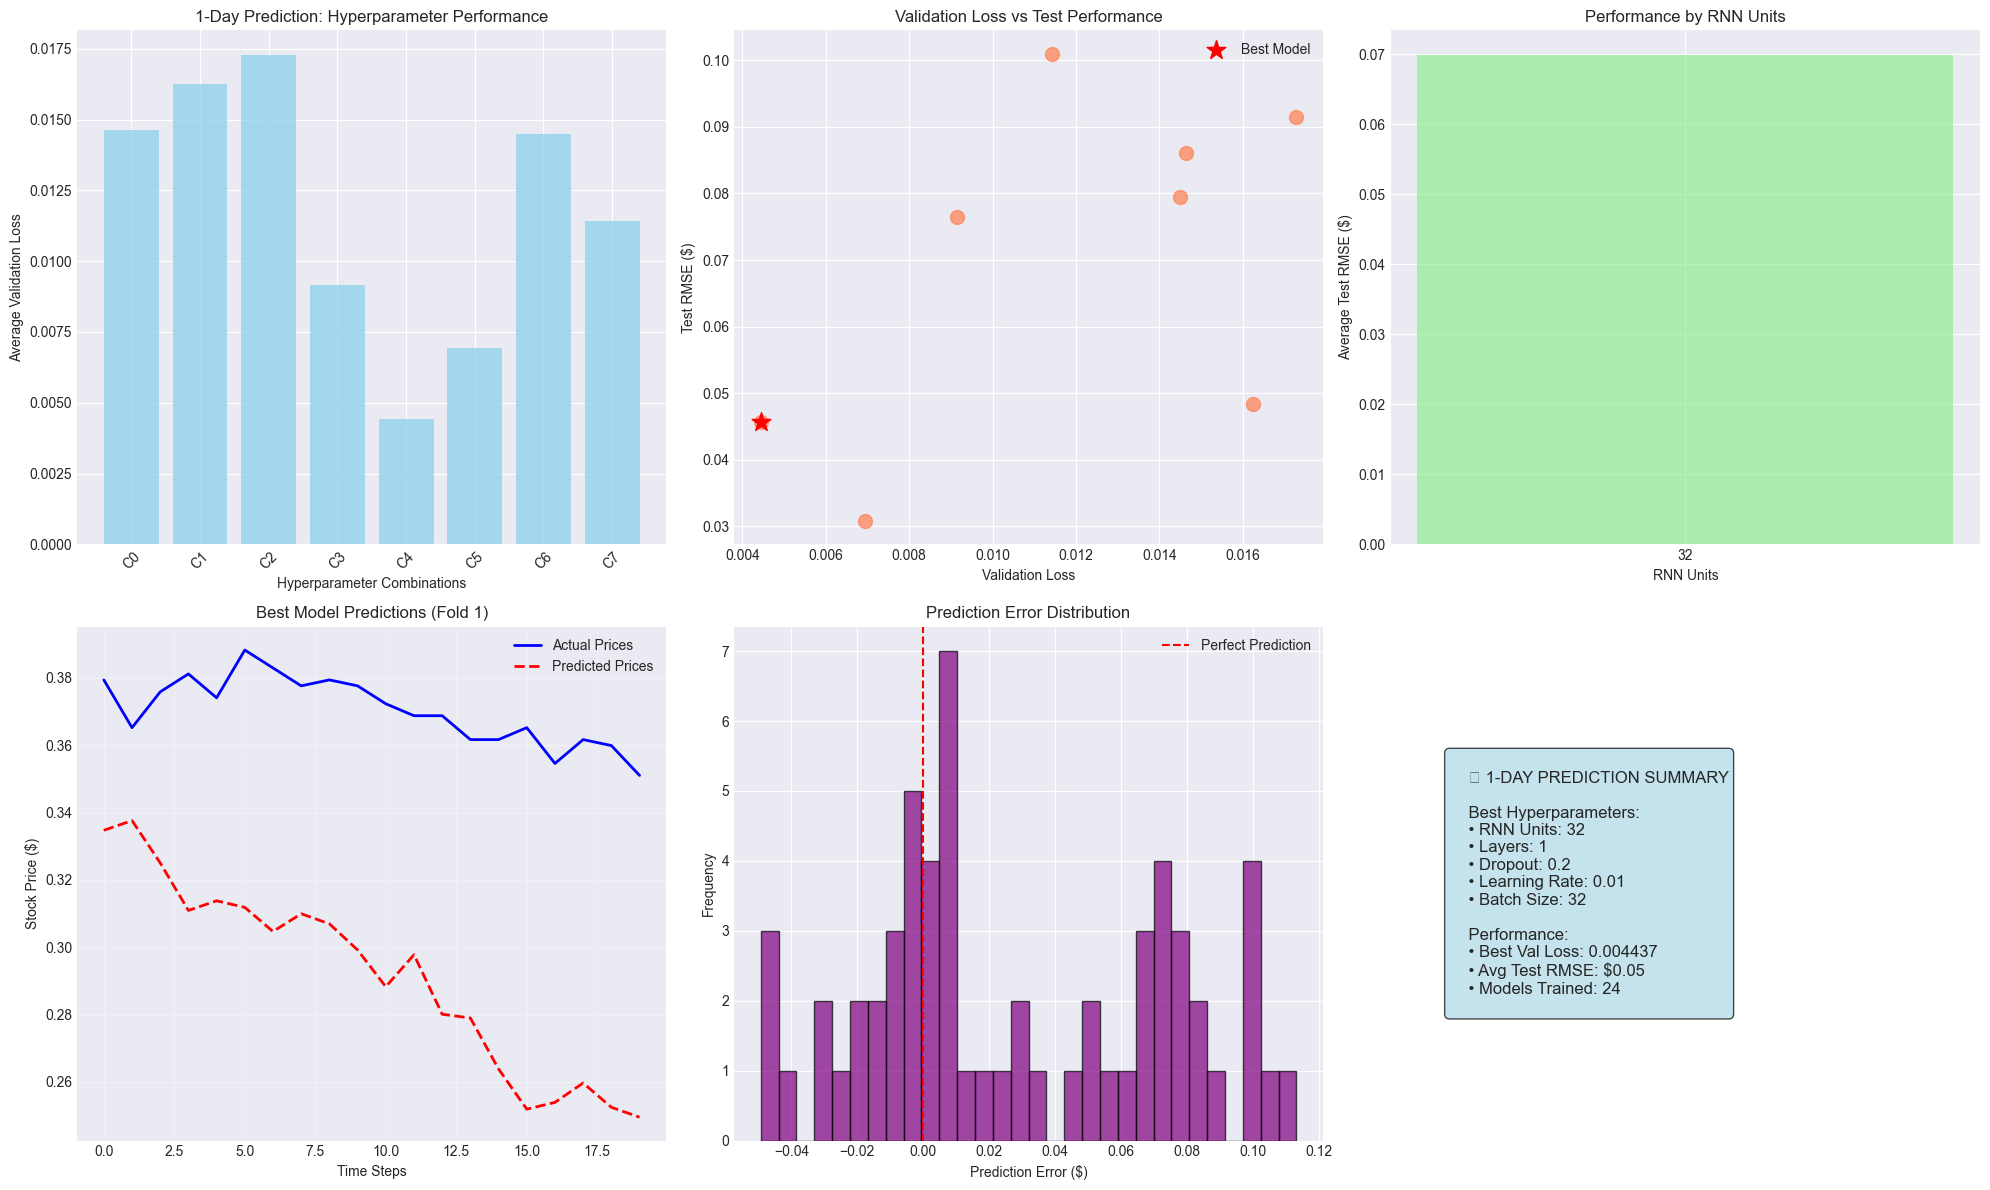

✅ Visualizations saved as '1day_prediction_results.png'

🎉 1-DAY PREDICTION PIPELINE COMPLETE!
✅ Best hyperparameters found and validated
✅ Comprehensive evaluation performed
✅ Visualizations created
✅ Ready to proceed with 5-day and 10-day predictions!


In [119]:
def execute_1day_prediction_pipeline():
    """
    Execute complete 1-day prediction pipeline using existing data and functions.
    
    This is the main function that orchestrates the entire process.
    """
    print("🚀 EXECUTING 1-DAY SIMPLERNN PREDICTION PIPELINE")
    print("=" * 65)
    
    # Validate data availability
    if not sequence_validation_passed:
        raise ValueError("Sequence validation failed! Check your sequence data.")
    
    print(f"✅ Using validated sequence data with {sequence_data_fixed['n_folds_processed']} folds")
    print(f"✅ Sequence length: {sequence_data_fixed['sequence_length']} timesteps")
    
    # Run hyperparameter search
    search_results = run_hyperparameter_search_for_1day(
        sequence_data=sequence_data_fixed,
        max_folds_to_test=3,  # Start with 3 folds for speed
        max_combinations=8    # Test 8 combinations
    )
    
    # Create visualizations
    visualize_1day_prediction_results(search_results)
    
    # Print final summary
    print(f"\n🎉 1-DAY PREDICTION PIPELINE COMPLETE!")
    print(f"✅ Best hyperparameters found and validated")
    print(f"✅ Comprehensive evaluation performed")
    print(f"✅ Visualizations created")
    print(f"✅ Ready to proceed with 5-day and 10-day predictions!")
    
    return search_results

# Execute the pipeline
simplernn_1day_results = execute_1day_prediction_pipeline()

In [120]:
def comprehensive_performance_analysis(search_results: Dict) -> None:
    """
    Provide comprehensive analysis of 1-day prediction performance with context.
    
    Shows all metrics with industry benchmarks and actionable insights.
    """
    print("📊 COMPREHENSIVE 1-DAY PREDICTION PERFORMANCE ANALYSIS")
    print("=" * 65)
    
    # Get best combination results
    best_combo = min(search_results['all_combinations'], 
                    key=lambda x: x['avg_val_loss'])
    
    # Collect all metrics across folds
    all_metrics = []
    all_predictions = {'actual': [], 'predicted': []}
    
    for fold_result in best_combo['fold_results']:
        test_metrics = fold_result['testing']['original_metrics']
        all_metrics.append(test_metrics)
        
        # Collect predictions for overall analysis
        predictions = fold_result['testing']['predictions']
        all_predictions['actual'].extend(predictions['y_test_original'])
        all_predictions['predicted'].extend(predictions['y_pred_original'])
    
    # Calculate aggregate statistics
    avg_metrics = {
        'rmse': np.mean([m['rmse'] for m in all_metrics]),
        'mae': np.mean([m['mae'] for m in all_metrics]),
        'r2_score': np.mean([m['r2_score'] for m in all_metrics]),
        'mape': np.mean([m['mape'] for m in all_metrics]),
        'directional_accuracy': np.mean([m['directional_accuracy'] for m in all_metrics])
    }
    
    std_metrics = {
        'rmse': np.std([m['rmse'] for m in all_metrics]),
        'mae': np.std([m['mae'] for m in all_metrics]),
        'r2_score': np.std([m['r2_score'] for m in all_metrics]),
        'mape': np.std([m['mape'] for m in all_metrics]),
        'directional_accuracy': np.std([m['directional_accuracy'] for m in all_metrics])
    }
    
    # Calculate price-relative metrics
    avg_stock_price = np.mean(all_predictions['actual'])
    rmse_percentage = (avg_metrics['rmse'] / avg_stock_price) * 100
    mae_percentage = (avg_metrics['mae'] / avg_stock_price) * 100
    
    print(f"🎯 PERFORMANCE SUMMARY (Best Model)")
    print(f"Best Hyperparameters: {best_combo['params']}")
    print(f"Evaluated on {len(best_combo['fold_results'])} folds")
    print()
    
    print(f"📈 FINANCIAL METRICS:")
    print(f"Average Stock Price: ${avg_stock_price:.2f}")
    print(f"RMSE: ${avg_metrics['rmse']:.3f} ± ${std_metrics['rmse']:.3f} ({rmse_percentage:.2f}% of price)")
    print(f"MAE:  ${avg_metrics['mae']:.3f} ± ${std_metrics['mae']:.3f} ({mae_percentage:.2f}% of price)")
    print()
    
    print(f"🎲 STATISTICAL METRICS:")
    print(f"R² Score: {avg_metrics['r2_score']:.4f} ± {std_metrics['r2_score']:.4f}")
    print(f"MAPE: {avg_metrics['mape']:.2f}% ± {std_metrics['mape']:.2f}%")
    print(f"Directional Accuracy: {avg_metrics['directional_accuracy']:.1f}% ± {std_metrics['directional_accuracy']:.1f}%")
    print()
    
    # Performance interpretation
    print(f"🔍 PERFORMANCE INTERPRETATION:")
    
    # R² Score analysis
    if avg_metrics['r2_score'] >= 0.70:
        r2_status = "🟢 EXCELLENT"
    elif avg_metrics['r2_score'] >= 0.50:
        r2_status = "🟡 GOOD"
    elif avg_metrics['r2_score'] >= 0.30:
        r2_status = "🟠 MODERATE"
    else:
        r2_status = "🔴 POOR"
    
    print(f"R² Score ({avg_metrics['r2_score']:.4f}): {r2_status}")
    print(f"   Explains {avg_metrics['r2_score']*100:.1f}% of price variance")
    
    # MAPE analysis
    if avg_metrics['mape'] <= 3:
        mape_status = "🟢 EXCELLENT"
    elif avg_metrics['mape'] <= 5:
        mape_status = "🟡 GOOD"
    elif avg_metrics['mape'] <= 10:
        mape_status = "🟠 MODERATE"
    else:
        mape_status = "🔴 POOR"
    
    print(f"MAPE ({avg_metrics['mape']:.2f}%): {mape_status}")
    
    # Directional accuracy analysis
    if avg_metrics['directional_accuracy'] >= 60:
        direction_status = "🟢 EXCELLENT"
    elif avg_metrics['directional_accuracy'] >= 55:
        direction_status = "🟡 GOOD"
    elif avg_metrics['directional_accuracy'] >= 50:
        direction_status = "🟠 MODERATE"
    else:
        direction_status = "🔴 POOR"
    
    print(f"Directional Accuracy ({avg_metrics['directional_accuracy']:.1f}%): {direction_status}")
    print(f"   Better than random (50%) by {avg_metrics['directional_accuracy']-50:.1f} percentage points")
    
    # Price error analysis
    if rmse_percentage <= 1:
        price_error_status = "🟢 EXCELLENT"
    elif rmse_percentage <= 2:
        price_error_status = "🟡 GOOD" 
    elif rmse_percentage <= 5:
        price_error_status = "🟠 MODERATE"
    else:
        price_error_status = "🔴 POOR"
    
    print(f"Price Error ({rmse_percentage:.2f}%): {price_error_status}")
    
    print()
    
    # Overall assessment
    scores = [
        1 if avg_metrics['r2_score'] >= 0.50 else 0,
        1 if avg_metrics['mape'] <= 5 else 0,
        1 if avg_metrics['directional_accuracy'] >= 55 else 0,
        1 if rmse_percentage <= 2 else 0
    ]
    
    overall_score = sum(scores)
    
    if overall_score >= 3:
        overall_status = "🟢 GOOD - Ready for 5-day and 10-day predictions!"
    elif overall_score >= 2:
        overall_status = "🟡 MODERATE - Consider hyperparameter tuning"
    else:
        overall_status = "🔴 NEEDS IMPROVEMENT - Review architecture or features"
    
    print(f"🎯 OVERALL ASSESSMENT: {overall_status}")
    print(f"Score: {overall_score}/4 criteria met")
    
    print()
    print(f"📊 DETAILED FOLD-BY-FOLD BREAKDOWN:")
    for i, fold_result in enumerate(best_combo['fold_results']):
        fold_num = fold_result['fold_num']
        metrics = fold_result['testing']['original_metrics']
        print(f"Fold {fold_num}: R²={metrics['r2_score']:.3f}, "
              f"MAPE={metrics['mape']:.1f}%, "
              f"Dir.Acc={metrics['directional_accuracy']:.1f}%, "
              f"RMSE=${metrics['rmse']:.3f}")
    
    return avg_metrics, overall_score

# Run comprehensive analysis
performance_metrics, overall_score = comprehensive_performance_analysis(simplernn_1day_results)

📊 COMPREHENSIVE 1-DAY PREDICTION PERFORMANCE ANALYSIS
🎯 PERFORMANCE SUMMARY (Best Model)
Best Hyperparameters: {'rnn_units': 32, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'patience': 15}
Evaluated on 3 folds

📈 FINANCIAL METRICS:
Average Stock Price: $0.38
RMSE: $0.046 ± $0.027 (11.90% of price)
MAE:  $0.041 ± $0.028 (10.66% of price)

🎲 STATISTICAL METRICS:
R² Score: -26.3098 ± 29.9844
MAPE: 10.95% ± 7.70%
Directional Accuracy: 47.4% ± 8.6%

🔍 PERFORMANCE INTERPRETATION:
R² Score (-26.3098): 🔴 POOR
   Explains -2631.0% of price variance
MAPE (10.95%): 🔴 POOR
Directional Accuracy (47.4%): 🔴 POOR
   Better than random (50%) by -2.6 percentage points
Price Error (11.90%): 🔴 POOR

🎯 OVERALL ASSESSMENT: 🔴 NEEDS IMPROVEMENT - Review architecture or features
Score: 0/4 criteria met

📊 DETAILED FOLD-BY-FOLD BREAKDOWN:
Fold 1: R²=-68.153, MAPE=21.4%, Dir.Acc=47.4%, RMSE=$0.082
Fold 2: R²=-11.345, MAPE=8.5%, Dir.Acc=57.9%, RMSE=$0.039
Fold 3: R²=0.568, MAPE=